# Snapping points to lines and identifying streets with the most street flooding complaints

Mark Bauer

In [347]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import geopandas as gpd
import fiona
from fiona.crs import from_epsg
import contextily as ctx

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

Printing verions of Python modules and packages with **watermark** - the IPython magic extension.

In [348]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [349]:
%watermark -v -p numpy,pandas,geopandas,matplotlib.pyplot,matplotlib,seaborn,fiona,contextily

CPython 3.7.1
IPython 7.18.1

numpy 1.19.2
pandas 1.0.0
geopandas 0.8.1
matplotlib.pyplot 3.3.2
matplotlib 3.3.2
seaborn 0.11.0
fiona 1.8.13.post1
contextily 1.0.0


Documention for installing watermark: https://github.com/rasbt/watermark

# 2. Loading Data

In [350]:
# list items in data folder
%ls data-raw/

raw-street-flooding-data.csv  raw-streets-clipped.json


In [351]:
# read data as a dataframe
flooding_311 = pd.read_csv('data-raw/raw-street-flooding-data.csv')

# previewing first five rows in data
print(flooding_311.shape)
flooding_311.head()

(27906, 38)


/Users/geribauer/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


unique_key             created_date              closed_date agency  \
0    45989680  2020-04-12T14:14:00.000  2020-04-13T08:10:00.000    DEP   
1    45178597  2019-12-16T07:48:00.000  2020-01-16T13:35:00.000    DEP   
2    47428465  2020-09-01T09:58:00.000  2020-09-01T18:05:00.000    DEP   
3    48133312  2020-11-12T16:23:00.000  2020-11-13T14:10:00.000    DEP   
4    48135671  2020-11-12T14:19:00.000  2020-11-16T08:35:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor cross_street_1   cross_street_2 intersection_street_1  \
0  Street Flooding (SJ)     BEMENT AVE    N BURGHER AVE                   NaN   
1  Street Flooding (SJ)            NaN              NaN       WILLIAMS AVENUE   
2  Street Flooding (SJ)   HILLSIDE AVE  E WILLISTON AVE                   NaN   
3  Street Flooding (SJ)        E 85 ST          E 86 ST                   NaN   
4  Street Flooding (SJ)            NaN              NaN       SAPPHIRE STREET   

   ... location_type     incident_address      street_name landmark  \
0  ...           NaN  204 MORRISON AVENUE  MORRISON AVENUE      NaN   
1  ...           NaN                  NaN              NaN      NaN   
2  ...           NaN     84-17 265 STREET       265 STREET      NaN   
3  ...           NaN        8518 AVENUE N         AVENUE N      NaN   
4  ...           NaN                  NaN              NaN      NaN   

            bbl due_date bridge_highway_name bridge_highway_direction  \
0  5.003000e+09      NaN                 NaN                      NaN   
1           NaN      NaN                 NaN                      NaN   
2  4.087950e+09      NaN                 NaN                      NaN   
3  3.080820e+09      NaN                 NaN                      NaN   
4           NaN      NaN                 NaN                      NaN   

  road_ramp  bridge_highway_segment  
0       NaN                     NaN  
1       NaN                     NaN  
2       NaN                     NaN  
3       NaN                     NaN  
4       NaN                     NaN  

[5 rows x 38 columns]

In [352]:
# previewing the last five rows of our dataframe
flooding_311.tail()

unique_key             created_date              closed_date agency  \
27901    44965364  2019-11-19T09:59:00.000  2019-12-15T10:00:00.000    DEP   
27902    48037294  2020-11-01T19:49:00.000  2020-11-01T21:25:00.000    DEP   
27903    48039076  2020-11-01T18:17:00.000  2020-11-01T21:00:00.000    DEP   
27904    48043652  2020-11-01T16:52:00.000  2020-11-02T01:30:00.000    DEP   
27905    48047404  2020-11-02T10:27:00.000  2020-11-02T11:15:00.000    DEP   

                                  agency_name complaint_type  \
27901  Department of Environmental Protection          Sewer   
27902  Department of Environmental Protection          Sewer   
27903  Department of Environmental Protection          Sewer   
27904  Department of Environmental Protection          Sewer   
27905  Department of Environmental Protection          Sewer   

                 descriptor   cross_street_1 cross_street_2  \
27901  Street Flooding (SJ)              NaN            NaN   
27902  Street Flooding (SJ)             BEND           BEND   
27903  Street Flooding (SJ)         BEACH ST       CROSS ST   
27904  Street Flooding (SJ)           230 PL         231 ST   
27905  Street Flooding (SJ)  CO-OP CITY BLVD       BROUN PL   

      intersection_street_1  ... location_type       incident_address  \
27901    VAN SICKLEN STREET  ...           NaN                    NaN   
27902                   NaN  ...           NaN   1 ORCHARD BEACH ROAD   
27903                   NaN  ...           NaN  533 MINNIEFORD AVENUE   
27904                   NaN  ...           NaN      230-48 148 AVENUE   
27905                   NaN  ...           NaN       100 BELLAMY LOOP   

              street_name landmark           bbl due_date bridge_highway_name  \
27901                 NaN      NaN           NaN      NaN                 NaN   
27902  ORCHARD BEACH ROAD      NaN  2.056500e+09      NaN                 NaN   
27903   MINNIEFORD AVENUE      NaN  2.056350e+09      NaN                 NaN   
27904          148 AVENUE      NaN  4.137190e+09      NaN                 NaN   
27905        BELLAMY LOOP      NaN  2.051410e+09      NaN                 NaN   

      bridge_highway_direction road_ramp  bridge_highway_segment  
27901                      NaN       NaN                     NaN  
27902                      NaN       NaN                     NaN  
27903                      NaN       NaN                     NaN  
27904                      NaN       NaN                     NaN  
27905                      NaN       NaN                     NaN  

[5 rows x 38 columns]

# 3. Data Inspection

In [353]:
# the object's type
type(flooding_311)

pandas.core.frame.DataFrame

In [354]:
# printing the columns of our dataframe
flooding_311.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'status',
       'resolution_description', 'resolution_action_updated_date',
       'community_board', 'borough', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'incident_zip', 'address_type',
       'city', 'facility_type', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'latitude', 'longitude', 'location',
       'location_type', 'incident_address', 'street_name', 'landmark', 'bbl',
       'due_date', 'bridge_highway_name', 'bridge_highway_direction',
       'road_ramp', 'bridge_highway_segment'],
      dtype='object')

In [355]:
# printing the data types of our columns
flooding_311.dtypes

unique_key                          int64
created_date                       object
closed_date                        object
agency                             object
agency_name                        object
complaint_type                     object
descriptor                         object
cross_street_1                     object
cross_street_2                     object
intersection_street_1              object
intersection_street_2              object
status                             object
resolution_description             object
resolution_action_updated_date     object
community_board                    object
borough                            object
open_data_channel_type             object
park_facility_name                 object
park_borough                       object
incident_zip                      float64
address_type                       object
city                               object
facility_type                     float64
x_coordinate_state_plane          

In [356]:
# printing the column names, non-null counts, and data types of our columns
flooding_311.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27906 entries, 0 to 27905
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      27906 non-null  int64  
 1   created_date                    27906 non-null  object 
 2   closed_date                     27895 non-null  object 
 3   agency                          27906 non-null  object 
 4   agency_name                     27906 non-null  object 
 5   complaint_type                  27906 non-null  object 
 6   descriptor                      27906 non-null  object 
 7   cross_street_1                  24144 non-null  object 
 8   cross_street_2                  24133 non-null  object 
 9   intersection_street_1           10098 non-null  object 
 10  intersection_street_2           10098 non-null  object 
 11  status                          27906 non-null  object 
 12  resolution_description          

In [357]:
# printing the columns of our dataframe
flooding_311.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'status',
       'resolution_description', 'resolution_action_updated_date',
       'community_board', 'borough', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'incident_zip', 'address_type',
       'city', 'facility_type', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'latitude', 'longitude', 'location',
       'location_type', 'incident_address', 'street_name', 'landmark', 'bbl',
       'due_date', 'bridge_highway_name', 'bridge_highway_direction',
       'road_ramp', 'bridge_highway_segment'],
      dtype='object')

In [358]:
flooding_311 = flooding_311[['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
                           'complaint_type', 'descriptor', 'incident_zip', 'intersection_street_1',
                           'intersection_street_2', 'address_type', 'city', 'status',
                           'resolution_description', 'resolution_action_updated_date',
                           'community_board', 'borough', 'x_coordinate_state_plane',
                           'y_coordinate_state_plane', 'open_data_channel_type',
                           'park_facility_name', 'park_borough', 'latitude', 'longitude',
                           'location', 'incident_address', 'street_name', 'cross_street_1',
                           'cross_street_2', 'bbl']]

In [359]:
# printing the column names, non-null counts, and data types of our columns
flooding_311.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27906 entries, 0 to 27905
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      27906 non-null  int64  
 1   created_date                    27906 non-null  object 
 2   closed_date                     27895 non-null  object 
 3   agency                          27906 non-null  object 
 4   agency_name                     27906 non-null  object 
 5   complaint_type                  27906 non-null  object 
 6   descriptor                      27906 non-null  object 
 7   incident_zip                    27048 non-null  float64
 8   intersection_street_1           10098 non-null  object 
 9   intersection_street_2           10098 non-null  object 
 10  address_type                    27900 non-null  object 
 11  city                            27049 non-null  object 
 12  status                          

In [360]:
# counts of unique values of our datatypes 
flooding_311.dtypes.value_counts()

object     23
float64     6
int64       1
dtype: int64

In [361]:
# printing index type
flooding_311.index

RangeIndex(start=0, stop=27906, step=1)

In [362]:
# printing True/False if column is unique on our unique key (DOITT_ID)
flooding_311['unique_key'].is_unique

True

In [363]:
flooding_311['descriptor'].value_counts()

Street Flooding (SJ)    27906
Name: descriptor, dtype: int64

In [364]:
flooding_311.shape

(27906, 30)

In [365]:
flooding_311.x_coordinate_state_plane.isna().sum()

944

In [366]:
# You may want to drop any that didn't snap, if so:
flooding_311 = flooding_311.dropna(subset=["x_coordinate_state_plane"])

In [367]:
flooding_311.x_coordinate_state_plane.isna().sum()

0

In [368]:
flooding_311.shape

(26962, 30)

In [369]:
flooding_311[['x_coordinate_state_plane', 'y_coordinate_state_plane']].isna().sum()

x_coordinate_state_plane    0
y_coordinate_state_plane    0
dtype: int64

In [370]:
flooding_311[['x_coordinate_state_plane', 'y_coordinate_state_plane']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26962 entries, 0 to 27905
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   x_coordinate_state_plane  26962 non-null  float64
 1   y_coordinate_state_plane  26962 non-null  float64
dtypes: float64(2)
memory usage: 631.9 KB


In [371]:
url = 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON'
nta_shape = gpd.read_file(url)

nta_shape.head()

ntacode     shape_area county_fips        ntaname     shape_leng boro_name  \
0    BK88   54005019.048         047   Borough Park  39247.2278309  Brooklyn   
1    QN51  52488277.5915         081    Murray Hill  33266.9048721    Queens   
2    QN27  19726845.5925         081  East Elmhurst  19816.7121316    Queens   
3    BK95  14522603.5915         047        Erasmus  18756.7018646  Brooklyn   
4    QN07  22887772.8087         081         Hollis  20976.3355996    Queens   

  boro_code                                           geometry  
0         3  MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...  
1         4  MULTIPOLYGON (((-73.80379 40.77561, -73.80099 ...  
2         4  MULTIPOLYGON (((-73.86110 40.76366, -73.85993 ...  
3         3  MULTIPOLYGON (((-73.94826 40.63861, -73.94923 ...  
4         4  MULTIPOLYGON (((-73.75726 40.71814, -73.75589 ...

In [372]:
nta_shape.to_crs(epsg=2263, inplace=True)
nta_shape.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

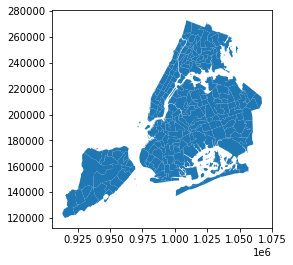

In [373]:
nta_shape.plot()

In [374]:
nta_shape.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ntacode      195 non-null    object  
 1   shape_area   195 non-null    object  
 2   county_fips  195 non-null    object  
 3   ntaname      195 non-null    object  
 4   shape_leng   195 non-null    object  
 5   boro_name    195 non-null    object  
 6   boro_code    195 non-null    object  
 7   geometry     195 non-null    geometry
dtypes: geometry(1), object(7)
memory usage: 12.3+ KB


# 4. Mapping

## City-Wide

In [375]:
gdf = gpd.GeoDataFrame(flooding_311, 
                       geometry=gpd.points_from_xy(flooding_311.x_coordinate_state_plane, 
                                                   flooding_311.y_coordinate_state_plane))

gdf.set_crs(epsg=2263, inplace=True)
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [376]:
gdf = gpd.sjoin(gdf, 
                nta_shape, 
                how="inner", 
                op='within')

In [377]:
gdf.head()

unique_key             created_date              closed_date agency  \
0      45989680  2020-04-12T14:14:00.000  2020-04-13T08:10:00.000    DEP   
66     45188341  2019-12-18T08:20:00.000  2019-12-20T09:30:00.000    DEP   
83     46379956  2020-06-04T07:24:00.000  2020-06-04T14:40:00.000    DEP   
185    46122447  2020-05-03T13:25:00.000  2020-05-03T14:20:00.000    DEP   
537    24452089  2012-11-21T09:58:00.000  2012-11-22T09:30:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
66   Department of Environmental Protection          Sewer   
83   Department of Environmental Protection          Sewer   
185  Department of Environmental Protection          Sewer   
537  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       10310.0                   NaN   
66   Street Flooding (SJ)       10310.0              BROADWAY   
83   Street Flooding (SJ)       10310.0                   NaN   
185  Street Flooding (SJ)       10310.0                   NaN   
537  Street Flooding (SJ)       10310.0                   NaN   

    intersection_street_2  ...           bbl                       geometry  \
0                     NaN  ...  5.003000e+09  POINT (952928.000 168312.000)   
66       DELAFIELD AVENUE  ...           NaN  POINT (951912.000 169099.000)   
83                    NaN  ...  5.001470e+09  POINT (954593.000 169517.000)   
185                   NaN  ...  5.002840e+09  POINT (954095.000 168394.000)   
537                   NaN  ...  5.003000e+09  POINT (952928.000 168312.000)   

    index_right ntacode     shape_area county_fips                   ntaname  \
0           122    SI35  47137243.9922         085  New Brighton-Silver Lake   
66          122    SI35  47137243.9922         085  New Brighton-Silver Lake   
83          122    SI35  47137243.9922         085  New Brighton-Silver Lake   
185         122    SI35  47137243.9922         085  New Brighton-Silver Lake   
537         122    SI35  47137243.9922         085  New Brighton-Silver Lake   

        shape_leng      boro_name boro_code  
0    30320.3749453  Staten Island         5  
66   30320.3749453  Staten Island         5  
83   30320.3749453  Staten Island         5  
185  30320.3749453  Staten Island         5  
537  30320.3749453  Staten Island         5  

[5 rows x 39 columns]

<AxesSubplot:>

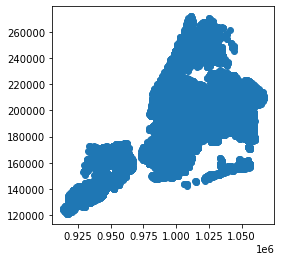

In [378]:
gdf.plot()

In [379]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 26960 entries, 0 to 10871
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      26960 non-null  int64   
 1   created_date                    26960 non-null  object  
 2   closed_date                     26949 non-null  object  
 3   agency                          26960 non-null  object  
 4   agency_name                     26960 non-null  object  
 5   complaint_type                  26960 non-null  object  
 6   descriptor                      26960 non-null  object  
 7   incident_zip                    26960 non-null  float64 
 8   intersection_street_1           9353 non-null   object  
 9   intersection_street_2           9353 non-null   object  
 10  address_type                    26960 non-null  object  
 11  city                            26960 non-null  object  
 12  status    

In [380]:
gdf.describe()

unique_key  incident_zip  x_coordinate_state_plane  \
count  2.696000e+04  26960.000000              2.696000e+04   
mean   3.255031e+07  10969.404674              1.005498e+06   
std    9.173646e+06    536.329061              3.504975e+04   
min    1.563993e+07  10001.000000              9.133570e+05   
25%    2.455765e+07  10312.000000              9.868788e+05   
50%    3.291334e+07  11221.000000              1.007480e+06   
75%    4.043929e+07  11385.000000              1.033979e+06   
max    4.859752e+07  11697.000000              1.067279e+06   

       y_coordinate_state_plane      latitude     longitude           bbl  \
count              26960.000000  24461.000000  24461.000000  1.616200e+04   
mean              186178.151743     40.677489    -73.922115  3.699928e+09   
std                30570.611802      0.083691      0.126317  1.075575e+09   
min               121032.000000     40.498628    -74.254937  0.000000e+00   
25%               161256.500000     40.609118    -73.989731  3.060248e+09   
50%               183604.500000     40.670454    -73.915311  4.067969e+09   
75%               206467.000000     40.732343    -73.819532  4.156275e+09   
max               271876.000000     40.912869    -73.700384  5.080500e+09   

        index_right  
count  26960.000000  
mean     100.080045  
std       58.710685  
min        0.000000  
25%       50.000000  
50%       97.000000  
75%      159.000000  
max      194.000000

In [381]:
gdf.drop(columns=["shape_leng", 'shape_area'], inplace=True)

In [382]:
ls data-raw/

raw-street-flooding-data.csv  raw-streets-clipped.json


In [383]:
path = 'data-raw/raw-streets-clipped.json'
streets = gpd.read_file(path)

streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  
0  LINESTRING (1047146.080 222733.432, 1047385.93...  
1  LINESTRING (1009926.638 269075.549, 1010033.71...  
2  LINESTRING (989292.818 189689.736, 989648.842 ...  
3  LINESTRING (1031371.427 199453.863, 1031412.58...  
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [384]:
streets.shape

(99362, 12)

<AxesSubplot:>

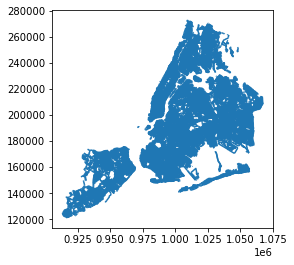

In [385]:
streets.plot()

In [386]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99362 entries, 0 to 99361
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99362 non-null  object  
 1   st_label      99362 non-null  object  
 2   st_name       99362 non-null  object  
 3   full_stree    99362 non-null  object  
 4   rw_type       99362 non-null  object  
 5   rw_type_name  99362 non-null  object  
 6   st_width      99362 non-null  object  
 7   frm_lvl_co    99362 non-null  object  
 8   to_lvl_co     99362 non-null  object  
 9   borocode      99362 non-null  object  
 10  shape_leng    99362 non-null  float64 
 11  geometry      99362 non-null  geometry
dtypes: float64(1), geometry(1), object(10)
memory usage: 9.1+ MB


In [387]:
streets.geom_type.value_counts()

LineString    99362
dtype: int64

In [388]:
streets.describe()

shape_leng
count  9.936200e+04
mean   3.431188e+02
std    2.620211e+02
min    1.068681e-08
25%    1.953735e+02
50%    2.648459e+02
75%    4.583545e+02
max    1.509366e+04

# Snap points to lines

In [389]:
streets.sindex

rtree.index.Index(bounds=[913351.9846191381, 120918.59619133211, 1067379.5294189155, 272688.0944213113], size=99362)

In [390]:
offset = 80

bbox = gdf.bounds + [-offset, -offset, offset, offset]

bbox.head()

minx      miny      maxx      maxy
0    952848.0  168232.0  953008.0  168392.0
66   951832.0  169019.0  951992.0  169179.0
83   954513.0  169437.0  954673.0  169597.0
185  954015.0  168314.0  954175.0  168474.0
537  952848.0  168232.0  953008.0  168392.0

In [391]:
hits = bbox.apply(lambda row: list(streets.sindex.intersection(row)), axis=1)

hits.head()

0                    [62220, 50283]
66     [53797, 32008, 47959, 60739]
83                    [7062, 44910]
185    [55539, 27635, 42827, 30114]
537                  [62220, 50283]
dtype: object

In [392]:
hits.shape

(26960,)

In [393]:
tmp = pd.DataFrame(
                {
                # index of points table
                "pt_idx": np.repeat(hits.index, hits.apply(len)),
                    
                # ordinal position of line - access via iloc later
                "line_i": np.concatenate(hits.values)
                })

In [394]:
tmp.head()

pt_idx   line_i
0       0  62220.0
1       0  50283.0
2      66  53797.0
3      66  32008.0
4      66  47959.0

In [395]:
tmp.shape

(89777, 2)

In [396]:
streets.shape

(99362, 12)

In [397]:
streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  
0  LINESTRING (1047146.080 222733.432, 1047385.93...  
1  LINESTRING (1009926.638 269075.549, 1010033.71...  
2  LINESTRING (989292.818 189689.736, 989648.842 ...  
3  LINESTRING (1031371.427 199453.863, 1031412.58...  
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [398]:
# Join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(streets.reset_index(drop=True), on="line_i")

tmp.head()

pt_idx   line_i physicalid       st_label    st_name      full_stree  \
0       0  62220.0      68431  N BURGHER AVE    BURGHER  N  BURGHER AVE   
1       0  50283.0      63978   MORRISON AVE   MORRISON    MORRISON AVE   
2      66  53797.0      35045       BROADWAY   BROADWAY        BROADWAY   
3      66  32008.0      88092  DELAFIELD AVE  DELAFIELD   DELAFIELD AVE   
4      66  47959.0      88091  DELAFIELD AVE  DELAFIELD   DELAFIELD AVE   

  rw_type rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       1       Street       30         13        13        5  261.179012   
1       1       Street       30         13        13        5  589.098755   
2       1       Street       30         13        13        5  338.316513   
3       1       Street       30         13        13        5  974.569920   
4       1       Street       30         13        13        5  775.561313   

                                            geometry  
0  LINESTRING (952824.011 168298.887, 952864.355 ...  
1  LINESTRING (953406.355 168387.837, 952824.011 ...  
2  LINESTRING (951911.864 169099.197, 951955.443 ...  
3  LINESTRING (951911.864 169099.197, 951432.518 ...  
4  LINESTRING (952677.620 169222.130, 951911.864 ...

In [399]:
# Join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(gdf.geometry.rename("point"), on="pt_idx")

# Convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(tmp, geometry="geometry", crs=gdf.crs)

In [400]:
tmp.head()

pt_idx   line_i physicalid       st_label    st_name      full_stree  \
0       0  62220.0      68431  N BURGHER AVE    BURGHER  N  BURGHER AVE   
1       0  50283.0      63978   MORRISON AVE   MORRISON    MORRISON AVE   
2      66  53797.0      35045       BROADWAY   BROADWAY        BROADWAY   
3      66  32008.0      88092  DELAFIELD AVE  DELAFIELD   DELAFIELD AVE   
4      66  47959.0      88091  DELAFIELD AVE  DELAFIELD   DELAFIELD AVE   

  rw_type rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       1       Street       30         13        13        5  261.179012   
1       1       Street       30         13        13        5  589.098755   
2       1       Street       30         13        13        5  338.316513   
3       1       Street       30         13        13        5  974.569920   
4       1       Street       30         13        13        5  775.561313   

                                            geometry  \
0  LINESTRING (952824.011 168298.887, 952864.355 ...   
1  LINESTRING (953406.355 168387.837, 952824.011 ...   
2  LINESTRING (951911.864 169099.197, 951955.443 ...   
3  LINESTRING (951911.864 169099.197, 951432.518 ...   
4  LINESTRING (952677.620 169222.130, 951911.864 ...   

                           point  
0  POINT (952928.000 168312.000)  
1  POINT (952928.000 168312.000)  
2  POINT (951912.000 169099.000)  
3  POINT (951912.000 169099.000)  
4  POINT (951912.000 169099.000)

In [401]:
tmp["snap_dist"] = tmp.geometry.distance(gpd.GeoSeries(tmp.point))

tmp.head()

pt_idx   line_i physicalid       st_label    st_name      full_stree  \
0       0  62220.0      68431  N BURGHER AVE    BURGHER  N  BURGHER AVE   
1       0  50283.0      63978   MORRISON AVE   MORRISON    MORRISON AVE   
2      66  53797.0      35045       BROADWAY   BROADWAY        BROADWAY   
3      66  32008.0      88092  DELAFIELD AVE  DELAFIELD   DELAFIELD AVE   
4      66  47959.0      88091  DELAFIELD AVE  DELAFIELD   DELAFIELD AVE   

  rw_type rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       1       Street       30         13        13        5  261.179012   
1       1       Street       30         13        13        5  589.098755   
2       1       Street       30         13        13        5  338.316513   
3       1       Street       30         13        13        5  974.569920   
4       1       Street       30         13        13        5  775.561313   

                                            geometry  \
0  LINESTRING (952824.011 168298.887, 952864.355 ...   
1  LINESTRING (953406.355 168387.837, 952824.011 ...   
2  LINESTRING (951911.864 169099.197, 951955.443 ...   
3  LINESTRING (951911.864 169099.197, 951432.518 ...   
4  LINESTRING (952677.620 169222.130, 951911.864 ...   

                           point   snap_dist  
0  POINT (952928.000 168312.000)  104.766596  
1  POINT (952928.000 168312.000)    2.739228  
2  POINT (951912.000 169099.000)    0.109875  
3  POINT (951912.000 169099.000)    0.239788  
4  POINT (951912.000 169099.000)    0.216334

In [402]:
tmp[['snap_dist']].describe()

snap_dist
count  89777.000000
mean      48.757237
std      109.097139
min        0.000002
25%        0.429168
50%        3.355742
75%       63.698623
max     3109.136264

In [403]:
# Discard any lines that are greater than tolerance from points
tmp = tmp.loc[tmp.snap_dist <= offset]

# Sort on ascending snap distance, so that closest goes to top
tmp = tmp.sort_values(by=["snap_dist"])

tmp.head()

pt_idx   line_i physicalid st_label st_name  full_stree rw_type  \
29007   20626  78871.0      53191    63 ST      63       63 ST       1   
66864    5367  75852.0      12940    99 ST      99       99 ST       1   
66888    7022  75852.0      12940    99 ST      99       99 ST       1   
79096   18940  17714.0      45636  E 22 ST      22    E  22 ST       1   
48070   20508  33502.0       1116    8 AVE  EIGHTH  EIGHTH AVE       1   

      rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
29007       Street       30         13        13        3  778.787201   
66864       Street       56         13        13        4  776.951894   
66888       Street       56         13        13        4  776.951894   
79096       Street       30         13        13        3  880.043541   
48070       Street       68         13        13        1  261.957251   

                                                geometry  \
29007  LINESTRING (984162.923 167762.061, 984772.939 ...   
66864  LINESTRING (1022531.087 209487.727, 1022844.15...   
66888  LINESTRING (1022531.087 209487.727, 1022844.15...   
79096  LINESTRING (996772.973 168199.186, 996898.570 ...   
48070  LINESTRING (984801.902 211046.822, 984928.407 ...   

                                point  snap_dist  
29007   POINT (984163.000 167762.000)   0.000002  
66864  POINT (1022844.000 208777.000)   0.000026  
66888  POINT (1022844.000 208777.000)   0.000026  
79096   POINT (996773.000 168199.000)   0.000030  
48070   POINT (984802.000 211047.000)   0.000045

In [404]:
tmp[['snap_dist']].describe()

snap_dist
count  73333.000000
mean      16.298247
std       23.965208
min        0.000002
25%        0.358298
50%        2.785152
75%       29.617279
max       79.994171

In [405]:
# group by the index of the points and take the first, which is the
# closest line 
closest = tmp.groupby("pt_idx").first()

# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")

closest.head()

line_i physicalid      st_label   st_name    full_stree rw_type  \
pt_idx                                                                     
0       50283.0      63978  MORRISON AVE  MORRISON  MORRISON AVE       1   
1       21917.0     165113  WILLIAMS AVE  WILLIAMS  WILLIAMS AVE       1   
2       27091.0      33198        265 ST       265        265 ST       1   
3       10878.0      74799         AVE N         N         AVE N       1   
4       97517.0     173312    LORING AVE    LORING    LORING AVE       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
0            Street       30         13        13        5  589.098755   
1            Street       30         13        13        3   34.960822   
2            Street       30         13        13        4  335.596857   
3            Street       44         13        13        3  269.888435   
4            Street       30         13        13        3  241.555935   

                                                 geometry  \
pt_idx                                                      
0       LINESTRING (953406.355 168387.837, 952824.011 ...   
1       LINESTRING (1011761.601 185801.535, 1011768.18...   
2       LINESTRING (1066350.860 208404.984, 1066442.48...   
3       LINESTRING (1011864.878 168704.313, 1012070.34...   
4       LINESTRING (1023724.487 182856.704, 1023962.32...   

                                 point  snap_dist  
pt_idx                                             
0        POINT (952928.000 168312.000)   2.739228  
1       POINT (1011768.000 185786.000)   0.009974  
2       POINT (1066404.000 208228.000)   2.801330  
3       POINT (1011924.000 168751.000)   2.791750  
4       POINT (1023962.000 182899.000)   0.129147

In [406]:
closest.index.is_unique

True

In [407]:
closest.physicalid.is_unique

False

In [408]:
len(gdf)

26960

In [409]:
len(closest)

26900

In [410]:
len(closest)/len(gdf)

0.9977744807121661

In [411]:
print("We've dropped", str(len(gdf) - len(closest)), '(' + \
      str(round((1 - (len(closest) / len(gdf))) * 100, 2)) + \
      '%) of street flooding complaint points that\nwere more than 80 ft. ' + \
      'from the closest street center line.')

We've dropped 60 (0.22%) of street flooding complaint points that
were more than 80 ft. from the closest street center line.


In [412]:
# Position of nearest point from start of the line
pos = closest.geometry.project(gpd.GeoSeries(closest.point))

# Get new point location geometry
new_pts = closest.geometry.interpolate(pos)

new_pts.head()

pt_idx
0     POINT (952927.586 168314.708)
1    POINT (1011768.009 185786.004)
2    POINT (1066401.305 208227.235)
3    POINT (1011922.190 168753.125)
4    POINT (1023962.023 182898.873)
dtype: geometry

In [413]:
# Create a new GeoDataFrame from the columns from the closest line and 
# new point geometries (which will be called "geometries")
snapped = gpd.GeoDataFrame(closest, geometry=new_pts)

snapped.head()

line_i physicalid      st_label   st_name    full_stree rw_type  \
pt_idx                                                                     
0       50283.0      63978  MORRISON AVE  MORRISON  MORRISON AVE       1   
1       21917.0     165113  WILLIAMS AVE  WILLIAMS  WILLIAMS AVE       1   
2       27091.0      33198        265 ST       265        265 ST       1   
3       10878.0      74799         AVE N         N         AVE N       1   
4       97517.0     173312    LORING AVE    LORING    LORING AVE       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
0            Street       30         13        13        5  589.098755   
1            Street       30         13        13        3   34.960822   
2            Street       30         13        13        4  335.596857   
3            Street       44         13        13        3  269.888435   
4            Street       30         13        13        3  241.555935   

                              geometry                           point  \
pt_idx                                                                   
0        POINT (952927.586 168314.708)   POINT (952928.000 168312.000)   
1       POINT (1011768.009 185786.004)  POINT (1011768.000 185786.000)   
2       POINT (1066401.305 208227.235)  POINT (1066404.000 208228.000)   
3       POINT (1011922.190 168753.125)  POINT (1011924.000 168751.000)   
4       POINT (1023962.023 182898.873)  POINT (1023962.000 182899.000)   

        snap_dist  
pt_idx             
0        2.739228  
1        0.009974  
2        2.801330  
3        2.791750  
4        0.129147

In [414]:
gdf.head()

unique_key             created_date              closed_date agency  \
0      45989680  2020-04-12T14:14:00.000  2020-04-13T08:10:00.000    DEP   
66     45188341  2019-12-18T08:20:00.000  2019-12-20T09:30:00.000    DEP   
83     46379956  2020-06-04T07:24:00.000  2020-06-04T14:40:00.000    DEP   
185    46122447  2020-05-03T13:25:00.000  2020-05-03T14:20:00.000    DEP   
537    24452089  2012-11-21T09:58:00.000  2012-11-22T09:30:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
66   Department of Environmental Protection          Sewer   
83   Department of Environmental Protection          Sewer   
185  Department of Environmental Protection          Sewer   
537  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       10310.0                   NaN   
66   Street Flooding (SJ)       10310.0              BROADWAY   
83   Street Flooding (SJ)       10310.0                   NaN   
185  Street Flooding (SJ)       10310.0                   NaN   
537  Street Flooding (SJ)       10310.0                   NaN   

    intersection_street_2  ... cross_street_1 cross_street_2           bbl  \
0                     NaN  ...     BEMENT AVE  N BURGHER AVE  5.003000e+09   
66       DELAFIELD AVENUE  ...            NaN            NaN           NaN   
83                    NaN  ...       BARD AVE     N MADA AVE  5.001470e+09   
185                   NaN  ...      DAVIS AVE     PELTON AVE  5.002840e+09   
537                   NaN  ...     BEMENT AVE  N BURGHER AVE  5.003000e+09   

                          geometry index_right ntacode county_fips  \
0    POINT (952928.000 168312.000)         122    SI35         085   
66   POINT (951912.000 169099.000)         122    SI35         085   
83   POINT (954593.000 169517.000)         122    SI35         085   
185  POINT (954095.000 168394.000)         122    SI35         085   
537  POINT (952928.000 168312.000)         122    SI35         085   

                      ntaname      boro_name boro_code  
0    New Brighton-Silver Lake  Staten Island         5  
66   New Brighton-Silver Lake  Staten Island         5  
83   New Brighton-Silver Lake  Staten Island         5  
185  New Brighton-Silver Lake  Staten Island         5  
537  New Brighton-Silver Lake  Staten Island         5  

[5 rows x 37 columns]

In [415]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 26960 entries, 0 to 10871
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      26960 non-null  int64   
 1   created_date                    26960 non-null  object  
 2   closed_date                     26949 non-null  object  
 3   agency                          26960 non-null  object  
 4   agency_name                     26960 non-null  object  
 5   complaint_type                  26960 non-null  object  
 6   descriptor                      26960 non-null  object  
 7   incident_zip                    26960 non-null  float64 
 8   intersection_street_1           9353 non-null   object  
 9   intersection_street_2           9353 non-null   object  
 10  address_type                    26960 non-null  object  
 11  city                            26960 non-null  object  
 12  status    

In [416]:
gdf.drop(columns=["geometry"], inplace=True)

In [417]:
gdf.head()

unique_key             created_date              closed_date agency  \
0      45989680  2020-04-12T14:14:00.000  2020-04-13T08:10:00.000    DEP   
66     45188341  2019-12-18T08:20:00.000  2019-12-20T09:30:00.000    DEP   
83     46379956  2020-06-04T07:24:00.000  2020-06-04T14:40:00.000    DEP   
185    46122447  2020-05-03T13:25:00.000  2020-05-03T14:20:00.000    DEP   
537    24452089  2012-11-21T09:58:00.000  2012-11-22T09:30:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
66   Department of Environmental Protection          Sewer   
83   Department of Environmental Protection          Sewer   
185  Department of Environmental Protection          Sewer   
537  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       10310.0                   NaN   
66   Street Flooding (SJ)       10310.0              BROADWAY   
83   Street Flooding (SJ)       10310.0                   NaN   
185  Street Flooding (SJ)       10310.0                   NaN   
537  Street Flooding (SJ)       10310.0                   NaN   

    intersection_street_2  ...       street_name cross_street_1  \
0                     NaN  ...   MORRISON AVENUE     BEMENT AVE   
66       DELAFIELD AVENUE  ...               NaN            NaN   
83                    NaN  ...  DELAFIELD AVENUE       BARD AVE   
185                   NaN  ...   MORRISON AVENUE      DAVIS AVE   
537                   NaN  ...   MORRISON AVENUE     BEMENT AVE   

    cross_street_2           bbl index_right ntacode county_fips  \
0    N BURGHER AVE  5.003000e+09         122    SI35         085   
66             NaN           NaN         122    SI35         085   
83      N MADA AVE  5.001470e+09         122    SI35         085   
185     PELTON AVE  5.002840e+09         122    SI35         085   
537  N BURGHER AVE  5.003000e+09         122    SI35         085   

                      ntaname      boro_name boro_code  
0    New Brighton-Silver Lake  Staten Island         5  
66   New Brighton-Silver Lake  Staten Island         5  
83   New Brighton-Silver Lake  Staten Island         5  
185  New Brighton-Silver Lake  Staten Island         5  
537  New Brighton-Silver Lake  Staten Island         5  

[5 rows x 36 columns]

In [418]:
snapped.head()

line_i physicalid      st_label   st_name    full_stree rw_type  \
pt_idx                                                                     
0       50283.0      63978  MORRISON AVE  MORRISON  MORRISON AVE       1   
1       21917.0     165113  WILLIAMS AVE  WILLIAMS  WILLIAMS AVE       1   
2       27091.0      33198        265 ST       265        265 ST       1   
3       10878.0      74799         AVE N         N         AVE N       1   
4       97517.0     173312    LORING AVE    LORING    LORING AVE       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
0            Street       30         13        13        5  589.098755   
1            Street       30         13        13        3   34.960822   
2            Street       30         13        13        4  335.596857   
3            Street       44         13        13        3  269.888435   
4            Street       30         13        13        3  241.555935   

                              geometry                           point  \
pt_idx                                                                   
0        POINT (952927.586 168314.708)   POINT (952928.000 168312.000)   
1       POINT (1011768.009 185786.004)  POINT (1011768.000 185786.000)   
2       POINT (1066401.305 208227.235)  POINT (1066404.000 208228.000)   
3       POINT (1011922.190 168753.125)  POINT (1011924.000 168751.000)   
4       POINT (1023962.023 182898.873)  POINT (1023962.000 182899.000)   

        snap_dist  
pt_idx             
0        2.739228  
1        0.009974  
2        2.801330  
3        2.791750  
4        0.129147

In [419]:
# Join back to the original points:
updated_points = gdf.join(snapped)

updated_points.head()

unique_key             created_date              closed_date agency  \
0      45989680  2020-04-12T14:14:00.000  2020-04-13T08:10:00.000    DEP   
66     45188341  2019-12-18T08:20:00.000  2019-12-20T09:30:00.000    DEP   
83     46379956  2020-06-04T07:24:00.000  2020-06-04T14:40:00.000    DEP   
185    46122447  2020-05-03T13:25:00.000  2020-05-03T14:20:00.000    DEP   
537    24452089  2012-11-21T09:58:00.000  2012-11-22T09:30:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
66   Department of Environmental Protection          Sewer   
83   Department of Environmental Protection          Sewer   
185  Department of Environmental Protection          Sewer   
537  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       10310.0                   NaN   
66   Street Flooding (SJ)       10310.0              BROADWAY   
83   Street Flooding (SJ)       10310.0                   NaN   
185  Street Flooding (SJ)       10310.0                   NaN   
537  Street Flooding (SJ)       10310.0                   NaN   

    intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
0                     NaN  ...       1       Street       30         13   
66       DELAFIELD AVENUE  ...       1       Street       30         13   
83                    NaN  ...       1       Street       30         13   
185                   NaN  ...       1       Street       30         13   
537                   NaN  ...       1       Street       30         13   

    to_lvl_co borocode  shape_leng                       geometry  \
0          13        5  589.098755  POINT (952927.586 168314.708)   
66         13        5  338.316513  POINT (951911.891 169098.986)   
83         13        5  337.262021  POINT (954592.659 169519.181)   
185        13        5  239.356038  POINT (954094.604 168396.646)   
537        13        5  589.098755  POINT (952927.586 168314.708)   

                             point snap_dist  
0    POINT (952928.000 168312.000)  2.739228  
66   POINT (951912.000 169099.000)  0.109875  
83   POINT (954593.000 169517.000)  2.207330  
185  POINT (954095.000 168394.000)  2.675017  
537  POINT (952928.000 168312.000)  2.739228  

[5 rows x 51 columns]

In [420]:
updated_points.geom_type.isna().value_counts()

False    26900
True        60
dtype: int64

In [421]:
# You may want to drop any that didn't snap, if so:
updated_points = updated_points.dropna(subset=["geometry"])

updated_points.head()

unique_key             created_date              closed_date agency  \
0      45989680  2020-04-12T14:14:00.000  2020-04-13T08:10:00.000    DEP   
66     45188341  2019-12-18T08:20:00.000  2019-12-20T09:30:00.000    DEP   
83     46379956  2020-06-04T07:24:00.000  2020-06-04T14:40:00.000    DEP   
185    46122447  2020-05-03T13:25:00.000  2020-05-03T14:20:00.000    DEP   
537    24452089  2012-11-21T09:58:00.000  2012-11-22T09:30:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
66   Department of Environmental Protection          Sewer   
83   Department of Environmental Protection          Sewer   
185  Department of Environmental Protection          Sewer   
537  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       10310.0                   NaN   
66   Street Flooding (SJ)       10310.0              BROADWAY   
83   Street Flooding (SJ)       10310.0                   NaN   
185  Street Flooding (SJ)       10310.0                   NaN   
537  Street Flooding (SJ)       10310.0                   NaN   

    intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
0                     NaN  ...       1       Street       30         13   
66       DELAFIELD AVENUE  ...       1       Street       30         13   
83                    NaN  ...       1       Street       30         13   
185                   NaN  ...       1       Street       30         13   
537                   NaN  ...       1       Street       30         13   

    to_lvl_co borocode  shape_leng                       geometry  \
0          13        5  589.098755  POINT (952927.586 168314.708)   
66         13        5  338.316513  POINT (951911.891 169098.986)   
83         13        5  337.262021  POINT (954592.659 169519.181)   
185        13        5  239.356038  POINT (954094.604 168396.646)   
537        13        5  589.098755  POINT (952927.586 168314.708)   

                             point snap_dist  
0    POINT (952928.000 168312.000)  2.739228  
66   POINT (951912.000 169099.000)  0.109875  
83   POINT (954593.000 169517.000)  2.207330  
185  POINT (954095.000 168394.000)  2.675017  
537  POINT (952928.000 168312.000)  2.739228  

[5 rows x 51 columns]

In [422]:
updated_points.geom_type.isna().value_counts()

False    26900
dtype: int64

In [423]:
updated_points.shape

(26900, 51)

In [424]:
updated_points.sort_values(by='snap_dist').head()

unique_key             created_date              closed_date agency  \
20626    42243506  2019-04-16T08:42:00.000  2019-04-16T11:15:00.000    DEP   
7022     25320481  2013-04-08T11:02:00.000  2013-04-12T09:15:00.000    DEP   
5367     23341412  2012-06-01T09:24:00.000  2012-06-05T09:45:00.000    DEP   
18940    40665956  2018-10-26T13:23:00.000  2018-10-27T09:45:00.000    DEP   
20508    42117184  2019-04-02T10:40:00.000  2019-04-13T11:45:00.000    DEP   

                                  agency_name complaint_type  \
20626  Department of Environmental Protection          Sewer   
7022   Department of Environmental Protection          Sewer   
5367   Department of Environmental Protection          Sewer   
18940  Department of Environmental Protection          Sewer   
20508  Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
20626  Street Flooding (SJ)       11219.0             63 STREET   
7022   Street Flooding (SJ)       11368.0             55 AVENUE   
5367   Street Flooding (SJ)       11368.0             55 AVENUE   
18940  Street Flooding (SJ)       11210.0              AVENUE I   
20508  Street Flooding (SJ)       10011.0        WEST 24 STREET   

      intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
20626             13 AVENUE  ...       1       Street       30         13   
7022              99 STREET  ...       1       Street       56         13   
5367              99 STREET  ...       1       Street       56         13   
18940        EAST 22 STREET  ...       1       Street       30         13   
20508              8 AVENUE  ...       1       Street       68         13   

      to_lvl_co borocode  shape_leng                        geometry  \
20626        13        3  778.787201   POINT (984163.000 167762.000)   
7022         13        4  776.951894  POINT (1022844.000 208777.000)   
5367         13        4  776.951894  POINT (1022844.000 208777.000)   
18940        13        3  880.043541   POINT (996773.000 168199.000)   
20508        13        1  261.957251   POINT (984802.000 211047.000)   

                                point snap_dist  
20626   POINT (984163.000 167762.000)  0.000002  
7022   POINT (1022844.000 208777.000)  0.000026  
5367   POINT (1022844.000 208777.000)  0.000026  
18940   POINT (996773.000 168199.000)  0.000030  
20508   POINT (984802.000 211047.000)  0.000045  

[5 rows x 51 columns]

In [425]:
updated_points.sort_values(by='snap_dist', ascending=False).head()

unique_key             created_date              closed_date agency  \
9889     28480099  2014-07-15T15:23:00.000  2014-07-16T03:40:00.000    DEP   
21767    43346261  2019-07-22T21:11:00.000  2019-07-23T11:40:00.000    DEP   
27574    18817559  2010-10-03T15:16:00.000  2010-10-04T10:40:00.000    DEP   
11542    30740271  2015-05-31T20:33:00.000  2015-06-23T08:45:00.000    DEP   
4844     22847904  2012-03-08T13:36:00.000  2012-03-10T09:00:00.000    DEP   

                                  agency_name complaint_type  \
9889   Department of Environmental Protection          Sewer   
21767  Department of Environmental Protection          Sewer   
27574  Department of Environmental Protection          Sewer   
11542  Department of Environmental Protection          Sewer   
4844   Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
9889   Street Flooding (SJ)       11414.0                   NaN   
21767  Street Flooding (SJ)       10018.0                   NaN   
27574  Street Flooding (SJ)       10467.0     WHITE PLAINS ROAD   
11542  Street Flooding (SJ)       11414.0                   NaN   
4844   Street Flooding (SJ)       10473.0                   NaN   

      intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
9889                    NaN  ...       1       Street       40         13   
21767                   NaN  ...       1       Street       44         13   
27574       EAST 211 STREET  ...       1       Street       20         13   
11542                   NaN  ...       1       Street       40         13   
4844                    NaN  ...       1       Street       30         13   

      to_lvl_co borocode  shape_leng                        geometry  \
9889         13        3  566.479837  POINT (1024165.937 181775.728)   
21767        13        1   66.732032   POINT (983509.551 216227.222)   
27574        13        2  171.725774  POINT (1021332.894 259153.397)   
11542        13        3  566.479837  POINT (1024070.126 182327.816)   
4844         13        2  445.892229  POINT (1020826.997 236855.538)   

                                point  snap_dist  
9889   POINT (1024242.000 181788.000)  77.046677  
21767   POINT (983477.000 216162.000)  72.893503  
27574  POINT (1021264.000 259166.000)  70.037699  
11542  POINT (1024139.000 182340.000)  69.943081  
4844   POINT (1020839.000 236788.000)  68.595955  

[5 rows x 51 columns]

In [426]:
updated_points[['snap_dist']].describe()

snap_dist
count  26900.000000
mean       2.740469
std        4.497194
min        0.000002
25%        0.238729
50%        2.702829
75%        3.157990
max       77.046677

Text(0.5, 1.0, 'Histogram of snap_dist (ft.)')

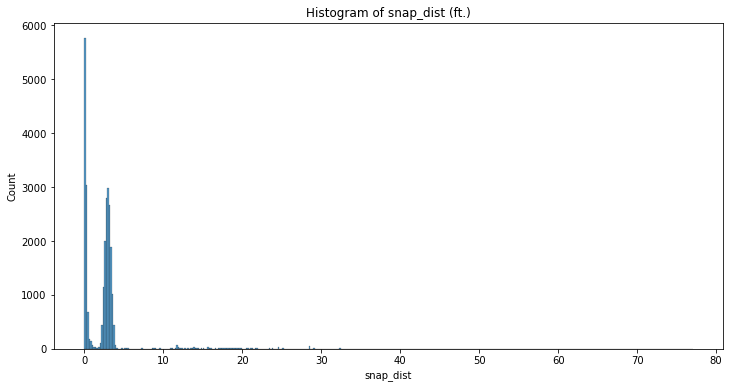

In [427]:
plt.figure(figsize=(12,6))

sns.histplot(updated_points.snap_dist)
plt.title('Histogram of snap_dist (ft.)')

In [428]:
updated_points.iloc[:, 30:45].head()

index_right ntacode county_fips                   ntaname      boro_name  \
0            122    SI35         085  New Brighton-Silver Lake  Staten Island   
66           122    SI35         085  New Brighton-Silver Lake  Staten Island   
83           122    SI35         085  New Brighton-Silver Lake  Staten Island   
185          122    SI35         085  New Brighton-Silver Lake  Staten Island   
537          122    SI35         085  New Brighton-Silver Lake  Staten Island   

    boro_code   line_i physicalid       st_label    st_name     full_stree  \
0           5  50283.0      63978   MORRISON AVE   MORRISON   MORRISON AVE   
66          5  53797.0      35045       BROADWAY   BROADWAY       BROADWAY   
83          5   7062.0      62901  DELAFIELD AVE  DELAFIELD  DELAFIELD AVE   
185         5  42827.0      63032   MORRISON AVE   MORRISON   MORRISON AVE   
537         5  50283.0      63978   MORRISON AVE   MORRISON   MORRISON AVE   

    rw_type rw_type_name st_width frm_lvl_co  
0         1       Street       30         13  
66        1       Street       30         13  
83        1       Street       30         13  
185       1       Street       30         13  
537       1       Street       30         13

In [429]:
updated_points.physicalid.value_counts()

76941     115
93488      91
44654      89
109590     81
23726      77
         ... 
93498       1
45952       1
59627       1
95170       1
59184       1
Name: physicalid, Length: 12812, dtype: int64

In [430]:
updated_points.physicalid.value_counts().index[0]

'76941'

In [431]:
top_street_id = updated_points.physicalid.value_counts().index[0]
print(top_street_id)

updated_points.loc[updated_points.physicalid == top_street_id].iloc[:, 30:45].head()

76941


index_right ntacode county_fips                 ntaname      boro_name  \
230           95    SI45         085  New Dorp-Midland Beach  Staten Island   
320           95    SI45         085  New Dorp-Midland Beach  Staten Island   
333           95    SI45         085  New Dorp-Midland Beach  Staten Island   
385           95    SI45         085  New Dorp-Midland Beach  Staten Island   
546           95    SI45         085  New Dorp-Midland Beach  Staten Island   

    boro_code   line_i physicalid    st_label  st_name  full_stree rw_type  \
230         5  19421.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
320         5  19421.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
333         5  19421.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
385         5  19421.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
546         5  19421.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   

    rw_type_name st_width frm_lvl_co  
230       Street       22         13  
320       Street       22         13  
333       Street       22         13  
385       Street       22         13  
546       Street       22         13

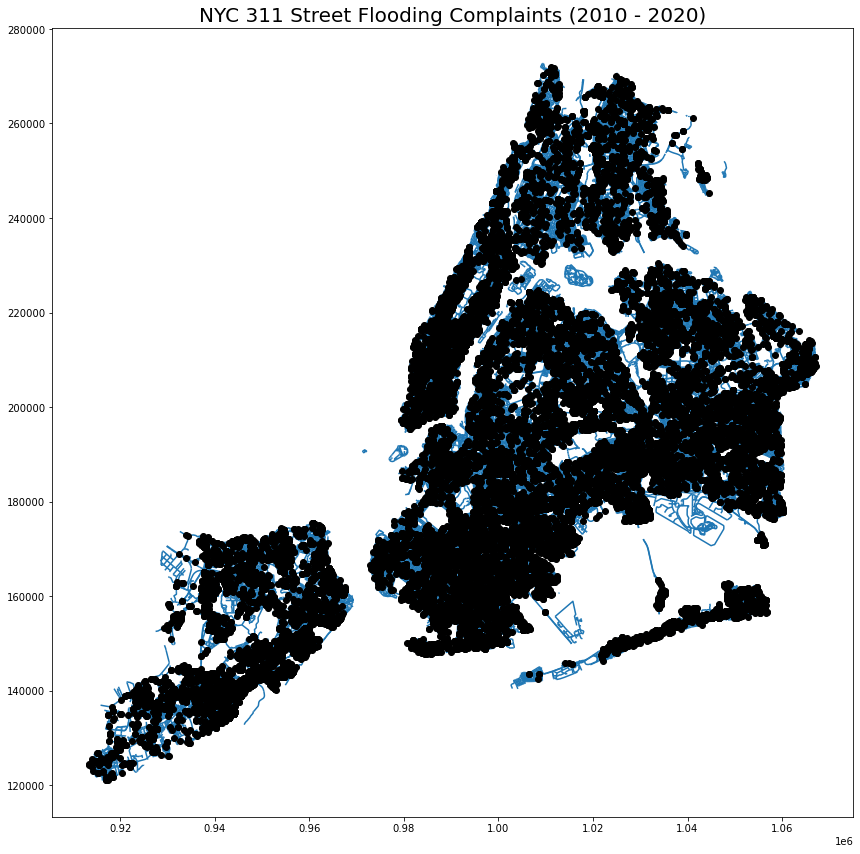

In [432]:
fig, ax = plt.subplots(figsize=(12, 12))

updated_points.plot(ax=ax, 
                    c='black')

streets.plot(ax=ax, 
             zorder=0)

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('NYC 311 Street Flooding Complaints (2010 - 2020)', 
             fontsize=20)

plt.tight_layout()

In [433]:
gdf_count = updated_points.groupby(by='physicalid')['created_date'].count().reset_index()

In [434]:
gdf_count.head()

physicalid  created_date
0     100002             2
1     100019             1
2     100020             1
3      10003             1
4      10004             2

In [435]:
gdf_count.rename(columns={"created_date": "count"}, inplace=True)

In [436]:
gdf_count.head()

physicalid  count
0     100002      2
1     100019      1
2     100020      1
3      10003      1
4      10004      2

In [437]:
streets[['geometry']].head()

geometry
0  LINESTRING (1047146.080 222733.432, 1047385.93...
1  LINESTRING (1009926.638 269075.549, 1010033.71...
2  LINESTRING (989292.818 189689.736, 989648.842 ...
3  LINESTRING (1031371.427 199453.863, 1031412.58...
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [438]:
streets.set_geometry('geometry', inplace=True)

In [439]:
streets.geom_type.value_counts()

LineString    99362
dtype: int64

In [440]:
streets['new_geom'] = streets.geometry.buffer(40, cap_style=2)

streets.set_geometry('new_geom', inplace=True)

In [441]:
streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  \
0  LINESTRING (1047146.080 222733.432, 1047385.93...   
1  LINESTRING (1009926.638 269075.549, 1010033.71...   
2  LINESTRING (989292.818 189689.736, 989648.842 ...   
3  LINESTRING (1031371.427 199453.863, 1031412.58...   
4  LINESTRING (940277.458 144141.538, 940027.193 ...   

                                            new_geom  
0  POLYGON ((1047370.887 222867.857, 1047400.976 ...  
1  POLYGON ((1009994.841 269527.116, 1010072.594 ...  
2  POLYGON ((989665.155 189566.793, 989865.462 18...  
3  POLYGON ((1031432.423 199465.095, 1031392.753 ...  
4  POLYGON ((940041.585 144007.708, 940012.801 14...

In [442]:
streets.geom_type.value_counts()

Polygon         99328
MultiPolygon       34
dtype: int64

In [443]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99362 entries, 0 to 99361
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99362 non-null  object  
 1   st_label      99362 non-null  object  
 2   st_name       99362 non-null  object  
 3   full_stree    99362 non-null  object  
 4   rw_type       99362 non-null  object  
 5   rw_type_name  99362 non-null  object  
 6   st_width      99362 non-null  object  
 7   frm_lvl_co    99362 non-null  object  
 8   to_lvl_co     99362 non-null  object  
 9   borocode      99362 non-null  object  
 10  shape_leng    99362 non-null  float64 
 11  geometry      99362 non-null  geometry
 12  new_geom      99362 non-null  geometry
dtypes: float64(1), geometry(2), object(10)
memory usage: 9.9+ MB


In [444]:
gdf_count.head()

physicalid  count
0     100002      2
1     100019      1
2     100020      1
3      10003      1
4      10004      2

In [445]:
gdf_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12812 entries, 0 to 12811
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   physicalid  12812 non-null  object
 1   count       12812 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 200.3+ KB


In [446]:
streets.shape

(99362, 13)

In [447]:
# joining our street data to our flood complaints data
streets_with_count = streets.merge(gdf_count, 
                                   left_on='physicalid', 
                                   right_on='physicalid', 
                                   how='left')

In [448]:
streets_with_count.shape

(99362, 14)

In [449]:
streets_with_count.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  \
0  LINESTRING (1047146.080 222733.432, 1047385.93...   
1  LINESTRING (1009926.638 269075.549, 1010033.71...   
2  LINESTRING (989292.818 189689.736, 989648.842 ...   
3  LINESTRING (1031371.427 199453.863, 1031412.58...   
4  LINESTRING (940277.458 144141.538, 940027.193 ...   

                                            new_geom  count  
0  POLYGON ((1047370.887 222867.857, 1047400.976 ...    NaN  
1  POLYGON ((1009994.841 269527.116, 1010072.594 ...    NaN  
2  POLYGON ((989665.155 189566.793, 989865.462 18...    NaN  
3  POLYGON ((1031432.423 199465.095, 1031392.753 ...    NaN  
4  POLYGON ((940041.585 144007.708, 940012.801 14...    NaN

In [450]:
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 99362 entries, 0 to 99361
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99362 non-null  object  
 1   st_label      99362 non-null  object  
 2   st_name       99362 non-null  object  
 3   full_stree    99362 non-null  object  
 4   rw_type       99362 non-null  object  
 5   rw_type_name  99362 non-null  object  
 6   st_width      99362 non-null  object  
 7   frm_lvl_co    99362 non-null  object  
 8   to_lvl_co     99362 non-null  object  
 9   borocode      99362 non-null  object  
 10  shape_leng    99362 non-null  float64 
 11  geometry      99362 non-null  geometry
 12  new_geom      99362 non-null  geometry
 13  count         12812 non-null  float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 11.4+ MB


In [451]:
streets_with_count.isna().sum()

physicalid          0
st_label            0
st_name             0
full_stree          0
rw_type             0
rw_type_name        0
st_width            0
frm_lvl_co          0
to_lvl_co           0
borocode            0
shape_leng          0
geometry            0
new_geom            0
count           86550
dtype: int64

In [452]:
streets_with_count['count'].fillna(0, inplace=True)

streets_with_count.isna().sum()

physicalid      0
st_label        0
st_name         0
full_stree      0
rw_type         0
rw_type_name    0
st_width        0
frm_lvl_co      0
to_lvl_co       0
borocode        0
shape_leng      0
geometry        0
new_geom        0
count           0
dtype: int64

In [453]:
streets_with_count.sort_values(by='count', ascending=False).head()

physicalid     st_label   st_name   full_stree rw_type rw_type_name  \
19421      76941   GRIMSBY ST   GRIMSBY   GRIMSBY ST       1       Street   
66852      93488       157 ST       157       157 ST       1       Street   
56685      44654      MILL RD      MILL      MILL RD       1       Street   
32081     109590  SAPPHIRE ST  SAPPHIRE  SAPPHIRE ST       1       Street   
75666      23726       141 ST       141       141 ST       1       Street   

      st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
19421       22         13        13        5  372.786118   
66852       35         13        13        4  499.592808   
56685       60         13        13        5  404.812891   
32081       22         13        13        3  554.170960   
75666       30         13        13        4  678.503925   

                                                geometry  \
19421  LINESTRING (958533.655 149022.834, 958315.338 ...   
66852  LINESTRING (1045395.099 182129.719, 1045149.50...   
56685  LINESTRING (952047.152 142027.684, 951841.926 ...   
32081  LINESTRING (1023855.973 183442.797, 1023962.32...   
75666  LINESTRING (1039008.353 188480.375, 1039246.94...   

                                                new_geom  count  
19421  POLYGON ((958347.761 148697.237, 958282.915 14...  115.0  
66852  POLYGON ((1045184.342 181674.994, 1045114.676 ...   91.0  
56685  POLYGON ((951876.405 141658.470, 951807.447 14...   89.0  
32081  POLYGON ((1024001.581 182906.603, 1023923.068 ...   81.0  
75666  POLYGON ((1039284.394 187859.272, 1039209.503 ...   77.0

In [454]:
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 99362 entries, 0 to 99361
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99362 non-null  object  
 1   st_label      99362 non-null  object  
 2   st_name       99362 non-null  object  
 3   full_stree    99362 non-null  object  
 4   rw_type       99362 non-null  object  
 5   rw_type_name  99362 non-null  object  
 6   st_width      99362 non-null  object  
 7   frm_lvl_co    99362 non-null  object  
 8   to_lvl_co     99362 non-null  object  
 9   borocode      99362 non-null  object  
 10  shape_leng    99362 non-null  float64 
 11  geometry      99362 non-null  geometry
 12  new_geom      99362 non-null  geometry
 13  count         99362 non-null  float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 11.4+ MB


In [455]:
streets_with_count[['count']].describe()

count
count  99362.000000
mean       0.270727
std        1.412780
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      115.000000

In [456]:
streets_with_count['shape_leng'] = streets_with_count.geometry.length

In [457]:
streets_with_count[['shape_leng']].describe()

shape_leng
count  99362.000000
mean     846.090161
std      523.759151
min      160.000000
25%      550.726302
50%      689.657945
75%     1076.346415
max    30346.427123

In [458]:
streets_with_count.describe()

shape_leng         count
count  99362.000000  99362.000000
mean     846.090161      0.270727
std      523.759151      1.412780
min      160.000000      0.000000
25%      550.726302      0.000000
50%      689.657945      0.000000
75%     1076.346415      0.000000
max    30346.427123    115.000000

In [459]:
streets_with_count['count_per_100ft'] = (streets_with_count['count'] / streets_with_count['shape_leng']) * 100

streets_with_count.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
0       Street       35         13        13        4   677.719481   
1       Street       42         13        13        2  1069.865843   
2       Street       50         13        13        3  1378.848749   
3       Street       40         13        13        4   254.798456   
4       Street       36         13        13        5   696.457501   

                                            geometry  \
0  LINESTRING (1047146.080 222733.432, 1047385.93...   
1  LINESTRING (1009926.638 269075.549, 1010033.71...   
2  LINESTRING (989292.818 189689.736, 989648.842 ...   
3  LINESTRING (1031371.427 199453.863, 1031412.58...   
4  LINESTRING (940277.458 144141.538, 940027.193 ...   

                                            new_geom  count  count_per_100ft  
0  POLYGON ((1047370.887 222867.857, 1047400.976 ...    0.0              0.0  
1  POLYGON ((1009994.841 269527.116, 1010072.594 ...    0.0              0.0  
2  POLYGON ((989665.155 189566.793, 989865.462 18...    0.0              0.0  
3  POLYGON ((1031432.423 199465.095, 1031392.753 ...    0.0              0.0  
4  POLYGON ((940041.585 144007.708, 940012.801 14...    0.0              0.0

In [460]:
streets_with_count[['count_per_100ft']].describe()

count_per_100ft
count     99362.000000
mean          0.032591
std           0.179636
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          14.704680

In [461]:
streets_with_count.sort_values(by='count_per_100ft', ascending=False).head()

physicalid            st_label   st_name   full_stree rw_type  \
10769     155472            W 228 ST       228    W  228 ST       1   
19421      76941          GRIMSBY ST   GRIMSBY   GRIMSBY ST       1   
97517     173312          LORING AVE    LORING   LORING AVE       1   
59879      17823  FRANCIS LEWIS BLVD     LEWIS   LEWIS BLVD       1   
63399     157023         SAPPHIRE ST  SAPPHIRE  SAPPHIRE ST       1   

      rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
10769       Street       44         13        13        1  183.615016   
19421       Street       22         13        13        5  905.572235   
97517       Street       30         13        13        3  643.111870   
59879       Street       20         13        13        4  650.977969   
63399       Street       20         13        13        3  587.358519   

                                                geometry  \
10769  LINESTRING (1009588.352 258326.086, 1009580.22...   
19421  LINESTRING (958533.655 149022.834, 958315.338 ...   
97517  LINESTRING (1023724.487 182856.704, 1023962.32...   
59879  LINESTRING (1056604.322 185833.195, 1056520.50...   
63399  LINESTRING (1023962.324 182898.926, 1024001.96...   

                                                new_geom  count  \
10769  POLYGON ((1009551.215 258307.106, 1009609.228 ...   27.0   
19421  POLYGON ((958347.761 148697.237, 958282.915 14...  115.0   
97517  POLYGON ((1023955.332 182938.311, 1023969.316 ...   72.0   
59879  POLYGON ((1056557.484 185614.763, 1056555.807 ...   62.0   
63399  POLYGON ((1024041.274 182696.378, 1023962.663 ...   54.0   

       count_per_100ft  
10769        14.704680  
19421        12.699153  
97517        11.195564  
59879         9.524132  
63399         9.193703

In [462]:
streets_with_count['count'].sum()

26900.0

In [463]:
streets_with_count.shape

(99362, 15)

# Joining streets to neighborhoods

In [464]:
updated_points.head()

unique_key             created_date              closed_date agency  \
0      45989680  2020-04-12T14:14:00.000  2020-04-13T08:10:00.000    DEP   
66     45188341  2019-12-18T08:20:00.000  2019-12-20T09:30:00.000    DEP   
83     46379956  2020-06-04T07:24:00.000  2020-06-04T14:40:00.000    DEP   
185    46122447  2020-05-03T13:25:00.000  2020-05-03T14:20:00.000    DEP   
537    24452089  2012-11-21T09:58:00.000  2012-11-22T09:30:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
66   Department of Environmental Protection          Sewer   
83   Department of Environmental Protection          Sewer   
185  Department of Environmental Protection          Sewer   
537  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       10310.0                   NaN   
66   Street Flooding (SJ)       10310.0              BROADWAY   
83   Street Flooding (SJ)       10310.0                   NaN   
185  Street Flooding (SJ)       10310.0                   NaN   
537  Street Flooding (SJ)       10310.0                   NaN   

    intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
0                     NaN  ...       1       Street       30         13   
66       DELAFIELD AVENUE  ...       1       Street       30         13   
83                    NaN  ...       1       Street       30         13   
185                   NaN  ...       1       Street       30         13   
537                   NaN  ...       1       Street       30         13   

    to_lvl_co borocode  shape_leng                       geometry  \
0          13        5  589.098755  POINT (952927.586 168314.708)   
66         13        5  338.316513  POINT (951911.891 169098.986)   
83         13        5  337.262021  POINT (954592.659 169519.181)   
185        13        5  239.356038  POINT (954094.604 168396.646)   
537        13        5  589.098755  POINT (952927.586 168314.708)   

                             point snap_dist  
0    POINT (952928.000 168312.000)  2.739228  
66   POINT (951912.000 169099.000)  0.109875  
83   POINT (954593.000 169517.000)  2.207330  
185  POINT (954095.000 168394.000)  2.675017  
537  POINT (952928.000 168312.000)  2.739228  

[5 rows x 51 columns]

In [465]:
updated_points.shape

(26900, 51)

In [466]:
updated_points.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'intersection_street_1',
       'intersection_street_2', 'address_type', 'city', 'status',
       'resolution_description', 'resolution_action_updated_date',
       'community_board', 'borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'latitude', 'longitude',
       'location', 'incident_address', 'street_name', 'cross_street_1',
       'cross_street_2', 'bbl', 'index_right', 'ntacode', 'county_fips',
       'ntaname', 'boro_name', 'boro_code', 'line_i', 'physicalid', 'st_label',
       'st_name', 'full_stree', 'rw_type', 'rw_type_name', 'st_width',
       'frm_lvl_co', 'to_lvl_co', 'borocode', 'shape_leng', 'geometry',
       'point', 'snap_dist'],
      dtype='object')

In [467]:
streets_with_nta = updated_points[['unique_key', 
                                   'ntacode', 
                                   'county_fips',
                                   'ntaname', 
                                   'boro_name', 
                                   'boro_code', 
                                   'shape_leng', 
                                   'physicalid']]

streets_with_nta.head()

unique_key ntacode county_fips                   ntaname      boro_name  \
0      45989680    SI35         085  New Brighton-Silver Lake  Staten Island   
66     45188341    SI35         085  New Brighton-Silver Lake  Staten Island   
83     46379956    SI35         085  New Brighton-Silver Lake  Staten Island   
185    46122447    SI35         085  New Brighton-Silver Lake  Staten Island   
537    24452089    SI35         085  New Brighton-Silver Lake  Staten Island   

    boro_code  shape_leng physicalid  
0           5  589.098755      63978  
66          5  338.316513      35045  
83          5  337.262021      62901  
185         5  239.356038      63032  
537         5  589.098755      63978

In [468]:
streets_with_nta.physicalid.value_counts()

76941     115
93488      91
44654      89
109590     81
23726      77
         ... 
93498       1
45952       1
59627       1
95170       1
59184       1
Name: physicalid, Length: 12812, dtype: int64

In [469]:
checking_for_duplicates = streets_with_nta.groupby(by=['physicalid', 
                                                       'ntaname', 
                                                       'boro_name'])['shape_leng'].count().reset_index()

checking_for_duplicates.head()

physicalid                  ntaname boro_name  shape_leng
0     100002           Queens Village    Queens           2
1     100019  Lindenwood-Howard Beach    Queens           1
2     100020  Lindenwood-Howard Beach    Queens           1
3      10003            East Elmhurst    Queens           1
4      10004            East Elmhurst    Queens           2

In [470]:
checking_for_duplicates.rename(columns={"shape_leng": "count_complaints"}, inplace=True)

checking_for_duplicates.head()

physicalid                  ntaname boro_name  count_complaints
0     100002           Queens Village    Queens                 2
1     100019  Lindenwood-Howard Beach    Queens                 1
2     100020  Lindenwood-Howard Beach    Queens                 1
3      10003            East Elmhurst    Queens                 1
4      10004            East Elmhurst    Queens                 2

In [471]:
checking_for_duplicates['physicalid'].is_unique

False

In [472]:
checking_for_duplicates[checking_for_duplicates.duplicated(subset=['physicalid'], 
                                                           keep=False) == True].sort_values(
                                                           by=['physicalid', 
                                                               'count_complaints'], 
                                                           ascending=False).head(10)

physicalid                               ntaname      boro_name  \
12482      97041                               Jamaica         Queens   
12481      97041               Briarwood-Jamaica Hills         Queens   
12329       9550                       Jackson Heights         Queens   
12330       9550                          North Corona         Queens   
12205      94540                          Borough Park       Brooklyn   
12206      94540              Kensington-Ocean Parkway       Brooklyn   
11976      93176                              Rosedale         Queens   
11977      93176  Springfield Gardens South-Brookville         Queens   
11333      88110                New Dorp-Midland Beach  Staten Island   
11334      88110                 Oakwood-Oakwood Beach  Staten Island   

       count_complaints  
12482                 2  
12481                 1  
12329                 1  
12330                 1  
12205                 2  
12206                 1  
11976                 1  
11977                 1  
11333                 2  
11334                 1

In [473]:
checking_for_duplicates[checking_for_duplicates.duplicated(subset=['physicalid'], 
                                                           keep=False) == True].sort_values(
                                                           by=['physicalid', 
                                                               'count_complaints'], 
                                                           ascending=[True, False]).head(10)

physicalid                      ntaname  boro_name  count_complaints
203     101556           Marble Hill-Inwood  Manhattan                 1
204     101556  park-cemetery-etc-Manhattan  Manhattan                 1
590      10779               Middle Village     Queens                 1
591      10779                    Ridgewood     Queens                 1
605     109590      Lindenwood-Howard Beach     Queens                56
604     109590                East New York   Brooklyn                25
645       1134                      Clinton  Manhattan                 5
646       1134        Midtown-Midtown South  Manhattan                 3
649       1138                      Clinton  Manhattan                 2
650       1138        Midtown-Midtown South  Manhattan                 1

In [474]:
checking_for_duplicates[checking_for_duplicates.duplicated(subset=['physicalid'], 
                                                           keep=False) == True].shape[0]

156

In [475]:
duplicates = (len(checking_for_duplicates[checking_for_duplicates.duplicated(subset=
                                                               ['physicalid'], 
                                                               keep=False) == True]) / len(streets_with_count) * 100)


round(duplicates, 2)

0.16

# There are 150 duplicates (.15% of total) of street segments to neighborhoods

In [476]:
checking_for_duplicates[checking_for_duplicates.physicalid == '109590'].sort_values(by=['physicalid', 
                                                                                        'count_complaints'], 
                                                                                   ascending=[True,
                                                                                              False])

physicalid                  ntaname boro_name  count_complaints
605     109590  Lindenwood-Howard Beach    Queens                56
604     109590            East New York  Brooklyn                25

# Sorting descending by number of complaints on a street in a given NTA. Then removing duplicates.

In [477]:
unique_streets = checking_for_duplicates.sort_values(by=['physicalid', 
                                                         'count_complaints'], 
                                                     ascending=[True, 
                                                                False]).drop_duplicates('physicalid')

In [478]:
unique_streets.head()

physicalid                  ntaname boro_name  count_complaints
0     100002           Queens Village    Queens                 2
1     100019  Lindenwood-Howard Beach    Queens                 1
2     100020  Lindenwood-Howard Beach    Queens                 1
3      10003            East Elmhurst    Queens                 1
4      10004            East Elmhurst    Queens                 2

In [479]:
unique_streets[unique_streets.physicalid == '109590']

physicalid                  ntaname boro_name  count_complaints
605     109590  Lindenwood-Howard Beach    Queens                56

In [480]:
unique_streets.physicalid.is_unique

True

In [481]:
streets_with_count.shape

(99362, 15)

In [482]:
# joining our nta population data to our nta shapes data
streets_with_count_nta = streets_with_count.merge(unique_streets, 
                                                  left_on='physicalid', 
                                                  right_on='physicalid', 
                                                  how='left')

streets_with_count_nta.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
0       Street       35         13        13        4   677.719481   
1       Street       42         13        13        2  1069.865843   
2       Street       50         13        13        3  1378.848749   
3       Street       40         13        13        4   254.798456   
4       Street       36         13        13        5   696.457501   

                                            geometry  \
0  LINESTRING (1047146.080 222733.432, 1047385.93...   
1  LINESTRING (1009926.638 269075.549, 1010033.71...   
2  LINESTRING (989292.818 189689.736, 989648.842 ...   
3  LINESTRING (1031371.427 199453.863, 1031412.58...   
4  LINESTRING (940277.458 144141.538, 940027.193 ...   

                                            new_geom  count  count_per_100ft  \
0  POLYGON ((1047370.887 222867.857, 1047400.976 ...    0.0              0.0   
1  POLYGON ((1009994.841 269527.116, 1010072.594 ...    0.0              0.0   
2  POLYGON ((989665.155 189566.793, 989865.462 18...    0.0              0.0   
3  POLYGON ((1031432.423 199465.095, 1031392.753 ...    0.0              0.0   
4  POLYGON ((940041.585 144007.708, 940012.801 14...    0.0              0.0   

  ntaname boro_name  count_complaints  
0     NaN       NaN               NaN  
1     NaN       NaN               NaN  
2     NaN       NaN               NaN  
3     NaN       NaN               NaN  
4     NaN       NaN               NaN

In [483]:
streets_with_count_nta.iloc[:, -3:].describe(include='all')

ntaname boro_name  count_complaints
count         12812     12812      12812.000000
unique          194         5               NaN
top     Great Kills    Queens               NaN
freq            221      4828               NaN
mean            NaN       NaN          2.089447
std             NaN       NaN          3.360679
min             NaN       NaN          1.000000
25%             NaN       NaN          1.000000
50%             NaN       NaN          1.000000
75%             NaN       NaN          2.000000
max             NaN       NaN        115.000000

In [484]:
streets_with_count_nta.sort_values(by='count', ascending=False).head()

physicalid     st_label   st_name   full_stree rw_type rw_type_name  \
19421      76941   GRIMSBY ST   GRIMSBY   GRIMSBY ST       1       Street   
66852      93488       157 ST       157       157 ST       1       Street   
56685      44654      MILL RD      MILL      MILL RD       1       Street   
32081     109590  SAPPHIRE ST  SAPPHIRE  SAPPHIRE ST       1       Street   
75666      23726       141 ST       141       141 ST       1       Street   

      st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
19421       22         13        13        5   905.572235   
66852       35         13        13        4  1159.185617   
56685       60         13        13        5   969.625782   
32081       22         13        13        3  1268.341920   
75666       30         13        13        4  1517.007849   

                                                geometry  \
19421  LINESTRING (958533.655 149022.834, 958315.338 ...   
66852  LINESTRING (1045395.099 182129.719, 1045149.50...   
56685  LINESTRING (952047.152 142027.684, 951841.926 ...   
32081  LINESTRING (1023855.973 183442.797, 1023962.32...   
75666  LINESTRING (1039008.353 188480.375, 1039246.94...   

                                                new_geom  count  \
19421  POLYGON ((958347.761 148697.237, 958282.915 14...  115.0   
66852  POLYGON ((1045184.342 181674.994, 1045114.676 ...   91.0   
56685  POLYGON ((951876.405 141658.470, 951807.447 14...   89.0   
32081  POLYGON ((1024001.581 182906.603, 1023923.068 ...   81.0   
75666  POLYGON ((1039284.394 187859.272, 1039209.503 ...   77.0   

       count_per_100ft                               ntaname      boro_name  \
19421        12.699153                New Dorp-Midland Beach  Staten Island   
66852         7.850339  Springfield Gardens South-Brookville         Queens   
56685         9.178799                 Oakwood-Oakwood Beach  Staten Island   
32081         6.386291               Lindenwood-Howard Beach         Queens   
75666         5.075781                          Baisley Park         Queens   

       count_complaints  
19421             115.0  
66852              91.0  
56685              89.0  
32081              56.0  
75666              77.0

In [485]:
streets_with_count_nta.shape

(99362, 18)

In [486]:
count_by_nta = streets_with_count_nta[['physicalid',
                                       'full_stree',
                                       'ntaname',
                                       'boro_name',
                                       'count',
                                       'count_per_100ft']]

In [487]:
count_by_nta.head()

physicalid       full_stree ntaname boro_name  count  count_per_100ft
0       6110           28 AVE     NaN       NaN    0.0              0.0
1      61140    ARLINGTON AVE     NaN       NaN    0.0              0.0
2     145494  SCHERMERHORN ST     NaN       NaN    0.0              0.0
3      12438      QUEENS BLVD     NaN       NaN    0.0              0.0
4      15432    ARTHUR KIL RD     NaN       NaN    0.0              0.0

In [488]:
count_by_nta.sort_values(by='count', ascending=False).head()

physicalid   full_stree                               ntaname  \
19421      76941   GRIMSBY ST                New Dorp-Midland Beach   
66852      93488       157 ST  Springfield Gardens South-Brookville   
56685      44654      MILL RD                 Oakwood-Oakwood Beach   
32081     109590  SAPPHIRE ST               Lindenwood-Howard Beach   
75666      23726       141 ST                          Baisley Park   

           boro_name  count  count_per_100ft  
19421  Staten Island  115.0        12.699153  
66852         Queens   91.0         7.850339  
56685  Staten Island   89.0         9.178799  
32081         Queens   81.0         6.386291  
75666         Queens   77.0         5.075781

In [489]:
count_by_nta.sort_values(by='count_per_100ft', ascending=False).head()

physicalid   full_stree                  ntaname      boro_name  count  \
10769     155472    W  228 ST       Marble Hill-Inwood      Manhattan   27.0   
19421      76941   GRIMSBY ST   New Dorp-Midland Beach  Staten Island  115.0   
97517     173312   LORING AVE            East New York       Brooklyn   72.0   
59879      17823   LEWIS BLVD                Laurelton         Queens   62.0   
63399     157023  SAPPHIRE ST  Lindenwood-Howard Beach         Queens   54.0   

       count_per_100ft  
10769        14.704680  
19421        12.699153  
97517        11.195564  
59879         9.524132  
63399         9.193703

In [490]:
count_by_nta.physicalid.is_unique

True

In [491]:
count_by_nta.describe()

count  count_per_100ft
count  99362.000000     99362.000000
mean       0.270727         0.032591
std        1.412780         0.179636
min        0.000000         0.000000
25%        0.000000         0.000000
50%        0.000000         0.000000
75%        0.000000         0.000000
max      115.000000        14.704680

# sanity check

In [492]:
streets_with_count.groupby(by=['physicalid',
                               'full_stree'])[[
                               'count', 
                               'count_per_100ft']].sum().reset_index().sort_values(
                                by='count', 
                                ascending=False).head()

physicalid   full_stree  count  count_per_100ft
78462      76941   GRIMSBY ST  115.0        12.699153
93384      93488       157 ST   91.0         7.850339
47817      44654      MILL RD   89.0         9.178799
5604      109590  SAPPHIRE ST   81.0         6.386291
27459      23726       141 ST   77.0         5.075781

In [493]:
streets_with_count.groupby(by=['physicalid',
                               'full_stree'])[[
                               'count', 
                               'count_per_100ft']].sum().reset_index().describe()

count  count_per_100ft
count  99362.000000     99362.000000
mean       0.270727         0.032591
std        1.412780         0.179636
min        0.000000         0.000000
25%        0.000000         0.000000
50%        0.000000         0.000000
75%        0.000000         0.000000
max      115.000000        14.704680

# adding nta information

In [494]:
count_by_nta['with_nta_name'] = count_by_nta['full_stree'] + ", " + count_by_nta['ntaname'] + ", " + count_by_nta['boro_name']

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [495]:
count_by_nta.sort_values(by='count', ascending=False).head()

physicalid   full_stree                               ntaname  \
19421      76941   GRIMSBY ST                New Dorp-Midland Beach   
66852      93488       157 ST  Springfield Gardens South-Brookville   
56685      44654      MILL RD                 Oakwood-Oakwood Beach   
32081     109590  SAPPHIRE ST               Lindenwood-Howard Beach   
75666      23726       141 ST                          Baisley Park   

           boro_name  count  count_per_100ft  \
19421  Staten Island  115.0        12.699153   
66852         Queens   91.0         7.850339   
56685  Staten Island   89.0         9.178799   
32081         Queens   81.0         6.386291   
75666         Queens   77.0         5.075781   

                                           with_nta_name  
19421  GRIMSBY ST, New Dorp-Midland Beach, Staten Island  
66852  157 ST, Springfield Gardens South-Brookville, ...  
56685      MILL RD, Oakwood-Oakwood Beach, Staten Island  
32081       SAPPHIRE ST, Lindenwood-Howard Beach, Queens  
75666                       141 ST, Baisley Park, Queens

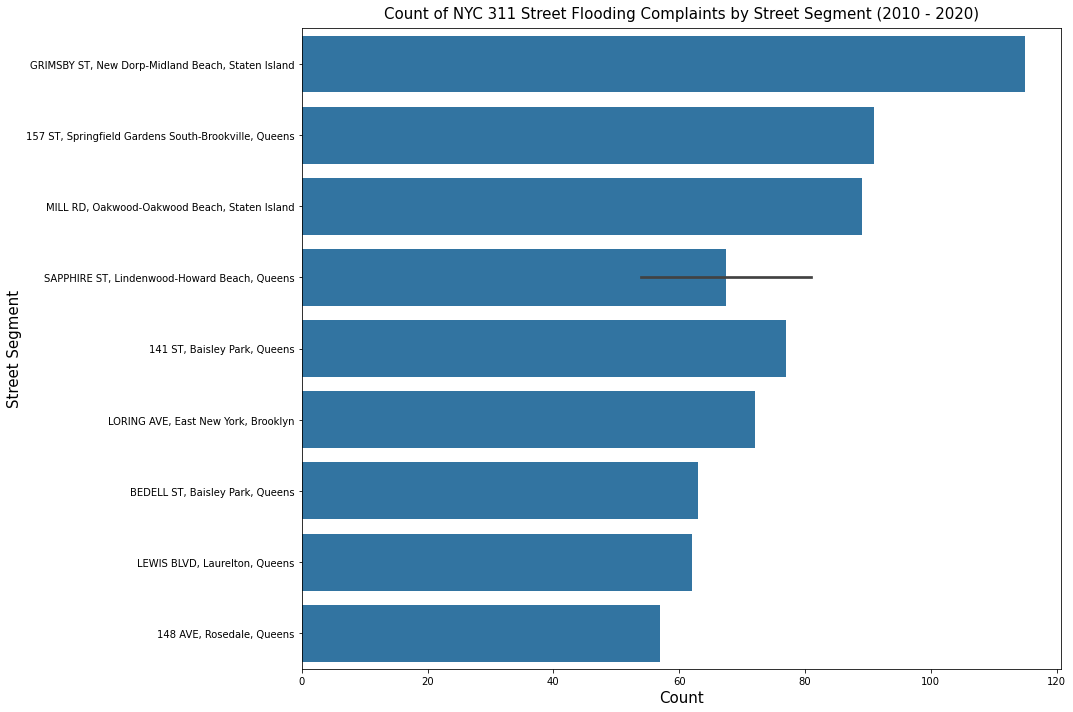

In [496]:
plt.figure(figsize=(15,10))

sns.barplot(data=count_by_nta.sort_values(by='count', ascending=False).head(10),
            y='with_nta_name',
            x='count',
            color='#1f77b4')

plt.title('Count of NYC 311 Street Flooding Complaints by Street Segment (2010 - 2020)', 
          fontsize=15,
          pad=10)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Street Segment', fontsize=15)
plt.tight_layout()

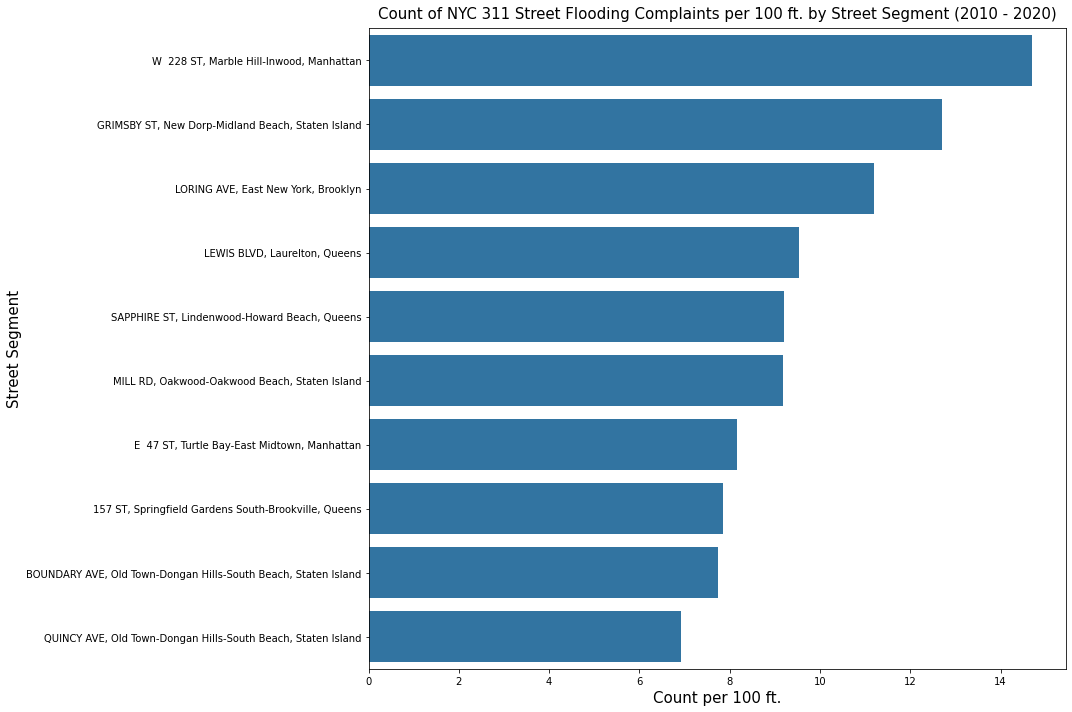

In [497]:
plt.figure(figsize=(15,10))

sns.barplot(data=count_by_nta.sort_values(by='count_per_100ft', ascending=False).head(10),
            y='with_nta_name',
            x='count_per_100ft',
            color='#1f77b4')

plt.title('Count of NYC 311 Street Flooding Complaints per 100 ft. by Street Segment (2010 - 2020)', 
          fontsize=15,
          pad=10)
plt.xlabel('Count per 100 ft.', fontsize=15)
plt.ylabel('Street Segment', fontsize=15)
plt.tight_layout()

plt.savefig('figures/count_per_length.png')

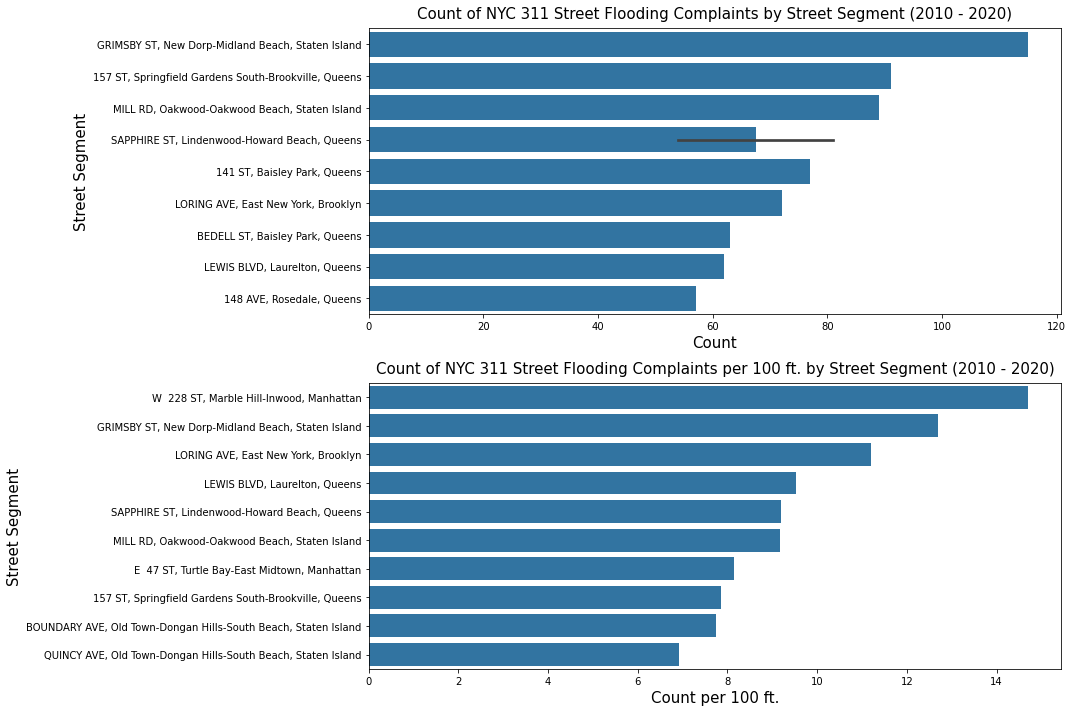

In [498]:
fig, axs = plt.subplots(2, 1, sharey=False, figsize=(15, 10))

# first plot
sns.barplot(data=count_by_nta.sort_values(by='count', ascending=False).head(10),
            y='with_nta_name',
            x='count',
            color='#1f77b4',
            ax=axs[0])

axs[0].set_title('Count of NYC 311 Street Flooding Complaints by Street Segment (2010 - 2020)', 
          fontsize=15,
          pad=10)
axs[0].set_xlabel('Count', fontsize=15)
axs[0].set_ylabel('Street Segment', fontsize=15)

# second plot
sns.barplot(data=count_by_nta.sort_values(by='count_per_100ft', ascending=False).head(10),
            y='with_nta_name',
            x='count_per_100ft',
            color='#1f77b4',
            ax=axs[1])

axs[1].set_title('Count of NYC 311 Street Flooding Complaints per 100 ft. by Street Segment (2010 - 2020)', 
          fontsize=15,
          pad=10)
axs[1].set_xlabel('Count per 100 ft.', fontsize=15)
axs[1].set_ylabel('Street Segment', fontsize=15)

plt.tight_layout()
# plt.savefig('figures/count_per_length.png')

In [499]:
count_by_nta.to_csv('data-output/streets-with-count.csv', index=False)

## Case Studies

## 1) Hammels, Arverne, and Edgemere, Queens and 2) New Dorp - Midland Beach, Staten Island

In [500]:
top_nta = gpd.GeoDataFrame(flooding_311, 
                           geometry=gpd.points_from_xy(flooding_311.x_coordinate_state_plane, 
                                                       flooding_311.y_coordinate_state_plane))

top_nta.head()

unique_key             created_date              closed_date agency  \
0    45989680  2020-04-12T14:14:00.000  2020-04-13T08:10:00.000    DEP   
1    45178597  2019-12-16T07:48:00.000  2020-01-16T13:35:00.000    DEP   
2    47428465  2020-09-01T09:58:00.000  2020-09-01T18:05:00.000    DEP   
3    48133312  2020-11-12T16:23:00.000  2020-11-13T14:10:00.000    DEP   
4    48135671  2020-11-12T14:19:00.000  2020-11-16T08:35:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)       10310.0                   NaN   
1  Street Flooding (SJ)       11207.0       WILLIAMS AVENUE   
2  Street Flooding (SJ)       11001.0                   NaN   
3  Street Flooding (SJ)       11236.0                   NaN   
4  Street Flooding (SJ)       11208.0       SAPPHIRE STREET   

  intersection_street_2  ...   park_borough   latitude  longitude  \
0                   NaN  ...  STATEN ISLAND  40.628599 -74.112841   
1  EAST NEW YORK AVENUE  ...       BROOKLYN  40.676574 -73.900793   
2                   NaN  ...         QUEENS  40.737833 -73.703547   
3                   NaN  ...       BROOKLYN  40.629816 -73.900300   
4         LORING AVENUE  ...       BROOKLYN  40.668603 -73.856848   

                                            location     incident_address  \
0  {'latitude': '40.6285987', 'longitude': '-74.1...  204 MORRISON AVENUE   
1  {'latitude': '40.6765736', 'longitude': '-73.9...                  NaN   
2  {'latitude': '40.737832829634904', 'longitude'...     84-17 265 STREET   
3  {'latitude': '40.62981582525854', 'longitude':...        8518 AVENUE N   
4  {'latitude': '40.66860317832641', 'longitude':...                  NaN   

       street_name cross_street_1   cross_street_2           bbl  \
0  MORRISON AVENUE     BEMENT AVE    N BURGHER AVE  5.003000e+09   
1              NaN            NaN              NaN           NaN   
2       265 STREET   HILLSIDE AVE  E WILLISTON AVE  4.087950e+09   
3         AVENUE N        E 85 ST          E 86 ST  3.080820e+09   
4              NaN            NaN              NaN           NaN   

                         geometry  
0   POINT (952928.000 168312.000)  
1  POINT (1011768.000 185786.000)  
2  POINT (1066404.000 208228.000)  
3  POINT (1011924.000 168751.000)  
4  POINT (1023962.000 182899.000)  

[5 rows x 31 columns]

In [501]:
top_nta.set_crs(epsg=2263, inplace=True)
top_nta.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

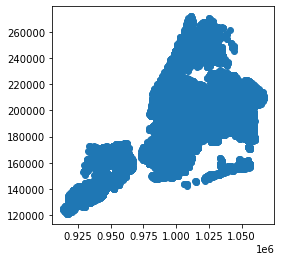

In [502]:
top_nta.plot()

In [503]:
gdf.shape

(26960, 36)

In [504]:
top_nta = gpd.sjoin(top_nta, 
                    nta_shape, 
                    how="inner", 
                    op='within')

In [505]:
top_nta.head()

unique_key             created_date              closed_date agency  \
0      45989680  2020-04-12T14:14:00.000  2020-04-13T08:10:00.000    DEP   
66     45188341  2019-12-18T08:20:00.000  2019-12-20T09:30:00.000    DEP   
83     46379956  2020-06-04T07:24:00.000  2020-06-04T14:40:00.000    DEP   
185    46122447  2020-05-03T13:25:00.000  2020-05-03T14:20:00.000    DEP   
537    24452089  2012-11-21T09:58:00.000  2012-11-22T09:30:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
66   Department of Environmental Protection          Sewer   
83   Department of Environmental Protection          Sewer   
185  Department of Environmental Protection          Sewer   
537  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       10310.0                   NaN   
66   Street Flooding (SJ)       10310.0              BROADWAY   
83   Street Flooding (SJ)       10310.0                   NaN   
185  Street Flooding (SJ)       10310.0                   NaN   
537  Street Flooding (SJ)       10310.0                   NaN   

    intersection_street_2  ...           bbl                       geometry  \
0                     NaN  ...  5.003000e+09  POINT (952928.000 168312.000)   
66       DELAFIELD AVENUE  ...           NaN  POINT (951912.000 169099.000)   
83                    NaN  ...  5.001470e+09  POINT (954593.000 169517.000)   
185                   NaN  ...  5.002840e+09  POINT (954095.000 168394.000)   
537                   NaN  ...  5.003000e+09  POINT (952928.000 168312.000)   

    index_right ntacode     shape_area county_fips                   ntaname  \
0           122    SI35  47137243.9922         085  New Brighton-Silver Lake   
66          122    SI35  47137243.9922         085  New Brighton-Silver Lake   
83          122    SI35  47137243.9922         085  New Brighton-Silver Lake   
185         122    SI35  47137243.9922         085  New Brighton-Silver Lake   
537         122    SI35  47137243.9922         085  New Brighton-Silver Lake   

        shape_leng      boro_name boro_code  
0    30320.3749453  Staten Island         5  
66   30320.3749453  Staten Island         5  
83   30320.3749453  Staten Island         5  
185  30320.3749453  Staten Island         5  
537  30320.3749453  Staten Island         5  

[5 rows x 39 columns]

# Neighborhoods with the most street flooding complaints

In [506]:
top_nta.groupby(by='ntaname')['unique_key'].count().reset_index().sort_values('unique_key', ascending=False).head(2)

ntaname  unique_key
116    New Dorp-Midland Beach         763
80   Hammels-Arverne-Edgemere         697

## Hammels, Arverne, and Edgemere, Queens

In [507]:
gdf = gpd.GeoDataFrame(flooding_311, 
                       geometry=gpd.points_from_xy(flooding_311.x_coordinate_state_plane, 
                                                   flooding_311.y_coordinate_state_plane))

In [508]:
gdf.head()

unique_key             created_date              closed_date agency  \
0    45989680  2020-04-12T14:14:00.000  2020-04-13T08:10:00.000    DEP   
1    45178597  2019-12-16T07:48:00.000  2020-01-16T13:35:00.000    DEP   
2    47428465  2020-09-01T09:58:00.000  2020-09-01T18:05:00.000    DEP   
3    48133312  2020-11-12T16:23:00.000  2020-11-13T14:10:00.000    DEP   
4    48135671  2020-11-12T14:19:00.000  2020-11-16T08:35:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)       10310.0                   NaN   
1  Street Flooding (SJ)       11207.0       WILLIAMS AVENUE   
2  Street Flooding (SJ)       11001.0                   NaN   
3  Street Flooding (SJ)       11236.0                   NaN   
4  Street Flooding (SJ)       11208.0       SAPPHIRE STREET   

  intersection_street_2  ...   park_borough   latitude  longitude  \
0                   NaN  ...  STATEN ISLAND  40.628599 -74.112841   
1  EAST NEW YORK AVENUE  ...       BROOKLYN  40.676574 -73.900793   
2                   NaN  ...         QUEENS  40.737833 -73.703547   
3                   NaN  ...       BROOKLYN  40.629816 -73.900300   
4         LORING AVENUE  ...       BROOKLYN  40.668603 -73.856848   

                                            location     incident_address  \
0  {'latitude': '40.6285987', 'longitude': '-74.1...  204 MORRISON AVENUE   
1  {'latitude': '40.6765736', 'longitude': '-73.9...                  NaN   
2  {'latitude': '40.737832829634904', 'longitude'...     84-17 265 STREET   
3  {'latitude': '40.62981582525854', 'longitude':...        8518 AVENUE N   
4  {'latitude': '40.66860317832641', 'longitude':...                  NaN   

       street_name cross_street_1   cross_street_2           bbl  \
0  MORRISON AVENUE     BEMENT AVE    N BURGHER AVE  5.003000e+09   
1              NaN            NaN              NaN           NaN   
2       265 STREET   HILLSIDE AVE  E WILLISTON AVE  4.087950e+09   
3         AVENUE N        E 85 ST          E 86 ST  3.080820e+09   
4              NaN            NaN              NaN           NaN   

                         geometry  
0   POINT (952928.000 168312.000)  
1  POINT (1011768.000 185786.000)  
2  POINT (1066404.000 208228.000)  
3  POINT (1011924.000 168751.000)  
4  POINT (1023962.000 182899.000)  

[5 rows x 31 columns]

In [509]:
gdf.set_crs(epsg=2263, inplace=True)
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

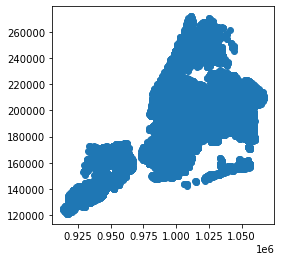

In [510]:
gdf.plot()

In [511]:
gdf.shape

(26962, 31)

In [512]:
gdf = gpd.sjoin(gdf, 
                nta_shape, 
                how="inner", 
                op='within')

In [513]:
gdf.head()

unique_key             created_date              closed_date agency  \
0      45989680  2020-04-12T14:14:00.000  2020-04-13T08:10:00.000    DEP   
66     45188341  2019-12-18T08:20:00.000  2019-12-20T09:30:00.000    DEP   
83     46379956  2020-06-04T07:24:00.000  2020-06-04T14:40:00.000    DEP   
185    46122447  2020-05-03T13:25:00.000  2020-05-03T14:20:00.000    DEP   
537    24452089  2012-11-21T09:58:00.000  2012-11-22T09:30:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
66   Department of Environmental Protection          Sewer   
83   Department of Environmental Protection          Sewer   
185  Department of Environmental Protection          Sewer   
537  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       10310.0                   NaN   
66   Street Flooding (SJ)       10310.0              BROADWAY   
83   Street Flooding (SJ)       10310.0                   NaN   
185  Street Flooding (SJ)       10310.0                   NaN   
537  Street Flooding (SJ)       10310.0                   NaN   

    intersection_street_2  ...           bbl                       geometry  \
0                     NaN  ...  5.003000e+09  POINT (952928.000 168312.000)   
66       DELAFIELD AVENUE  ...           NaN  POINT (951912.000 169099.000)   
83                    NaN  ...  5.001470e+09  POINT (954593.000 169517.000)   
185                   NaN  ...  5.002840e+09  POINT (954095.000 168394.000)   
537                   NaN  ...  5.003000e+09  POINT (952928.000 168312.000)   

    index_right ntacode     shape_area county_fips                   ntaname  \
0           122    SI35  47137243.9922         085  New Brighton-Silver Lake   
66          122    SI35  47137243.9922         085  New Brighton-Silver Lake   
83          122    SI35  47137243.9922         085  New Brighton-Silver Lake   
185         122    SI35  47137243.9922         085  New Brighton-Silver Lake   
537         122    SI35  47137243.9922         085  New Brighton-Silver Lake   

        shape_leng      boro_name boro_code  
0    30320.3749453  Staten Island         5  
66   30320.3749453  Staten Island         5  
83   30320.3749453  Staten Island         5  
185  30320.3749453  Staten Island         5  
537  30320.3749453  Staten Island         5  

[5 rows x 39 columns]

In [514]:
gdf.drop(columns=["shape_leng", 'shape_area'], inplace=True)

In [515]:
ls data-raw/

raw-street-flooding-data.csv  raw-streets-clipped.json


In [516]:
path = 'data-raw/raw-streets-clipped.json'
streets = gpd.read_file(path)

streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  
0  LINESTRING (1047146.080 222733.432, 1047385.93...  
1  LINESTRING (1009926.638 269075.549, 1010033.71...  
2  LINESTRING (989292.818 189689.736, 989648.842 ...  
3  LINESTRING (1031371.427 199453.863, 1031412.58...  
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [517]:
streets.shape

(99362, 12)

<AxesSubplot:>

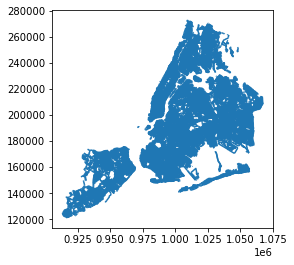

In [518]:
streets.plot()

In [519]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99362 entries, 0 to 99361
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99362 non-null  object  
 1   st_label      99362 non-null  object  
 2   st_name       99362 non-null  object  
 3   full_stree    99362 non-null  object  
 4   rw_type       99362 non-null  object  
 5   rw_type_name  99362 non-null  object  
 6   st_width      99362 non-null  object  
 7   frm_lvl_co    99362 non-null  object  
 8   to_lvl_co     99362 non-null  object  
 9   borocode      99362 non-null  object  
 10  shape_leng    99362 non-null  float64 
 11  geometry      99362 non-null  geometry
dtypes: float64(1), geometry(1), object(10)
memory usage: 9.1+ MB


In [520]:
streets.describe()

shape_leng
count  9.936200e+04
mean   3.431188e+02
std    2.620211e+02
min    1.068681e-08
25%    1.953735e+02
50%    2.648459e+02
75%    4.583545e+02
max    1.509366e+04

In [521]:
streets.geom_type.value_counts()

LineString    99362
dtype: int64

In [522]:
streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  
0  LINESTRING (1047146.080 222733.432, 1047385.93...  
1  LINESTRING (1009926.638 269075.549, 1010033.71...  
2  LINESTRING (989292.818 189689.736, 989648.842 ...  
3  LINESTRING (1031371.427 199453.863, 1031412.58...  
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [523]:
Hammels_Arverne_Edgemere = nta_shape[nta_shape.ntaname == 'Hammels-Arverne-Edgemere']

In [524]:
# clipping the school points that only fall within the nta shapes
streets_clipped = gpd.clip(streets, Hammels_Arverne_Edgemere)

<AxesSubplot:>

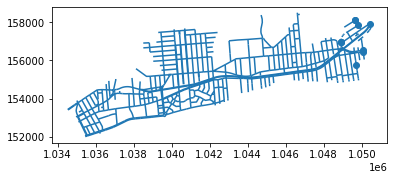

In [525]:
streets_clipped.plot()

In [526]:
streets_clipped.geom_type.value_counts()

LineString            843
Point                   9
MultiLineString         2
GeometryCollection      1
dtype: int64

In [527]:
streets_clipped = streets_clipped[streets_clipped.geom_type == 'LineString']

streets_clipped.geom_type.value_counts()

LineString    843
dtype: int64

In [528]:
# clipping the school points that only fall within the nta shapes
Hammels_Arverne_Edgemere = gpd.clip(gdf, 
                                    Hammels_Arverne_Edgemere)

<AxesSubplot:>

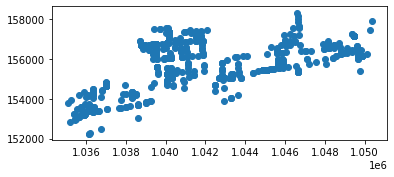

In [529]:
Hammels_Arverne_Edgemere.plot()

In [530]:
Hammels_Arverne_Edgemere.geom_type.value_counts()

Point    697
dtype: int64

# Snap points to streets

# https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa

In [531]:
streets_clipped.sindex

rtree.index.Index(bounds=[1034529.2977429869, 151996.05628808722, 1050540.0391240292, 158513.33282463337], size=843)

In [532]:
offset = 80

bbox = Hammels_Arverne_Edgemere.bounds + [-offset, -offset, offset, offset]

bbox.head()

minx      miny       maxx      maxy
32   1041800.0  156846.0  1041960.0  157006.0
138  1040811.0  154842.0  1040971.0  155002.0
251  1039314.0  154728.0  1039474.0  154888.0
280  1041441.0  157121.0  1041601.0  157281.0
332  1043228.0  155185.0  1043388.0  155345.0

In [533]:
hits = bbox.apply(lambda row: list(streets_clipped.sindex.intersection(row)), axis=1)

hits.head()

32     [162, 391, 805, 428]
138         [531, 563, 642]
251                   [754]
280                   [192]
332         [779, 124, 499]
dtype: object

In [534]:
hits.shape

(697,)

In [535]:
tmp = pd.DataFrame(
    {
    # index of points table
    "pt_idx": np.repeat(hits.index, hits.apply(len)),
        
    # ordinal position of line - access via iloc later
    "line_i": np.concatenate(hits.values)
    })

In [536]:
tmp.head()

pt_idx  line_i
0      32   162.0
1      32   391.0
2      32   805.0
3      32   428.0
4     138   531.0

In [537]:
tmp.shape

(2142, 2)

In [538]:
streets_clipped.shape

(843, 12)

In [539]:
streets_clipped.head()

physicalid             st_label         st_name          full_stree  \
41        92035            BCH 66 ST            B 66             B 66 ST   
252       14294            BCH 74 ST            B 74             B 74 ST   
347       14034  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE   
506      154483  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE   
1016      92062            BCH 87 ST            B 87             B 87 ST   

     rw_type rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
41         1       Street       42         13        13        4  495.233090   
252        1       Street       30         13        13        4  623.015421   
347        1       Street       35         13        13        4  234.071915   
506        1       Street       31         13        13        4  255.930554   
1016       1       Street       24         13        13        4  186.284190   

                                               geometry  
41    LINESTRING (1041022.181 156864.681, 1040981.69...  
252   LINESTRING (1039173.301 154571.323, 1039121.22...  
347   LINESTRING (1046371.747 155628.532, 1046139.47...  
506   LINESTRING (1041944.905 154892.163, 1041702.46...  
1016  LINESTRING (1036423.096 153354.452, 1036408.71...

In [540]:
# Join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(streets_clipped.reset_index(drop=True), 
               on="line_i")

tmp.head()

pt_idx  line_i physicalid      st_label   st_name    full_stree rw_type  \
0      32   162.0     104187     BCH 63 ST      B 63       B 63 ST       1   
1      32   391.0      14108    ALMEDA AVE    ALMEDA    ALMEDA AVE       1   
2      32   805.0     180494    ALMEDA AVE    ALMEDA    ALMEDA AVE       1   
3      32   428.0     187406     BCH 63 ST      B 63       B 63 ST       1   
4     138   531.0     168877  ROCKAWAY FWY  ROCKAWAY  ROCKAWAY FWY       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
0       Street       30         13        13        4   243.030781   
1       Street       30         13        13        4   260.169165   
2       Street       30         13        13        4   410.827589   
3       Street       30         13        13        4   261.413990   
4       Street       25         13        13        4  1333.730517   

                                            geometry  
0  LINESTRING (1041827.281 156681.854, 1041806.59...  
1  LINESTRING (1041806.592 156924.002, 1041546.95...  
2  LINESTRING (1042216.457 156952.114, 1041806.59...  
3  LINESTRING (1041806.592 156924.002, 1041785.33...  
4  LINESTRING (1042194.695 155052.537, 1042094.66...

In [541]:
# Join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(Hammels_Arverne_Edgemere.geometry.rename("point"), 
               on="pt_idx")

# Convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(tmp, 
                       geometry="geometry", 
                       crs=Hammels_Arverne_Edgemere.crs)

In [542]:
tmp.head()

pt_idx  line_i physicalid      st_label   st_name    full_stree rw_type  \
0      32   162.0     104187     BCH 63 ST      B 63       B 63 ST       1   
1      32   391.0      14108    ALMEDA AVE    ALMEDA    ALMEDA AVE       1   
2      32   805.0     180494    ALMEDA AVE    ALMEDA    ALMEDA AVE       1   
3      32   428.0     187406     BCH 63 ST      B 63       B 63 ST       1   
4     138   531.0     168877  ROCKAWAY FWY  ROCKAWAY  ROCKAWAY FWY       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
0       Street       30         13        13        4   243.030781   
1       Street       30         13        13        4   260.169165   
2       Street       30         13        13        4   410.827589   
3       Street       30         13        13        4   261.413990   
4       Street       25         13        13        4  1333.730517   

                                            geometry  \
0  LINESTRING (1041827.281 156681.854, 1041806.59...   
1  LINESTRING (1041806.592 156924.002, 1041546.95...   
2  LINESTRING (1042216.457 156952.114, 1041806.59...   
3  LINESTRING (1041806.592 156924.002, 1041785.33...   
4  LINESTRING (1042194.695 155052.537, 1042094.66...   

                            point  
0  POINT (1041880.000 156926.000)  
1  POINT (1041880.000 156926.000)  
2  POINT (1041880.000 156926.000)  
3  POINT (1041880.000 156926.000)  
4  POINT (1040891.000 154922.000)

In [543]:
tmp["snap_dist"] = tmp.geometry.distance(gpd.GeoSeries(tmp.point))

tmp[['snap_dist']].describe()

snap_dist
count  2142.000000
mean     32.946520
std      49.767853
min       0.004010
25%       0.491634
50%       7.228186
75%      57.581843
max     377.414126

In [544]:
# Discard any lines that are greater than tolerance from points
tmp = tmp.loc[tmp.snap_dist <= offset]

# Sort on ascending snap distance, so that closest goes to top
tmp = tmp.sort_values(by=["snap_dist"])

tmp.head()

pt_idx  line_i physicalid        st_label  st_name      full_stree  \
1267   16521   312.0      14365  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR   
1079   12953   413.0      80917       BCH 48 ST       48       BCH 48 ST   
521     7538   413.0      80917       BCH 48 ST       48       BCH 48 ST   
830    11845   413.0      80917       BCH 48 ST       48       BCH 48 ST   
924    12800   334.0      14195  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR   

     rw_type rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
1267       1       Street       50         13        13        4  261.689492   
1079       1       Street       30         13        13        4  570.432126   
521        1       Street       30         13        13        4  570.432126   
830        1       Street       30         13        13        4  570.432126   
924        1       Street       52         13        13        4  308.269676   

                                               geometry  \
1267  LINESTRING (1043336.353 156058.630, 1043104.72...   
1079  LINESTRING (1045615.013 156289.929, 1045564.12...   
521   LINESTRING (1045615.013 156289.929, 1045564.12...   
830   LINESTRING (1045615.013 156289.929, 1045564.12...   
924   LINESTRING (1038297.735 154234.529, 1037989.55...   

                               point  snap_dist  
1267  POINT (1043105.000 155937.000)   0.004010  
1079  POINT (1045615.000 156290.000)   0.006761  
521   POINT (1045615.000 156290.000)   0.006761  
830   POINT (1045615.000 156290.000)   0.006761  
924   POINT (1037990.000 154242.000)   0.011789

In [545]:
tmp[['snap_dist']].describe()

snap_dist
count  1847.000000
mean     17.006823
std      23.912002
min       0.004010
25%       0.446798
50%       3.185749
75%      21.744168
max      78.864107

In [546]:
# group by the index of the points and take the first, which is the closest line 
closest = tmp.groupby("pt_idx").first()

# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")

closest.head()

line_i physicalid      st_label  st_name    full_stree rw_type  \
pt_idx                                                                   
32       805.0     180494    ALMEDA AVE   ALMEDA    ALMEDA AVE       1   
138      642.0     168839     BCH 67 ST     B 67       B 67 ST       1   
251      754.0      78832     BCH 73 ST     B 73       B 73 ST       1   
280      192.0     104183     BCH 64 ST     B 64       B 64 ST       1   
332      124.0      14425  ARVERNE BLVD  ARVERNE  ARVERNE BLVD       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
32           Street       30         13        13        4  410.827589   
138          Street       50         13        13        4  625.792520   
251          Street       35         13        13        4  611.384594   
280          Street       30         13        13        4  494.619832   
332          Street       52         13        13        4  588.693377   

                                                 geometry  \
pt_idx                                                      
32      LINESTRING (1042216.457 156952.114, 1041806.59...   
138     LINESTRING (1040914.349 154708.860, 1040863.51...   
251     LINESTRING (1039414.311 154603.511, 1039363.23...   
280     LINESTRING (1041546.957 156907.342, 1041508.70...   
332     LINESTRING (1043403.728 155232.378, 1043293.96...   

                                 point  snap_dist  
pt_idx                                             
32      POINT (1041880.000 156926.000)   3.030039  
138     POINT (1040891.000 154922.000)   5.958893  
251     POINT (1039394.000 154808.000)   3.156324  
280     POINT (1041521.000 157201.000)   3.171494  
332     POINT (1043308.000 155265.000)   3.874020

In [547]:
# Position of nearest point from start of the line
pos = closest.geometry.project(gpd.GeoSeries(closest.point))

# Get new point location geometry
new_pts = closest.geometry.interpolate(pos)

new_pts.head()

pt_idx
32     POINT (1041879.793 156929.023)
138    POINT (1040896.939 154922.484)
251    POINT (1039397.145 154808.264)
280    POINT (1041524.162 157201.245)
332    POINT (1043309.389 155268.616)
dtype: geometry

In [548]:
# Create a new GeoDataFrame from the columns from the closest line and 
# new point geometries (which will be called "geometries")
snapped = gpd.GeoDataFrame(closest, 
                           geometry=new_pts)

snapped.head()

line_i physicalid      st_label  st_name    full_stree rw_type  \
pt_idx                                                                   
32       805.0     180494    ALMEDA AVE   ALMEDA    ALMEDA AVE       1   
138      642.0     168839     BCH 67 ST     B 67       B 67 ST       1   
251      754.0      78832     BCH 73 ST     B 73       B 73 ST       1   
280      192.0     104183     BCH 64 ST     B 64       B 64 ST       1   
332      124.0      14425  ARVERNE BLVD  ARVERNE  ARVERNE BLVD       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
32           Street       30         13        13        4  410.827589   
138          Street       50         13        13        4  625.792520   
251          Street       35         13        13        4  611.384594   
280          Street       30         13        13        4  494.619832   
332          Street       52         13        13        4  588.693377   

                              geometry                           point  \
pt_idx                                                                   
32      POINT (1041879.793 156929.023)  POINT (1041880.000 156926.000)   
138     POINT (1040896.939 154922.484)  POINT (1040891.000 154922.000)   
251     POINT (1039397.145 154808.264)  POINT (1039394.000 154808.000)   
280     POINT (1041524.162 157201.245)  POINT (1041521.000 157201.000)   
332     POINT (1043309.389 155268.616)  POINT (1043308.000 155265.000)   

        snap_dist  
pt_idx             
32       3.030039  
138      5.958893  
251      3.156324  
280      3.171494  
332      3.874020

In [549]:
Hammels_Arverne_Edgemere.head()

unique_key             created_date              closed_date agency  \
32     45180730  2019-12-17T10:31:00.000  2019-12-18T11:25:00.000    DEP   
138    20254948  2011-04-17T10:01:00.000  2011-04-18T11:00:00.000    DEP   
251    47389589  2020-08-28T19:12:00.000  2020-08-28T21:45:00.000    DEP   
280    47392363  2020-08-28T10:29:00.000  2020-08-28T14:40:00.000    DEP   
332    47445061  2020-09-02T19:46:00.000  2020-09-06T11:20:00.000    DEP   

                                agency_name complaint_type  \
32   Department of Environmental Protection          Sewer   
138  Department of Environmental Protection          Sewer   
251  Department of Environmental Protection          Sewer   
280  Department of Environmental Protection          Sewer   
332  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
32   Street Flooding (SJ)       11692.0                   NaN   
138  Street Flooding (SJ)       11692.0                   NaN   
251  Street Flooding (SJ)       11692.0                   NaN   
280  Street Flooding (SJ)       11692.0                   NaN   
332  Street Flooding (SJ)       11692.0                   NaN   

    intersection_street_2  ...               cross_street_1    cross_street_2  \
32                    NaN  ...  SOMMERVILLE BASIN SHORELINE       BEACH 63 ST   
138                   NaN  ...             ROCKAWAY FREEWAY  BEACH CHANNEL DR   
251                   NaN  ...             BEACH CHANNEL DR       AMSTEL BLVD   
280                   NaN  ...                   ALMEDA AVE      DE COSTA AVE   
332                   NaN  ...                  BEACH 57 ST       BEACH 59 ST   

              bbl                        geometry index_right ntacode  \
32   4.160070e+09  POINT (1041880.000 156926.000)         131    QN12   
138  4.159130e+09  POINT (1040891.000 154922.000)         131    QN12   
251  4.160780e+09  POINT (1039394.000 154808.000)         131    QN12   
280  4.160240e+09  POINT (1041521.000 157201.000)         131    QN12   
332  4.158970e+09  POINT (1043308.000 155265.000)         131    QN12   

    county_fips                   ntaname  boro_name boro_code  
32          081  Hammels-Arverne-Edgemere     Queens         4  
138         081  Hammels-Arverne-Edgemere     Queens         4  
251         081  Hammels-Arverne-Edgemere     Queens         4  
280         081  Hammels-Arverne-Edgemere     Queens         4  
332         081  Hammels-Arverne-Edgemere     Queens         4  

[5 rows x 37 columns]

In [550]:
Hammels_Arverne_Edgemere.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 697 entries, 32 to 27895
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      697 non-null    int64   
 1   created_date                    697 non-null    object  
 2   closed_date                     696 non-null    object  
 3   agency                          697 non-null    object  
 4   agency_name                     697 non-null    object  
 5   complaint_type                  697 non-null    object  
 6   descriptor                      697 non-null    object  
 7   incident_zip                    697 non-null    float64 
 8   intersection_street_1           208 non-null    object  
 9   intersection_street_2           208 non-null    object  
 10  address_type                    697 non-null    object  
 11  city                            697 non-null    object  
 12  status     

In [551]:
Hammels_Arverne_Edgemere.drop(columns=["geometry"], inplace=True)

In [552]:
Hammels_Arverne_Edgemere.head()

unique_key             created_date              closed_date agency  \
32     45180730  2019-12-17T10:31:00.000  2019-12-18T11:25:00.000    DEP   
138    20254948  2011-04-17T10:01:00.000  2011-04-18T11:00:00.000    DEP   
251    47389589  2020-08-28T19:12:00.000  2020-08-28T21:45:00.000    DEP   
280    47392363  2020-08-28T10:29:00.000  2020-08-28T14:40:00.000    DEP   
332    47445061  2020-09-02T19:46:00.000  2020-09-06T11:20:00.000    DEP   

                                agency_name complaint_type  \
32   Department of Environmental Protection          Sewer   
138  Department of Environmental Protection          Sewer   
251  Department of Environmental Protection          Sewer   
280  Department of Environmental Protection          Sewer   
332  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
32   Street Flooding (SJ)       11692.0                   NaN   
138  Street Flooding (SJ)       11692.0                   NaN   
251  Street Flooding (SJ)       11692.0                   NaN   
280  Street Flooding (SJ)       11692.0                   NaN   
332  Street Flooding (SJ)       11692.0                   NaN   

    intersection_street_2  ...        street_name  \
32                    NaN  ...      ALMEDA AVENUE   
138                   NaN  ...        BEACH 67 ST   
251                   NaN  ...  BEACH   73 STREET   
280                   NaN  ...  BEACH   64 STREET   
332                   NaN  ...  ARVERNE BOULEVARD   

                  cross_street_1    cross_street_2           bbl index_right  \
32   SOMMERVILLE BASIN SHORELINE       BEACH 63 ST  4.160070e+09         131   
138             ROCKAWAY FREEWAY  BEACH CHANNEL DR  4.159130e+09         131   
251             BEACH CHANNEL DR       AMSTEL BLVD  4.160780e+09         131   
280                   ALMEDA AVE      DE COSTA AVE  4.160240e+09         131   
332                  BEACH 57 ST       BEACH 59 ST  4.158970e+09         131   

    ntacode county_fips                   ntaname  boro_name boro_code  
32     QN12         081  Hammels-Arverne-Edgemere     Queens         4  
138    QN12         081  Hammels-Arverne-Edgemere     Queens         4  
251    QN12         081  Hammels-Arverne-Edgemere     Queens         4  
280    QN12         081  Hammels-Arverne-Edgemere     Queens         4  
332    QN12         081  Hammels-Arverne-Edgemere     Queens         4  

[5 rows x 36 columns]

In [553]:
snapped.head()

line_i physicalid      st_label  st_name    full_stree rw_type  \
pt_idx                                                                   
32       805.0     180494    ALMEDA AVE   ALMEDA    ALMEDA AVE       1   
138      642.0     168839     BCH 67 ST     B 67       B 67 ST       1   
251      754.0      78832     BCH 73 ST     B 73       B 73 ST       1   
280      192.0     104183     BCH 64 ST     B 64       B 64 ST       1   
332      124.0      14425  ARVERNE BLVD  ARVERNE  ARVERNE BLVD       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
32           Street       30         13        13        4  410.827589   
138          Street       50         13        13        4  625.792520   
251          Street       35         13        13        4  611.384594   
280          Street       30         13        13        4  494.619832   
332          Street       52         13        13        4  588.693377   

                              geometry                           point  \
pt_idx                                                                   
32      POINT (1041879.793 156929.023)  POINT (1041880.000 156926.000)   
138     POINT (1040896.939 154922.484)  POINT (1040891.000 154922.000)   
251     POINT (1039397.145 154808.264)  POINT (1039394.000 154808.000)   
280     POINT (1041524.162 157201.245)  POINT (1041521.000 157201.000)   
332     POINT (1043309.389 155268.616)  POINT (1043308.000 155265.000)   

        snap_dist  
pt_idx             
32       3.030039  
138      5.958893  
251      3.156324  
280      3.171494  
332      3.874020

In [554]:
# Join back to the original points:
updated_points = Hammels_Arverne_Edgemere.join(snapped)

updated_points.head()

unique_key             created_date              closed_date agency  \
32     45180730  2019-12-17T10:31:00.000  2019-12-18T11:25:00.000    DEP   
138    20254948  2011-04-17T10:01:00.000  2011-04-18T11:00:00.000    DEP   
251    47389589  2020-08-28T19:12:00.000  2020-08-28T21:45:00.000    DEP   
280    47392363  2020-08-28T10:29:00.000  2020-08-28T14:40:00.000    DEP   
332    47445061  2020-09-02T19:46:00.000  2020-09-06T11:20:00.000    DEP   

                                agency_name complaint_type  \
32   Department of Environmental Protection          Sewer   
138  Department of Environmental Protection          Sewer   
251  Department of Environmental Protection          Sewer   
280  Department of Environmental Protection          Sewer   
332  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
32   Street Flooding (SJ)       11692.0                   NaN   
138  Street Flooding (SJ)       11692.0                   NaN   
251  Street Flooding (SJ)       11692.0                   NaN   
280  Street Flooding (SJ)       11692.0                   NaN   
332  Street Flooding (SJ)       11692.0                   NaN   

    intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
32                    NaN  ...       1       Street       30         13   
138                   NaN  ...       1       Street       50         13   
251                   NaN  ...       1       Street       35         13   
280                   NaN  ...       1       Street       30         13   
332                   NaN  ...       1       Street       52         13   

    to_lvl_co borocode  shape_leng                        geometry  \
32         13        4  410.827589  POINT (1041879.793 156929.023)   
138        13        4  625.792520  POINT (1040896.939 154922.484)   
251        13        4  611.384594  POINT (1039397.145 154808.264)   
280        13        4  494.619832  POINT (1041524.162 157201.245)   
332        13        4  588.693377  POINT (1043309.389 155268.616)   

                              point snap_dist  
32   POINT (1041880.000 156926.000)  3.030039  
138  POINT (1040891.000 154922.000)  5.958893  
251  POINT (1039394.000 154808.000)  3.156324  
280  POINT (1041521.000 157201.000)  3.171494  
332  POINT (1043308.000 155265.000)  3.874020  

[5 rows x 51 columns]

In [555]:
updated_points.geometry.isna().sum()

4

In [556]:
# You may want to drop any that didn't snap, if so:
updated_points = updated_points.dropna(subset=["geometry"])

updated_points.head()

unique_key             created_date              closed_date agency  \
32     45180730  2019-12-17T10:31:00.000  2019-12-18T11:25:00.000    DEP   
138    20254948  2011-04-17T10:01:00.000  2011-04-18T11:00:00.000    DEP   
251    47389589  2020-08-28T19:12:00.000  2020-08-28T21:45:00.000    DEP   
280    47392363  2020-08-28T10:29:00.000  2020-08-28T14:40:00.000    DEP   
332    47445061  2020-09-02T19:46:00.000  2020-09-06T11:20:00.000    DEP   

                                agency_name complaint_type  \
32   Department of Environmental Protection          Sewer   
138  Department of Environmental Protection          Sewer   
251  Department of Environmental Protection          Sewer   
280  Department of Environmental Protection          Sewer   
332  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
32   Street Flooding (SJ)       11692.0                   NaN   
138  Street Flooding (SJ)       11692.0                   NaN   
251  Street Flooding (SJ)       11692.0                   NaN   
280  Street Flooding (SJ)       11692.0                   NaN   
332  Street Flooding (SJ)       11692.0                   NaN   

    intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
32                    NaN  ...       1       Street       30         13   
138                   NaN  ...       1       Street       50         13   
251                   NaN  ...       1       Street       35         13   
280                   NaN  ...       1       Street       30         13   
332                   NaN  ...       1       Street       52         13   

    to_lvl_co borocode  shape_leng                        geometry  \
32         13        4  410.827589  POINT (1041879.793 156929.023)   
138        13        4  625.792520  POINT (1040896.939 154922.484)   
251        13        4  611.384594  POINT (1039397.145 154808.264)   
280        13        4  494.619832  POINT (1041524.162 157201.245)   
332        13        4  588.693377  POINT (1043309.389 155268.616)   

                              point snap_dist  
32   POINT (1041880.000 156926.000)  3.030039  
138  POINT (1040891.000 154922.000)  5.958893  
251  POINT (1039394.000 154808.000)  3.156324  
280  POINT (1041521.000 157201.000)  3.171494  
332  POINT (1043308.000 155265.000)  3.874020  

[5 rows x 51 columns]

In [557]:
updated_points.shape

(693, 51)

In [558]:
updated_points.sort_values(by='snap_dist').head()

unique_key             created_date              closed_date agency  \
16521    37623196  2017-11-06T12:29:00.000  2017-11-06T12:45:00.000    DEP   
12953    32637669  2016-02-09T08:58:00.000  2016-02-09T13:12:00.000    DEP   
11845    31086765  2015-07-15T14:59:00.000  2015-07-16T11:00:00.000    DEP   
7538     25700377  2013-06-08T12:26:00.000  2013-06-09T03:00:00.000    DEP   
12800    32625576  2016-02-08T08:10:00.000  2016-02-08T10:18:00.000    DEP   

                                  agency_name complaint_type  \
16521  Department of Environmental Protection          Sewer   
12953  Department of Environmental Protection          Sewer   
11845  Department of Environmental Protection          Sewer   
7538   Department of Environmental Protection          Sewer   
12800  Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
16521  Street Flooding (SJ)       11692.0   BEACH CHANNEL DRIVE   
12953  Street Flooding (SJ)       11691.0   BEACH CHANNEL DRIVE   
11845  Street Flooding (SJ)       11691.0   BEACH CHANNEL DRIVE   
7538   Street Flooding (SJ)       11691.0       BEACH 48 STREET   
12800  Street Flooding (SJ)       11693.0   BEACH CHANNEL DRIVE   

      intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
16521       BEACH 58 STREET  ...       1       Street       50         13   
12953       BEACH 48 STREET  ...       1       Street       30         13   
11845       BEACH 48 STREET  ...       1       Street       30         13   
7538    BEACH CHANNEL DRIVE  ...       1       Street       30         13   
12800       BEACH 80 STREET  ...       1       Street       52         13   

      to_lvl_co borocode  shape_leng                        geometry  \
16521        13        4  261.689492  POINT (1043105.002 155936.996)   
12953        13        4  570.432126  POINT (1045615.007 156290.001)   
11845        13        4  570.432126  POINT (1045615.007 156290.001)   
7538         13        4  570.432126  POINT (1045615.007 156290.001)   
12800        13        4  308.269676  POINT (1037990.000 154242.012)   

                                point snap_dist  
16521  POINT (1043105.000 155937.000)  0.004010  
12953  POINT (1045615.000 156290.000)  0.006761  
11845  POINT (1045615.000 156290.000)  0.006761  
7538   POINT (1045615.000 156290.000)  0.006761  
12800  POINT (1037990.000 154242.000)  0.011789  

[5 rows x 51 columns]

In [559]:
updated_points.sort_values(by='snap_dist', ascending=False).head()

unique_key             created_date              closed_date agency  \
18682    40250213  2018-09-11T12:14:00.000  2018-09-12T13:40:00.000    DEP   
19003    40676118  2018-10-27T10:36:00.000  2018-10-27T12:06:00.000    DEP   
9972     28605200  2014-08-02T09:15:00.000  2014-08-02T12:50:00.000    DEP   
7296     25521641  2013-05-10T11:40:00.000  2013-05-11T10:25:00.000    DEP   
7168     25508407  2013-05-08T11:32:00.000  2013-05-08T17:15:00.000    DEP   

                                  agency_name complaint_type  \
18682  Department of Environmental Protection          Sewer   
19003  Department of Environmental Protection          Sewer   
9972   Department of Environmental Protection          Sewer   
7296   Department of Environmental Protection          Sewer   
7168   Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
18682  Street Flooding (SJ)       11693.0                   NaN   
19003  Street Flooding (SJ)       11691.0     SEAGIRT BOULEVARD   
9972   Street Flooding (SJ)       11691.0       BEACH 49 STREET   
7296   Street Flooding (SJ)       11693.0                   NaN   
7168   Street Flooding (SJ)       11693.0       BEACH 91 STREET   

      intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
18682                   NaN  ...       1       Street       52         13   
19003       BEACH 31 STREET  ...       1       Street       46         13   
9972          NORTON AVENUE  ...       1       Street       50         13   
7296                    NaN  ...       1       Street       30         13   
7168    SHORE FRONT PARKWAY  ...       1       Street       30         13   

      to_lvl_co borocode  shape_leng                        geometry  \
18682        13        4  112.892653  POINT (1036800.587 154450.594)   
19003        13        4  240.190481  POINT (1049836.661 156428.683)   
9972         13        4  430.763995  POINT (1045338.758 156616.404)   
7296         13        4  446.584910  POINT (1036771.745 152480.181)   
7168         13        4  182.433428  POINT (1036197.325 152285.256)   

                                point  snap_dist  
18682  POINT (1036801.000 154388.000)  62.595829  
19003  POINT (1049831.000 156463.000)  34.780299  
9972   POINT (1045306.000 156614.000)  32.846455  
7296   POINT (1036779.000 152460.000)  21.445682  
7168   POINT (1036204.000 152265.000)  21.327543  

[5 rows x 51 columns]

In [560]:
updated_points[['snap_dist']].describe()

snap_dist
count  693.000000
mean     2.874211
std      4.168898
min      0.004010
25%      0.340039
50%      2.720671
75%      3.249246
max     62.595829

Text(0.5, 1.0, 'Histogram of snap_dist (ft.)')

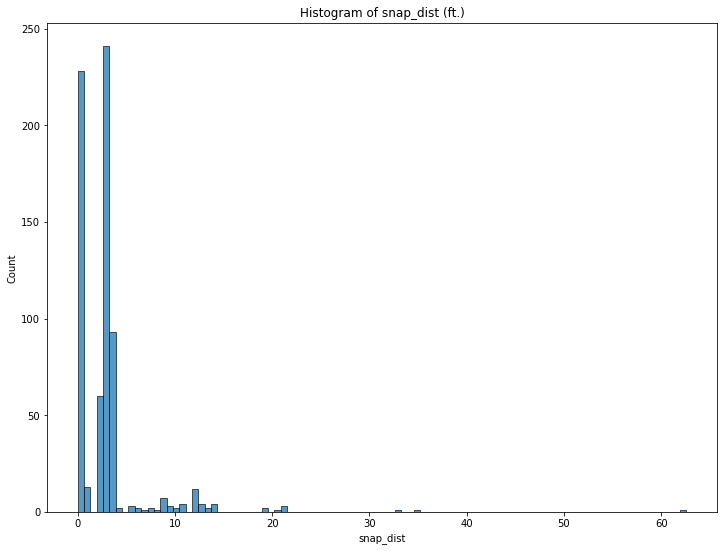

In [561]:
plt.figure(figsize=(12, 9))

sns.histplot(updated_points.snap_dist)
plt.title('Histogram of snap_dist (ft.)')

In [562]:
updated_points.iloc[:, 30:45].head()

index_right ntacode county_fips                   ntaname boro_name  \
32           131    QN12         081  Hammels-Arverne-Edgemere    Queens   
138          131    QN12         081  Hammels-Arverne-Edgemere    Queens   
251          131    QN12         081  Hammels-Arverne-Edgemere    Queens   
280          131    QN12         081  Hammels-Arverne-Edgemere    Queens   
332          131    QN12         081  Hammels-Arverne-Edgemere    Queens   

    boro_code  line_i physicalid      st_label  st_name    full_stree rw_type  \
32          4   805.0     180494    ALMEDA AVE   ALMEDA    ALMEDA AVE       1   
138         4   642.0     168839     BCH 67 ST     B 67       B 67 ST       1   
251         4   754.0      78832     BCH 73 ST     B 73       B 73 ST       1   
280         4   192.0     104183     BCH 64 ST     B 64       B 64 ST       1   
332         4   124.0      14425  ARVERNE BLVD  ARVERNE  ARVERNE BLVD       1   

    rw_type_name st_width frm_lvl_co  
32        Street       30         13  
138       Street       50         13  
251       Street       35         13  
280       Street       30         13  
332       Street       52         13

In [563]:
updated_points.physicalid.value_counts()

89897     48
92055     22
168518    22
14104     20
14030     17
          ..
136845     1
14373      1
14040      1
179744     1
14035      1
Name: physicalid, Length: 205, dtype: int64

In [564]:
updated_points.loc[updated_points.physicalid == '89897'].iloc[:, 30:45].head()

index_right ntacode county_fips                   ntaname boro_name  \
939           131    QN12         081  Hammels-Arverne-Edgemere    Queens   
1048          131    QN12         081  Hammels-Arverne-Edgemere    Queens   
1585          131    QN12         081  Hammels-Arverne-Edgemere    Queens   
1682          131    QN12         081  Hammels-Arverne-Edgemere    Queens   
3361          131    QN12         081  Hammels-Arverne-Edgemere    Queens   

     boro_code  line_i physicalid   st_label st_name full_stree rw_type  \
939          4    12.0      89897  BCH 84 ST    B 84    B 84 ST       1   
1048         4    12.0      89897  BCH 84 ST    B 84    B 84 ST       1   
1585         4    12.0      89897  BCH 84 ST    B 84    B 84 ST       1   
1682         4    12.0      89897  BCH 84 ST    B 84    B 84 ST       1   
3361         4    12.0      89897  BCH 84 ST    B 84    B 84 ST       1   

     rw_type_name st_width frm_lvl_co  
939        Street       20         13  
1048       Street       20         13  
1585       Street       20         13  
1682       Street       20         13  
3361       Street       20         13

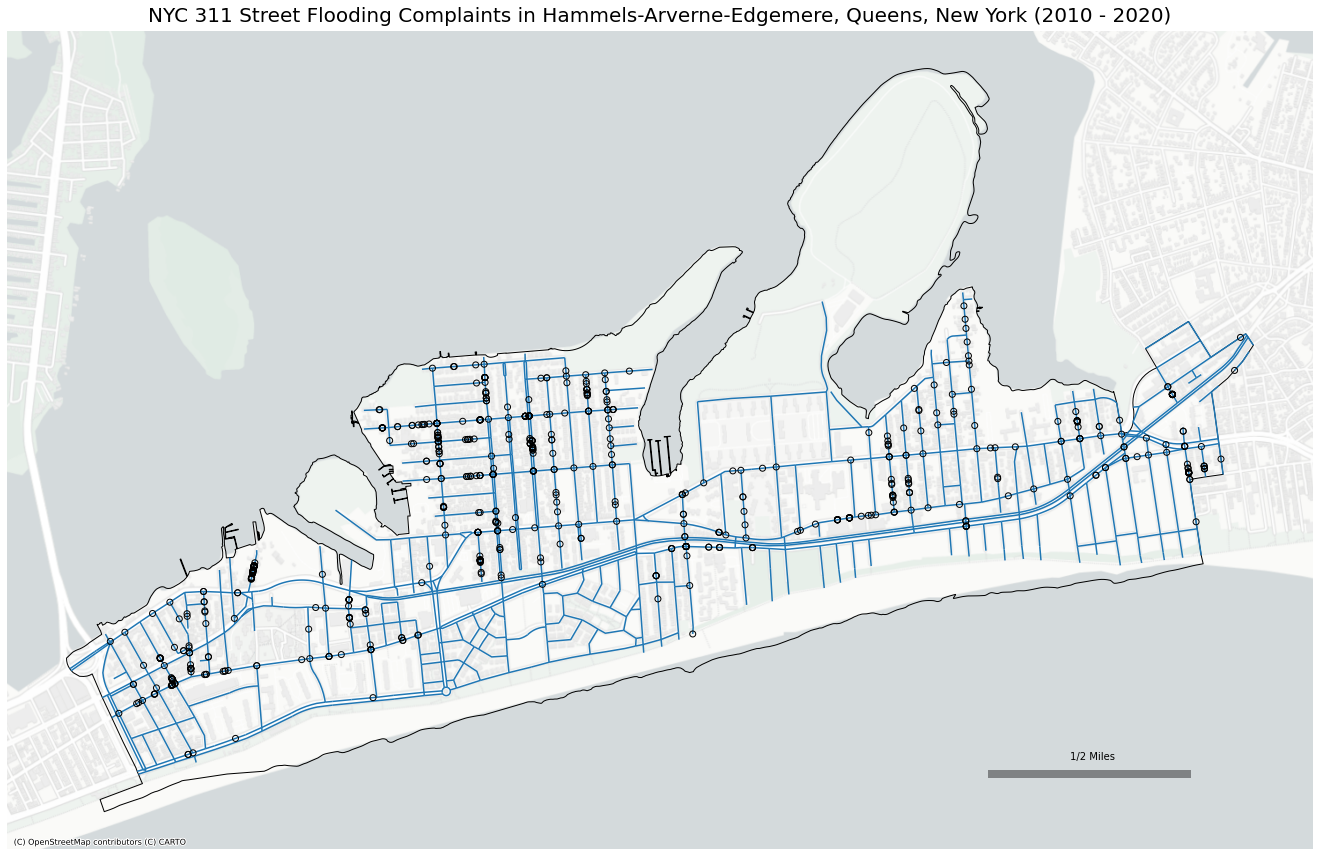

In [565]:
fig, ax = plt.subplots(figsize=(20,12)) # creating a figure

updated_points.plot(color='none', 
                edgecolor='black',
                ax=ax,
                zorder=3)

streets_clipped.plot(ax=ax, zorder=2)

nta_shape[nta_shape.ntaname == 'Hammels-Arverne-Edgemere'].plot(ax=ax, 
                                                                zorder=1, 
                                                                color='None', 
                                                                edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

# drawing the linke coordinates on the axis
x, y = [1047000, 1047000+5280/2], [152000, 152000]

# plotting the line
plt.plot(x, 
         y, 
         linewidth=8,
         color='black',
         alpha=.4, 
         zorder=3)

# adding the scale bar text to the line
plt.text(1047000 + (5280/2/2.5), 152000 + 200, '1/2 Miles', dict(size=10))

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('NYC 311 Street Flooding Complaints in Hammels-Arverne-Edgemere, Queens, New York (2010 - 2020)', 
             fontsize=20,
             pad=10)

plt.axis('off')
plt.tight_layout()
# plt.savefig('figures/Arverne1.png', facecolor='w')

In [566]:
gdf_count = updated_points.groupby(by='physicalid')['created_date'].count().reset_index()

In [567]:
gdf_count.head()

physicalid  created_date
0     101236             2
1     102480             1
2     104183            12
3     104184             4
4     104185             1

In [568]:
gdf_count.rename(columns={"created_date": "count"}, inplace=True)

In [569]:
gdf_count.head()

physicalid  count
0     101236      2
1     102480      1
2     104183     12
3     104184      4
4     104185      1

In [570]:
streets_clipped.set_geometry('geometry', inplace=True)

In [571]:
streets_clipped.geom_type.value_counts()

LineString    843
dtype: int64

In [572]:
streets_clipped['new_geom'] = streets_clipped.geometry.buffer(40, cap_style=2)

streets_clipped.set_geometry('new_geom', inplace=True)

In [573]:
streets_clipped.head()

physicalid             st_label         st_name          full_stree  \
41        92035            BCH 66 ST            B 66             B 66 ST   
252       14294            BCH 74 ST            B 74             B 74 ST   
347       14034  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE   
506      154483  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE   
1016      92062            BCH 87 ST            B 87             B 87 ST   

     rw_type rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
41         1       Street       42         13        13        4  495.233090   
252        1       Street       30         13        13        4  623.015421   
347        1       Street       35         13        13        4  234.071915   
506        1       Street       31         13        13        4  255.930554   
1016       1       Street       24         13        13        4  186.284190   

                                               geometry  \
41    LINESTRING (1041022.181 156864.681, 1040981.69...   
252   LINESTRING (1039173.301 154571.323, 1039121.22...   
347   LINESTRING (1046371.747 155628.532, 1046139.47...   
506   LINESTRING (1041944.905 154892.163, 1041702.46...   
1016  LINESTRING (1036423.096 153354.452, 1036408.71...   

                                               new_geom  
41    POLYGON ((1040941.827 157354.986, 1041021.559 ...  
252   POLYGON ((1039081.367 155188.815, 1039161.087 ...  
347   POLYGON ((1046144.416 155559.902, 1046134.526 ...  
506   POLYGON ((1041715.285 154772.266, 1041689.651 ...  
1016  POLYGON ((1036368.829 153537.091, 1036448.590 ...

In [574]:
streets_clipped.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 843 entries, 41 to 99101
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    843 non-null    object  
 1   st_label      843 non-null    object  
 2   st_name       843 non-null    object  
 3   full_stree    843 non-null    object  
 4   rw_type       843 non-null    object  
 5   rw_type_name  843 non-null    object  
 6   st_width      843 non-null    object  
 7   frm_lvl_co    843 non-null    object  
 8   to_lvl_co     843 non-null    object  
 9   borocode      843 non-null    object  
 10  shape_leng    843 non-null    float64 
 11  geometry      843 non-null    geometry
 12  new_geom      843 non-null    geometry
dtypes: float64(1), geometry(2), object(10)
memory usage: 92.2+ KB


In [575]:
# joining our nta population data to our nta shapes data
streets_with_count = streets_clipped.merge(gdf_count, 
                                           left_on='physicalid', 
                                           right_on='physicalid', 
                                           how='left')

In [576]:
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 843 entries, 0 to 842
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    843 non-null    object  
 1   st_label      843 non-null    object  
 2   st_name       843 non-null    object  
 3   full_stree    843 non-null    object  
 4   rw_type       843 non-null    object  
 5   rw_type_name  843 non-null    object  
 6   st_width      843 non-null    object  
 7   frm_lvl_co    843 non-null    object  
 8   to_lvl_co     843 non-null    object  
 9   borocode      843 non-null    object  
 10  shape_leng    843 non-null    float64 
 11  geometry      843 non-null    geometry
 12  new_geom      843 non-null    geometry
 13  count         205 non-null    float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 98.8+ KB


In [577]:
streets_with_count.isna().sum()

physicalid        0
st_label          0
st_name           0
full_stree        0
rw_type           0
rw_type_name      0
st_width          0
frm_lvl_co        0
to_lvl_co         0
borocode          0
shape_leng        0
geometry          0
new_geom          0
count           638
dtype: int64

In [578]:
streets_with_count['count'].fillna(0, inplace=True)

In [579]:
streets_with_count.head()

physicalid             st_label         st_name          full_stree rw_type  \
0      92035            BCH 66 ST            B 66             B 66 ST       1   
1      14294            BCH 74 ST            B 74             B 74 ST       1   
2      14034  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE       1   
3     154483  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE       1   
4      92062            BCH 87 ST            B 87             B 87 ST       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       42         13        13        4  495.233090   
1       Street       30         13        13        4  623.015421   
2       Street       35         13        13        4  234.071915   
3       Street       31         13        13        4  255.930554   
4       Street       24         13        13        4  186.284190   

                                            geometry  \
0  LINESTRING (1041022.181 156864.681, 1040981.69...   
1  LINESTRING (1039173.301 154571.323, 1039121.22...   
2  LINESTRING (1046371.747 155628.532, 1046139.47...   
3  LINESTRING (1041944.905 154892.163, 1041702.46...   
4  LINESTRING (1036423.096 153354.452, 1036408.71...   

                                            new_geom  count  
0  POLYGON ((1040941.827 157354.986, 1041021.559 ...    1.0  
1  POLYGON ((1039081.367 155188.815, 1039161.087 ...    0.0  
2  POLYGON ((1046144.416 155559.902, 1046134.526 ...    0.0  
3  POLYGON ((1041715.285 154772.266, 1041689.651 ...    0.0  
4  POLYGON ((1036368.829 153537.091, 1036448.590 ...    0.0

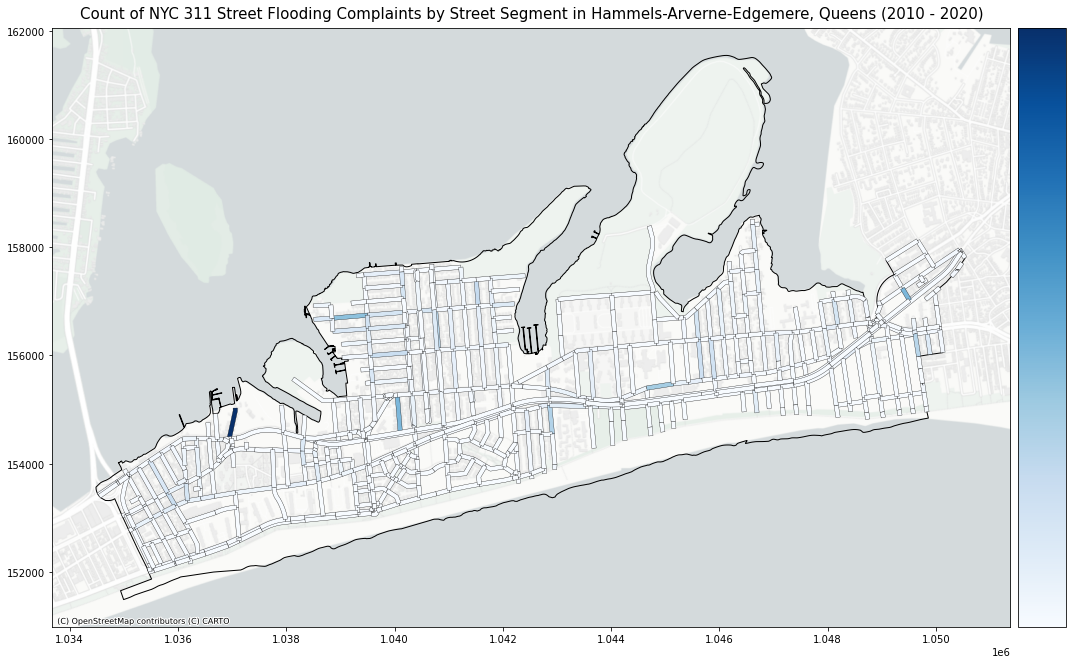

In [580]:
fig, ax = plt.subplots(figsize=(15,15)) # creating figure

# saving variable to format integers as strings with commas
comma_fmt = FuncFormatter(lambda x, p: format(int(x), ','))

# resizing the color bar to scale to the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(column='count', 
                        ax=ax, # plotting on the generated axis
                        cax=cax, # legend of the color bar
                        zorder=2,                        
                        cmap='Blues',
                        edgecolor='black',
                        linewidth=.3,
                        legend=True)

nta_shape[nta_shape.ntaname == 'Hammels-Arverne-Edgemere'].plot(ax=ax, 
                                                                zorder=1, 
                                                                color='None', 
                                                                edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('Count of NYC 311 Street Flooding Complaints by Street Segment in Hammels-Arverne-Edgemere, Queens (2010 - 2020)', 
             fontsize=15,
             pad=10)

plt.axis('off')
plt.tight_layout()
# plt.savefig('figures/Arverne1.png', facecolor='w')

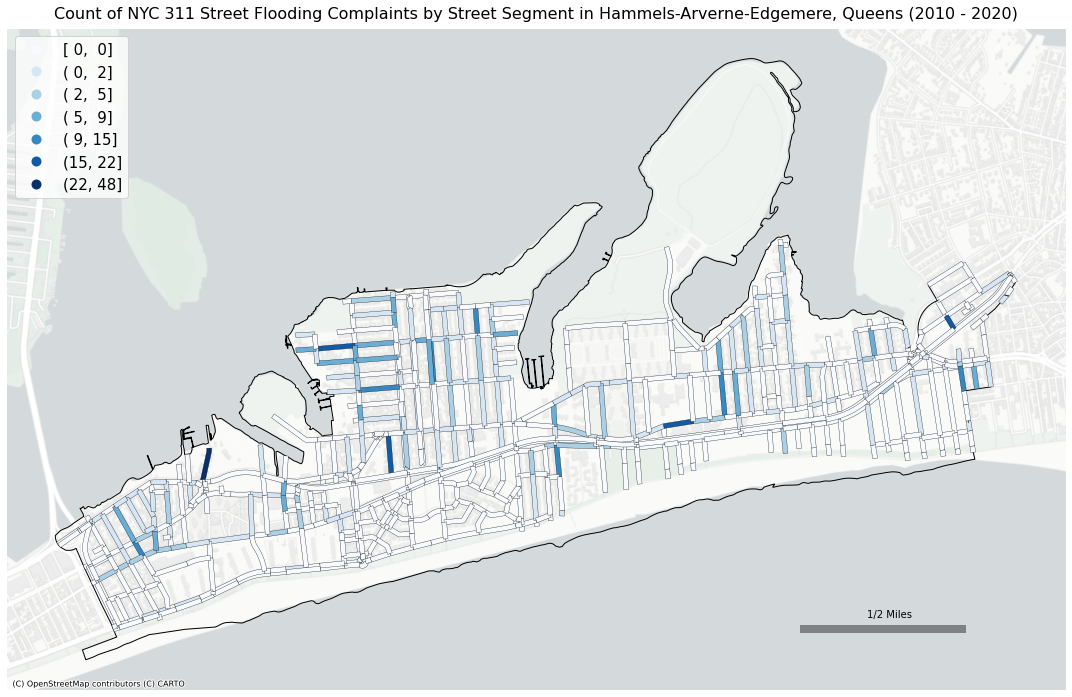

In [581]:
fig, ax = plt.subplots(figsize=(15,15)) # creating figure

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(column='count', 
                        ax=ax, # plotting on the generated axis
                        zorder=2,                        
                        cmap='Blues',
                        edgecolor='black',
                        linewidth=.3,
                        legend=True, 
                        scheme='fisherjenks',
                        k=7,
                        legend_kwds={'loc': "upper left", 
                                            'fmt': "{:,.0f}",
                                            'fontsize': "15"})

nta_shape[nta_shape.ntaname == 'Hammels-Arverne-Edgemere'].plot(ax=ax, 
                                                                zorder=1, 
                                                                color='None', 
                                                                edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

# drawing the linke coordinates on the axis
x, y = [1047000, 1047000+5280/2], [152000, 152000]

# plotting the line
plt.plot(x, 
         y, 
         linewidth=8,
         color='black',
         alpha=.4, 
         zorder=3)

# adding the scale bar text to the line
plt.text(1047000 + (5280/2/2.5), 152000 + 200, '1/2 Miles', dict(size=10))

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('Count of NYC 311 Street Flooding Complaints by Street Segment in Hammels-Arverne-Edgemere, Queens (2010 - 2020)', 
             fontsize=16,
             pad=10)

plt.axis('off')
plt.tight_layout()
# plt.savefig('figures/Arverne1.png', facecolor='w')

In [582]:
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 843 entries, 0 to 842
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    843 non-null    object  
 1   st_label      843 non-null    object  
 2   st_name       843 non-null    object  
 3   full_stree    843 non-null    object  
 4   rw_type       843 non-null    object  
 5   rw_type_name  843 non-null    object  
 6   st_width      843 non-null    object  
 7   frm_lvl_co    843 non-null    object  
 8   to_lvl_co     843 non-null    object  
 9   borocode      843 non-null    object  
 10  shape_leng    843 non-null    float64 
 11  geometry      843 non-null    geometry
 12  new_geom      843 non-null    geometry
 13  count         843 non-null    float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 98.8+ KB


In [583]:
streets_with_count['shape_leng'] = streets_with_count.geometry.length

In [584]:
streets_with_count.length.describe()

count     843.000000
mean      765.465404
std       480.935941
min       160.000025
25%       431.234423
50%       662.259194
75%       951.824937
max      4017.618319
dtype: float64

In [585]:
streets_with_count.describe()

shape_leng       count
count   843.000000  843.000000
mean    765.465404    0.822064
std     480.935941    2.778290
min     160.000025    0.000000
25%     431.234423    0.000000
50%     662.259194    0.000000
75%     951.824937    0.000000
max    4017.618319   48.000000

In [586]:
streets_with_count['count_per_100ft'] = (streets_with_count['count'] / streets_with_count['shape_leng']) * 100

streets_with_count.head()

physicalid             st_label         st_name          full_stree rw_type  \
0      92035            BCH 66 ST            B 66             B 66 ST       1   
1      14294            BCH 74 ST            B 74             B 74 ST       1   
2      14034  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE       1   
3     154483  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE       1   
4      92062            BCH 87 ST            B 87             B 87 ST       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
0       Street       42         13        13        4  1150.466181   
1       Street       30         13        13        4  1406.030841   
2       Street       35         13        13        4   628.143830   
3       Street       31         13        13        4   671.861108   
4       Street       24         13        13        4   532.568379   

                                            geometry  \
0  LINESTRING (1041022.181 156864.681, 1040981.69...   
1  LINESTRING (1039173.301 154571.323, 1039121.22...   
2  LINESTRING (1046371.747 155628.532, 1046139.47...   
3  LINESTRING (1041944.905 154892.163, 1041702.46...   
4  LINESTRING (1036423.096 153354.452, 1036408.71...   

                                            new_geom  count  count_per_100ft  
0  POLYGON ((1040941.827 157354.986, 1041021.559 ...    1.0         0.086921  
1  POLYGON ((1039081.367 155188.815, 1039161.087 ...    0.0         0.000000  
2  POLYGON ((1046144.416 155559.902, 1046134.526 ...    0.0         0.000000  
3  POLYGON ((1041715.285 154772.266, 1041689.651 ...    0.0         0.000000  
4  POLYGON ((1036368.829 153537.091, 1036448.590 ...    0.0         0.000000

In [587]:
streets_with_count.describe()

shape_leng       count  count_per_100ft
count   843.000000  843.000000       843.000000
mean    765.465404    0.822064         0.106631
std     480.935941    2.778290         0.347703
min     160.000025    0.000000         0.000000
25%     431.234423    0.000000         0.000000
50%     662.259194    0.000000         0.000000
75%     951.824937    0.000000         0.000000
max    4017.618319   48.000000         4.644650

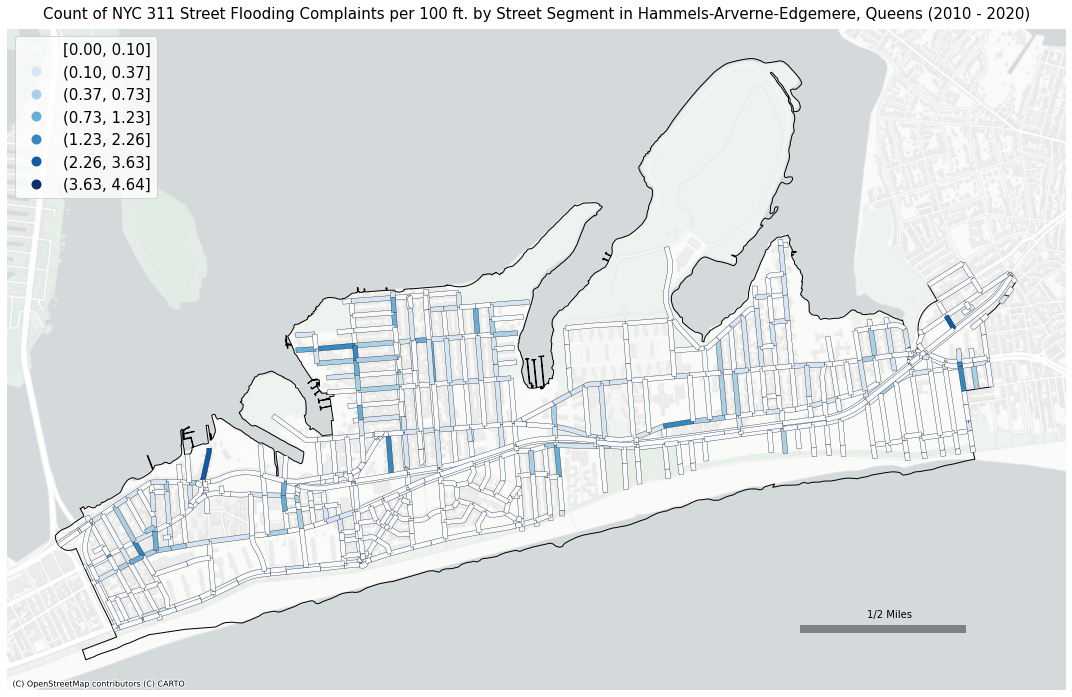

In [588]:
fig, ax = plt.subplots(figsize=(15,15)) # creating figure

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(column='count_per_100ft', 
                        ax=ax, # plotting on the generated axis
                        zorder=2,                        
                        cmap='Blues',
                        edgecolor='black',
                        linewidth=.3,
                        legend=True, 
                        scheme='fisherjenks',
                        k=7,
                        legend_kwds={'loc': "upper left", 
                                              'fmt': "{:,.2f}",
                                              'fontsize': "15"})

nta_shape[nta_shape.ntaname == 'Hammels-Arverne-Edgemere'].plot(ax=ax, 
                                                                zorder=1, 
                                                                color='None', 
                                                                edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

# drawing the linke coordinates on the axis
x, y = [1047000, 1047000+5280/2], [152000, 152000]

# plotting the line
plt.plot(x, 
         y, 
         linewidth=8,
         color='black',
         alpha=.4, 
         zorder=3)

# adding the scale bar text to the line
plt.text(1047000 + (5280/2/2.5), 152000 + 200, '1/2 Miles', dict(size=10))

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('Count of NYC 311 Street Flooding Complaints per 100 ft. by Street Segment in Hammels-Arverne-Edgemere, Queens (2010 - 2020)', 
             fontsize=15,
             pad=10)

plt.axis('off')
plt.tight_layout()

plt.savefig('figures/arverne.png')

<AxesSubplot:>

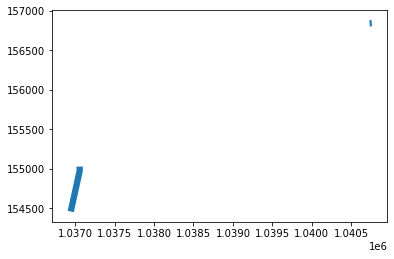

In [589]:
streets_with_count.sort_values(by='count_per_100ft', ascending=False).head(2).plot()

In [590]:
streets_with_count.sort_values(by='count_per_100ft', ascending=False).head()

physicalid     st_label  st_name   full_stree rw_type rw_type_name  \
141      14099   ALMEDA AVE   ALMEDA   ALMEDA AVE       1       Street   
12       89897    BCH 84 ST     B 84      B 84 ST       1       Street   
721     168518    BCH 32 ST     B 32      B 32 ST       1       Street   
289      14115  THURSBY AVE  THURSBY  THURSBY AVE       1       Street   
294      14110  THURSBY AVE  THURSBY  THURSBY AVE       1       Street   

    st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
141       52         13        13        4   215.301494   
12        20         13        13        4  1322.346934   
721       30         13        13        4   670.276012   
289       60         13        13        4   216.157649   
294       58         13        13        4   221.032906   

                                              geometry  \
141  LINESTRING (1040758.199 156843.323, 1040743.30...   
12   LINESTRING (1036945.986 154458.262, 1037059.20...   
721  LINESTRING (1049512.805 157017.705, 1049383.00...   
289  LINESTRING (1040269.040 156052.196, 1040255.64...   
294  LINESTRING (1040815.925 156097.308, 1040800.88...   

                                              new_geom  count  count_per_100ft  
141  POLYGON ((1040746.527 156802.249, 1040746.464 ...   10.0         4.644650  
12   POLYGON ((1037019.120 154979.182, 1037018.204 ...   48.0         3.629910  
721  POLYGON ((1049348.570 157217.010, 1049417.444 ...   22.0         3.282230  
289  POLYGON ((1040258.352 156011.379, 1040258.188 ...    7.0         3.238377  
294  POLYGON ((1040804.822 156056.256, 1040790.137 ...    5.0         2.262107

In [591]:
streets_with_count['count'].sum()

693.0

## New Dorp - Midland Beach, Staten Island

In [592]:
gdf = gpd.GeoDataFrame(flooding_311, 
                       geometry=gpd.points_from_xy(flooding_311.x_coordinate_state_plane, 
                                                   flooding_311.y_coordinate_state_plane))

In [593]:
gdf.head()

unique_key             created_date              closed_date agency  \
0    45989680  2020-04-12T14:14:00.000  2020-04-13T08:10:00.000    DEP   
1    45178597  2019-12-16T07:48:00.000  2020-01-16T13:35:00.000    DEP   
2    47428465  2020-09-01T09:58:00.000  2020-09-01T18:05:00.000    DEP   
3    48133312  2020-11-12T16:23:00.000  2020-11-13T14:10:00.000    DEP   
4    48135671  2020-11-12T14:19:00.000  2020-11-16T08:35:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)       10310.0                   NaN   
1  Street Flooding (SJ)       11207.0       WILLIAMS AVENUE   
2  Street Flooding (SJ)       11001.0                   NaN   
3  Street Flooding (SJ)       11236.0                   NaN   
4  Street Flooding (SJ)       11208.0       SAPPHIRE STREET   

  intersection_street_2  ...   park_borough   latitude  longitude  \
0                   NaN  ...  STATEN ISLAND  40.628599 -74.112841   
1  EAST NEW YORK AVENUE  ...       BROOKLYN  40.676574 -73.900793   
2                   NaN  ...         QUEENS  40.737833 -73.703547   
3                   NaN  ...       BROOKLYN  40.629816 -73.900300   
4         LORING AVENUE  ...       BROOKLYN  40.668603 -73.856848   

                                            location     incident_address  \
0  {'latitude': '40.6285987', 'longitude': '-74.1...  204 MORRISON AVENUE   
1  {'latitude': '40.6765736', 'longitude': '-73.9...                  NaN   
2  {'latitude': '40.737832829634904', 'longitude'...     84-17 265 STREET   
3  {'latitude': '40.62981582525854', 'longitude':...        8518 AVENUE N   
4  {'latitude': '40.66860317832641', 'longitude':...                  NaN   

       street_name cross_street_1   cross_street_2           bbl  \
0  MORRISON AVENUE     BEMENT AVE    N BURGHER AVE  5.003000e+09   
1              NaN            NaN              NaN           NaN   
2       265 STREET   HILLSIDE AVE  E WILLISTON AVE  4.087950e+09   
3         AVENUE N        E 85 ST          E 86 ST  3.080820e+09   
4              NaN            NaN              NaN           NaN   

                         geometry  
0   POINT (952928.000 168312.000)  
1  POINT (1011768.000 185786.000)  
2  POINT (1066404.000 208228.000)  
3  POINT (1011924.000 168751.000)  
4  POINT (1023962.000 182899.000)  

[5 rows x 31 columns]

In [594]:
gdf.set_crs(epsg=2263, inplace=True)
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

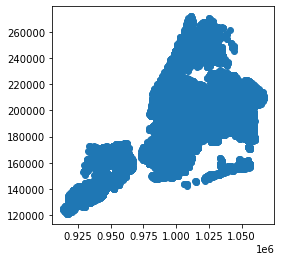

In [595]:
gdf.plot()

In [596]:
gdf.shape

(26962, 31)

In [597]:
gdf.isna().sum()

unique_key                            0
created_date                          0
closed_date                          11
agency                                0
agency_name                           0
complaint_type                        0
descriptor                            0
incident_zip                          0
intersection_street_1             17607
intersection_street_2             17607
address_type                          0
city                                  0
status                                0
resolution_description               15
resolution_action_updated_date        8
community_board                       0
borough                               0
x_coordinate_state_plane              0
y_coordinate_state_plane              0
open_data_channel_type                0
park_facility_name                    0
park_borough                          0
latitude                           2499
longitude                          2499
location                           2499


In [598]:
gdf = gpd.sjoin(gdf, 
                nta_shape, 
                how="inner", 
                op='within')

In [599]:
gdf.head()

unique_key             created_date              closed_date agency  \
0      45989680  2020-04-12T14:14:00.000  2020-04-13T08:10:00.000    DEP   
66     45188341  2019-12-18T08:20:00.000  2019-12-20T09:30:00.000    DEP   
83     46379956  2020-06-04T07:24:00.000  2020-06-04T14:40:00.000    DEP   
185    46122447  2020-05-03T13:25:00.000  2020-05-03T14:20:00.000    DEP   
537    24452089  2012-11-21T09:58:00.000  2012-11-22T09:30:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
66   Department of Environmental Protection          Sewer   
83   Department of Environmental Protection          Sewer   
185  Department of Environmental Protection          Sewer   
537  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       10310.0                   NaN   
66   Street Flooding (SJ)       10310.0              BROADWAY   
83   Street Flooding (SJ)       10310.0                   NaN   
185  Street Flooding (SJ)       10310.0                   NaN   
537  Street Flooding (SJ)       10310.0                   NaN   

    intersection_street_2  ...           bbl                       geometry  \
0                     NaN  ...  5.003000e+09  POINT (952928.000 168312.000)   
66       DELAFIELD AVENUE  ...           NaN  POINT (951912.000 169099.000)   
83                    NaN  ...  5.001470e+09  POINT (954593.000 169517.000)   
185                   NaN  ...  5.002840e+09  POINT (954095.000 168394.000)   
537                   NaN  ...  5.003000e+09  POINT (952928.000 168312.000)   

    index_right ntacode     shape_area county_fips                   ntaname  \
0           122    SI35  47137243.9922         085  New Brighton-Silver Lake   
66          122    SI35  47137243.9922         085  New Brighton-Silver Lake   
83          122    SI35  47137243.9922         085  New Brighton-Silver Lake   
185         122    SI35  47137243.9922         085  New Brighton-Silver Lake   
537         122    SI35  47137243.9922         085  New Brighton-Silver Lake   

        shape_leng      boro_name boro_code  
0    30320.3749453  Staten Island         5  
66   30320.3749453  Staten Island         5  
83   30320.3749453  Staten Island         5  
185  30320.3749453  Staten Island         5  
537  30320.3749453  Staten Island         5  

[5 rows x 39 columns]

In [600]:
gdf.drop(columns=["shape_leng", 'shape_area'], inplace=True)

In [601]:
ls data-raw/

raw-street-flooding-data.csv  raw-streets-clipped.json


In [602]:
path = 'data-raw/raw-streets-clipped.json'
streets = gpd.read_file(path)

streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  
0  LINESTRING (1047146.080 222733.432, 1047385.93...  
1  LINESTRING (1009926.638 269075.549, 1010033.71...  
2  LINESTRING (989292.818 189689.736, 989648.842 ...  
3  LINESTRING (1031371.427 199453.863, 1031412.58...  
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [603]:
streets.shape

(99362, 12)

<AxesSubplot:>

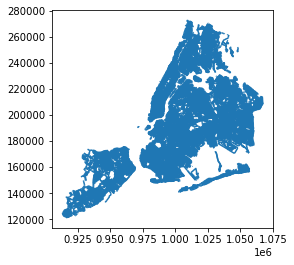

In [604]:
streets.plot()

In [605]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99362 entries, 0 to 99361
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99362 non-null  object  
 1   st_label      99362 non-null  object  
 2   st_name       99362 non-null  object  
 3   full_stree    99362 non-null  object  
 4   rw_type       99362 non-null  object  
 5   rw_type_name  99362 non-null  object  
 6   st_width      99362 non-null  object  
 7   frm_lvl_co    99362 non-null  object  
 8   to_lvl_co     99362 non-null  object  
 9   borocode      99362 non-null  object  
 10  shape_leng    99362 non-null  float64 
 11  geometry      99362 non-null  geometry
dtypes: float64(1), geometry(1), object(10)
memory usage: 9.1+ MB


In [606]:
streets.describe()

shape_leng
count  9.936200e+04
mean   3.431188e+02
std    2.620211e+02
min    1.068681e-08
25%    1.953735e+02
50%    2.648459e+02
75%    4.583545e+02
max    1.509366e+04

In [607]:
streets.geom_type.value_counts()

LineString    99362
dtype: int64

In [608]:
streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  
0  LINESTRING (1047146.080 222733.432, 1047385.93...  
1  LINESTRING (1009926.638 269075.549, 1010033.71...  
2  LINESTRING (989292.818 189689.736, 989648.842 ...  
3  LINESTRING (1031371.427 199453.863, 1031412.58...  
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [609]:
New_Dorp_Midland_Beach = nta_shape[nta_shape.ntaname == 'New Dorp-Midland Beach']

New_Dorp_Midland_Beach.head()

ntacode     shape_area county_fips                 ntaname     shape_leng  \
95    SI45  55429451.2194         085  New Dorp-Midland Beach  34336.5206382   

        boro_name boro_code                                           geometry  
95  Staten Island         5  MULTIPOLYGON (((960721.609 147492.642, 960370....

In [610]:
# clipping the school points that only fall within the nta shapes
streets_clipped = gpd.clip(streets, New_Dorp_Midland_Beach)

<AxesSubplot:>

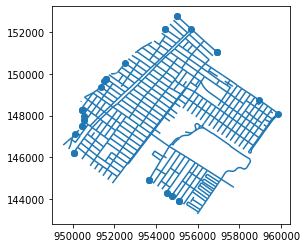

In [611]:
streets_clipped.plot()

In [612]:
streets_clipped.geom_type.value_counts()

LineString            737
Point                  32
GeometryCollection      5
MultiLineString         2
dtype: int64

In [613]:
streets_clipped = streets_clipped[streets_clipped.geom_type == 'LineString']

streets_clipped.geom_type.value_counts()

LineString    737
dtype: int64

In [614]:
# clipping the school points that only fall within the nta shapes
New_Dorp_Midland_Beach = gpd.clip(gdf, New_Dorp_Midland_Beach)

<AxesSubplot:>

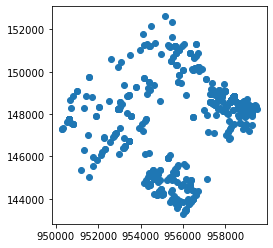

In [615]:
New_Dorp_Midland_Beach.plot()

In [616]:
New_Dorp_Midland_Beach.geom_type.value_counts()

Point    763
dtype: int64

# Snap points to lines

# https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa

In [617]:
streets_clipped.sindex

rtree.index.Index(bounds=[949549.8247149212, 143281.59894616972, 959897.8481633187, 152760.96722404534], size=737)

In [618]:
offset = 80

bbox = New_Dorp_Midland_Beach.bounds + [-offset, -offset, offset, offset]

bbox.head()

minx      miny      maxx      maxy
5    958199.0  148584.0  958359.0  148744.0
38   954802.0  144252.0  954962.0  144412.0
230  958283.0  148713.0  958443.0  148873.0
320  958283.0  148713.0  958443.0  148873.0
333  958283.0  148713.0  958443.0  148873.0

In [619]:
hits = bbox.apply(lambda row: list(streets_clipped.sindex.intersection(row)), axis=1)

hits.head()

5      [297, 52, 592, 148, 515]
38                   [166, 684]
230         [52, 592, 148, 515]
320         [52, 592, 148, 515]
333         [52, 592, 148, 515]
dtype: object

In [620]:
hits.shape

(763,)

In [621]:
tmp = pd.DataFrame(
    # index of points table
    {"pt_idx": np.repeat(hits.index, hits.apply(len)),
        
    # ordinal position of line - access via iloc later
    "line_i": np.concatenate(hits.values)
    })

In [622]:
tmp.head()

pt_idx  line_i
0       5   297.0
1       5    52.0
2       5   592.0
3       5   148.0
4       5   515.0

In [623]:
tmp.shape

(2651, 2)

In [624]:
streets_clipped.shape

(737, 12)

In [625]:
streets_clipped.head()

physicalid        st_label   st_name       full_stree rw_type  \
90       63908  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1   
411      98840     FREMONT AVE   FREMONT      FREMONT AVE       1   
551      64022      HAMDEN AVE    HAMDEN       HAMDEN AVE       1   
581     169350      SANCHEZ DR   SANCHEZ       SANCHEZ DR       1   
651      63915  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1   

    rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
90        Street       30         13        13        5  256.539897   
411       Street       30         13        13        5  447.066950   
551       Street       20         13        13        5   40.275747   
581       Street       18         13        13        5  176.145848   
651       Street       30         13        13        5  261.169357   

                                              geometry  
90   LINESTRING (954781.156 151271.724, 954597.833 ...  
411  LINESTRING (952841.921 150886.337, 953221.730 ...  
551  LINESTRING (957558.853 149344.789, 957591.137 ...  
581  LINESTRING (955726.813 147175.642, 955875.554 ...  
651  LINESTRING (953360.096 149917.140, 953173.390 ...

In [626]:
# Join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(streets_clipped.reset_index(drop=True), on="line_i")

tmp.head()

pt_idx  line_i physicalid      st_label   st_name    full_stree rw_type  \
0       5   297.0      52152   BEDFORD AVE   BEDFORD   BEDFORD AVE       1   
1       5    52.0      76942    GRIMSBY ST   GRIMSBY    GRIMSBY ST       1   
2       5   592.0      76094  MAPLETON AVE  MAPLETON  MAPLETON AVE       1   
3       5   148.0      76941    GRIMSBY ST   GRIMSBY    GRIMSBY ST       1   
4       5   515.0      52063    NUGENT AVE    NUGENT    NUGENT AVE       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       38         13        13        5  251.434898   
1       Street       32         13        13        5  197.483486   
2       Street       18         13        13        5  251.356512   
3       Street       22         13        13        5  372.786118   
4       Street       38         13        13        5  556.903669   

                                            geometry  
0  LINESTRING (957997.166 148703.120, 958202.776 ...  
1  LINESTRING (958315.338 148720.663, 958202.776 ...  
2  LINESTRING (958315.338 148720.663, 958524.695 ...  
3  LINESTRING (958533.655 149022.834, 958315.338 ...  
4  LINESTRING (958315.906 149159.789, 957997.166 ...

In [627]:
# Join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(New_Dorp_Midland_Beach.geometry.rename("point"), on="pt_idx")

# Convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(tmp, geometry="geometry", crs=New_Dorp_Midland_Beach.crs)

tmp.head()

pt_idx  line_i physicalid      st_label   st_name    full_stree rw_type  \
0       5   297.0      52152   BEDFORD AVE   BEDFORD   BEDFORD AVE       1   
1       5    52.0      76942    GRIMSBY ST   GRIMSBY    GRIMSBY ST       1   
2       5   592.0      76094  MAPLETON AVE  MAPLETON  MAPLETON AVE       1   
3       5   148.0      76941    GRIMSBY ST   GRIMSBY    GRIMSBY ST       1   
4       5   515.0      52063    NUGENT AVE    NUGENT    NUGENT AVE       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       38         13        13        5  251.434898   
1       Street       32         13        13        5  197.483486   
2       Street       18         13        13        5  251.356512   
3       Street       22         13        13        5  372.786118   
4       Street       38         13        13        5  556.903669   

                                            geometry  \
0  LINESTRING (957997.166 148703.120, 958202.776 ...   
1  LINESTRING (958315.338 148720.663, 958202.776 ...   
2  LINESTRING (958315.338 148720.663, 958524.695 ...   
3  LINESTRING (958533.655 149022.834, 958315.338 ...   
4  LINESTRING (958315.906 149159.789, 957997.166 ...   

                           point  
0  POINT (958279.000 148664.000)  
1  POINT (958279.000 148664.000)  
2  POINT (958279.000 148664.000)  
3  POINT (958279.000 148664.000)  
4  POINT (958279.000 148664.000)

In [628]:
tmp["snap_dist"] = tmp.geometry.distance(gpd.GeoSeries(tmp.point))

tmp[['snap_dist']].describe()

snap_dist
count  2651.000000
mean     79.239112
std     111.270599
min       0.000567
25%       0.489088
50%      24.095470
75%      97.963148
max    1119.662091

In [629]:
# Discard any lines that are greater than tolerance from points
tmp = tmp.loc[tmp.snap_dist <= offset]

# Sort on ascending snap distance, so that closest goes to top
tmp = tmp.sort_values(by=["snap_dist"])

tmp.head()

pt_idx  line_i physicalid      st_label   st_name    full_stree rw_type  \
1515   17794   292.0      55540  BANCROFT AVE  BANCROFT  BANCROFT AVE       1   
2300   25298   292.0      55540  BANCROFT AVE  BANCROFT  BANCROFT AVE       1   
921     8394   497.0      64050    CLAWSON ST   CLAWSON    CLAWSON ST       1   
2207   24959   668.0      15665    HYLAN BLVD     HYLAN    HYLAN BLVD       1   
2268   25209   668.0      15665    HYLAN BLVD     HYLAN    HYLAN BLVD       1   

     rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
1515       Street       30         13        13        5  608.866647   
2300       Street       30         13        13        5  608.866647   
921        Street       32         13        13        5  259.287109   
2207       Street       70         13        13        5  305.775123   
2268       Street       70         13        13        5  305.775123   

                                               geometry  \
1515  LINESTRING (953291.900 149648.075, 953790.042 ...   
2300  LINESTRING (953291.900 149648.075, 953790.042 ...   
921   LINESTRING (952706.317 146911.440, 952557.581 ...   
2207  LINESTRING (956007.528 150101.076, 955827.781 ...   
2268  LINESTRING (956007.528 150101.076, 955827.781 ...   

                              point  snap_dist  
1515  POINT (953790.000 149298.000)   0.000567  
2300  POINT (953790.000 149298.000)   0.000567  
921   POINT (952706.000 146911.000)   0.007325  
2207  POINT (955828.000 149854.000)   0.007674  
2268  POINT (955828.000 149854.000)   0.007674

In [630]:
tmp[['snap_dist']].describe()

snap_dist
count  1648.000000
mean     13.755014
std      23.876935
min       0.000567
25%       0.375526
50%       2.640262
75%       4.028307
max      79.689427

In [631]:
# group by the index of the points and take the first, which is the
# closest line 
closest = tmp.groupby("pt_idx").first()

# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")

closest.head()

line_i physicalid    st_label  st_name  full_stree rw_type  \
pt_idx                                                               
5         52.0      76942  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
38       684.0      63096  MILTON AVE   MILTON  MILTON AVE       1   
230      148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
320      148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
333      148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
5            Street       32         13        13        5  197.483486   
38           Street       32         13        13        5  878.395026   
230          Street       22         13        13        5  372.786118   
320          Street       22         13        13        5  372.786118   
333          Street       22         13        13        5  372.786118   

                                                 geometry  \
pt_idx                                                      
5       LINESTRING (958315.338 148720.663, 958202.776 ...   
38      LINESTRING (955262.775 144866.999, 954749.637 ...   
230     LINESTRING (958533.655 149022.834, 958315.338 ...   
320     LINESTRING (958533.655 149022.834, 958315.338 ...   
333     LINESTRING (958533.655 149022.834, 958315.338 ...   

                                point  snap_dist  
pt_idx                                            
5       POINT (958279.000 148664.000)   2.439189  
38      POINT (954882.000 144332.000)   3.487156  
230     POINT (958363.000 148793.000)   3.729798  
320     POINT (958363.000 148793.000)   3.729798  
333     POINT (958363.000 148793.000)   3.729798

In [632]:
# Position of nearest point from start of the line
pos = closest.geometry.project(gpd.GeoSeries(closest.point))

# Get new point location geometry
new_pts = closest.geometry.interpolate(pos)

new_pts.head()

pt_idx
5      POINT (958276.996 148665.390)
38     POINT (954879.170 144334.037)
230    POINT (958366.023 148790.816)
320    POINT (958366.023 148790.816)
333    POINT (958366.023 148790.816)
dtype: geometry

In [633]:
# Create a new GeoDataFrame from the columns from the closest line and new point geometries (which will be called "geometries")
snapped = gpd.GeoDataFrame(closest, geometry=new_pts)

snapped.head()

line_i physicalid    st_label  st_name  full_stree rw_type  \
pt_idx                                                               
5         52.0      76942  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
38       684.0      63096  MILTON AVE   MILTON  MILTON AVE       1   
230      148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
320      148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
333      148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
5            Street       32         13        13        5  197.483486   
38           Street       32         13        13        5  878.395026   
230          Street       22         13        13        5  372.786118   
320          Street       22         13        13        5  372.786118   
333          Street       22         13        13        5  372.786118   

                             geometry                          point  \
pt_idx                                                                 
5       POINT (958276.996 148665.390)  POINT (958279.000 148664.000)   
38      POINT (954879.170 144334.037)  POINT (954882.000 144332.000)   
230     POINT (958366.023 148790.816)  POINT (958363.000 148793.000)   
320     POINT (958366.023 148790.816)  POINT (958363.000 148793.000)   
333     POINT (958366.023 148790.816)  POINT (958363.000 148793.000)   

        snap_dist  
pt_idx             
5        2.439189  
38       3.487156  
230      3.729798  
320      3.729798  
333      3.729798

In [634]:
New_Dorp_Midland_Beach.head()

unique_key             created_date              closed_date agency  \
5      47242622  2020-08-14T14:54:00.000  2020-08-18T11:00:00.000    DEP   
38     45186927  2019-12-17T07:47:00.000  2019-12-18T09:30:00.000    DEP   
230    45279697  2019-12-31T07:10:00.000  2019-12-31T09:30:00.000    DEP   
320    48167693  2020-11-16T08:13:00.000  2020-11-17T13:45:00.000    DEP   
333    47467700  2020-09-04T07:56:00.000  2020-09-04T11:10:00.000    DEP   

                                agency_name complaint_type  \
5    Department of Environmental Protection          Sewer   
38   Department of Environmental Protection          Sewer   
230  Department of Environmental Protection          Sewer   
320  Department of Environmental Protection          Sewer   
333  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
5    Street Flooding (SJ)       10306.0                   NaN   
38   Street Flooding (SJ)       10306.0                   NaN   
230  Street Flooding (SJ)       10306.0                   NaN   
320  Street Flooding (SJ)       10306.0                   NaN   
333  Street Flooding (SJ)       10306.0                   NaN   

    intersection_street_2  ... cross_street_1 cross_street_2           bbl  \
5                     NaN  ...   MAPLETON AVE    BEDFORD AVE  5.037990e+09   
38                    NaN  ...     MARINE WAY     EBBITTS ST  5.040500e+09   
230                   NaN  ...     HUNTER AVE   MAPLETON AVE  5.037950e+09   
320                   NaN  ...     HUNTER AVE   MAPLETON AVE  5.037950e+09   
333                   NaN  ...     HUNTER AVE   MAPLETON AVE  5.037950e+09   

                          geometry index_right ntacode county_fips  \
5    POINT (958279.000 148664.000)          95    SI45         085   
38   POINT (954882.000 144332.000)          95    SI45         085   
230  POINT (958363.000 148793.000)          95    SI45         085   
320  POINT (958363.000 148793.000)          95    SI45         085   
333  POINT (958363.000 148793.000)          95    SI45         085   

                    ntaname      boro_name boro_code  
5    New Dorp-Midland Beach  Staten Island         5  
38   New Dorp-Midland Beach  Staten Island         5  
230  New Dorp-Midland Beach  Staten Island         5  
320  New Dorp-Midland Beach  Staten Island         5  
333  New Dorp-Midland Beach  Staten Island         5  

[5 rows x 37 columns]

In [635]:
New_Dorp_Midland_Beach.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 763 entries, 5 to 27802
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      763 non-null    int64   
 1   created_date                    763 non-null    object  
 2   closed_date                     763 non-null    object  
 3   agency                          763 non-null    object  
 4   agency_name                     763 non-null    object  
 5   complaint_type                  763 non-null    object  
 6   descriptor                      763 non-null    object  
 7   incident_zip                    763 non-null    float64 
 8   intersection_street_1           216 non-null    object  
 9   intersection_street_2           216 non-null    object  
 10  address_type                    763 non-null    object  
 11  city                            763 non-null    object  
 12  status      

In [636]:
New_Dorp_Midland_Beach.drop(columns=["geometry"], inplace=True)

In [637]:
New_Dorp_Midland_Beach.head()

unique_key             created_date              closed_date agency  \
5      47242622  2020-08-14T14:54:00.000  2020-08-18T11:00:00.000    DEP   
38     45186927  2019-12-17T07:47:00.000  2019-12-18T09:30:00.000    DEP   
230    45279697  2019-12-31T07:10:00.000  2019-12-31T09:30:00.000    DEP   
320    48167693  2020-11-16T08:13:00.000  2020-11-17T13:45:00.000    DEP   
333    47467700  2020-09-04T07:56:00.000  2020-09-04T11:10:00.000    DEP   

                                agency_name complaint_type  \
5    Department of Environmental Protection          Sewer   
38   Department of Environmental Protection          Sewer   
230  Department of Environmental Protection          Sewer   
320  Department of Environmental Protection          Sewer   
333  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
5    Street Flooding (SJ)       10306.0                   NaN   
38   Street Flooding (SJ)       10306.0                   NaN   
230  Street Flooding (SJ)       10306.0                   NaN   
320  Street Flooding (SJ)       10306.0                   NaN   
333  Street Flooding (SJ)       10306.0                   NaN   

    intersection_street_2  ...     street_name cross_street_1 cross_street_2  \
5                     NaN  ...  GRIMSBY STREET   MAPLETON AVE    BEDFORD AVE   
38                    NaN  ...   MILTON AVENUE     MARINE WAY     EBBITTS ST   
230                   NaN  ...  GRIMSBY STREET     HUNTER AVE   MAPLETON AVE   
320                   NaN  ...  GRIMSBY STREET     HUNTER AVE   MAPLETON AVE   
333                   NaN  ...  GRIMSBY STREET     HUNTER AVE   MAPLETON AVE   

              bbl index_right ntacode county_fips                 ntaname  \
5    5.037990e+09          95    SI45         085  New Dorp-Midland Beach   
38   5.040500e+09          95    SI45         085  New Dorp-Midland Beach   
230  5.037950e+09          95    SI45         085  New Dorp-Midland Beach   
320  5.037950e+09          95    SI45         085  New Dorp-Midland Beach   
333  5.037950e+09          95    SI45         085  New Dorp-Midland Beach   

         boro_name boro_code  
5    Staten Island         5  
38   Staten Island         5  
230  Staten Island         5  
320  Staten Island         5  
333  Staten Island         5  

[5 rows x 36 columns]

In [638]:
snapped.head()

line_i physicalid    st_label  st_name  full_stree rw_type  \
pt_idx                                                               
5         52.0      76942  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
38       684.0      63096  MILTON AVE   MILTON  MILTON AVE       1   
230      148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
320      148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
333      148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
5            Street       32         13        13        5  197.483486   
38           Street       32         13        13        5  878.395026   
230          Street       22         13        13        5  372.786118   
320          Street       22         13        13        5  372.786118   
333          Street       22         13        13        5  372.786118   

                             geometry                          point  \
pt_idx                                                                 
5       POINT (958276.996 148665.390)  POINT (958279.000 148664.000)   
38      POINT (954879.170 144334.037)  POINT (954882.000 144332.000)   
230     POINT (958366.023 148790.816)  POINT (958363.000 148793.000)   
320     POINT (958366.023 148790.816)  POINT (958363.000 148793.000)   
333     POINT (958366.023 148790.816)  POINT (958363.000 148793.000)   

        snap_dist  
pt_idx             
5        2.439189  
38       3.487156  
230      3.729798  
320      3.729798  
333      3.729798

In [639]:
# Join back to the original points:
updated_points = New_Dorp_Midland_Beach.join(snapped)

updated_points.head()

unique_key             created_date              closed_date agency  \
5      47242622  2020-08-14T14:54:00.000  2020-08-18T11:00:00.000    DEP   
38     45186927  2019-12-17T07:47:00.000  2019-12-18T09:30:00.000    DEP   
230    45279697  2019-12-31T07:10:00.000  2019-12-31T09:30:00.000    DEP   
320    48167693  2020-11-16T08:13:00.000  2020-11-17T13:45:00.000    DEP   
333    47467700  2020-09-04T07:56:00.000  2020-09-04T11:10:00.000    DEP   

                                agency_name complaint_type  \
5    Department of Environmental Protection          Sewer   
38   Department of Environmental Protection          Sewer   
230  Department of Environmental Protection          Sewer   
320  Department of Environmental Protection          Sewer   
333  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
5    Street Flooding (SJ)       10306.0                   NaN   
38   Street Flooding (SJ)       10306.0                   NaN   
230  Street Flooding (SJ)       10306.0                   NaN   
320  Street Flooding (SJ)       10306.0                   NaN   
333  Street Flooding (SJ)       10306.0                   NaN   

    intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
5                     NaN  ...       1       Street       32         13   
38                    NaN  ...       1       Street       32         13   
230                   NaN  ...       1       Street       22         13   
320                   NaN  ...       1       Street       22         13   
333                   NaN  ...       1       Street       22         13   

    to_lvl_co borocode  shape_leng                       geometry  \
5          13        5  197.483486  POINT (958276.996 148665.390)   
38         13        5  878.395026  POINT (954879.170 144334.037)   
230        13        5  372.786118  POINT (958366.023 148790.816)   
320        13        5  372.786118  POINT (958366.023 148790.816)   
333        13        5  372.786118  POINT (958366.023 148790.816)   

                             point snap_dist  
5    POINT (958279.000 148664.000)  2.439189  
38   POINT (954882.000 144332.000)  3.487156  
230  POINT (958363.000 148793.000)  3.729798  
320  POINT (958363.000 148793.000)  3.729798  
333  POINT (958363.000 148793.000)  3.729798  

[5 rows x 51 columns]

In [640]:
updated_points.geometry.isna().sum()

5

In [641]:
# You may want to drop any that didn't snap, if so:
updated_points = updated_points.dropna(subset=["geometry"])

updated_points.head()

unique_key             created_date              closed_date agency  \
5      47242622  2020-08-14T14:54:00.000  2020-08-18T11:00:00.000    DEP   
38     45186927  2019-12-17T07:47:00.000  2019-12-18T09:30:00.000    DEP   
230    45279697  2019-12-31T07:10:00.000  2019-12-31T09:30:00.000    DEP   
320    48167693  2020-11-16T08:13:00.000  2020-11-17T13:45:00.000    DEP   
333    47467700  2020-09-04T07:56:00.000  2020-09-04T11:10:00.000    DEP   

                                agency_name complaint_type  \
5    Department of Environmental Protection          Sewer   
38   Department of Environmental Protection          Sewer   
230  Department of Environmental Protection          Sewer   
320  Department of Environmental Protection          Sewer   
333  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
5    Street Flooding (SJ)       10306.0                   NaN   
38   Street Flooding (SJ)       10306.0                   NaN   
230  Street Flooding (SJ)       10306.0                   NaN   
320  Street Flooding (SJ)       10306.0                   NaN   
333  Street Flooding (SJ)       10306.0                   NaN   

    intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
5                     NaN  ...       1       Street       32         13   
38                    NaN  ...       1       Street       32         13   
230                   NaN  ...       1       Street       22         13   
320                   NaN  ...       1       Street       22         13   
333                   NaN  ...       1       Street       22         13   

    to_lvl_co borocode  shape_leng                       geometry  \
5          13        5  197.483486  POINT (958276.996 148665.390)   
38         13        5  878.395026  POINT (954879.170 144334.037)   
230        13        5  372.786118  POINT (958366.023 148790.816)   
320        13        5  372.786118  POINT (958366.023 148790.816)   
333        13        5  372.786118  POINT (958366.023 148790.816)   

                             point snap_dist  
5    POINT (958279.000 148664.000)  2.439189  
38   POINT (954882.000 144332.000)  3.487156  
230  POINT (958363.000 148793.000)  3.729798  
320  POINT (958363.000 148793.000)  3.729798  
333  POINT (958363.000 148793.000)  3.729798  

[5 rows x 51 columns]

In [642]:
updated_points.shape

(758, 51)

In [643]:
updated_points.sort_values(by='snap_dist').head()

unique_key             created_date              closed_date agency  \
17794    39258388  2018-05-22T12:53:00.000  2018-05-23T09:15:00.000    DEP   
25298    21377770  2011-09-06T16:37:00.000  2011-09-07T14:30:00.000    DEP   
8394     27165829  2014-01-16T07:30:00.000  2014-01-17T09:30:00.000    DEP   
24959    21034224  2011-08-14T05:49:00.000  2011-08-14T14:15:00.000    DEP   
25209    21125790  2011-08-28T12:02:00.000  2011-08-28T16:30:00.000    DEP   

                                  agency_name complaint_type  \
17794  Department of Environmental Protection          Sewer   
25298  Department of Environmental Protection          Sewer   
8394   Department of Environmental Protection          Sewer   
24959  Department of Environmental Protection          Sewer   
25209  Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
17794  Street Flooding (SJ)       10306.0         EDISON STREET   
25298  Street Flooding (SJ)       10306.0       BANCROFT AVENUE   
8394   Street Flooding (SJ)       10306.0           ROSS AVENUE   
24959  Street Flooding (SJ)       10306.0       HYLAN BOULEVARD   
25209  Street Flooding (SJ)       10306.0        MIDLAND AVENUE   

      intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
17794       BANCROFT AVENUE  ...       1       Street       30         13   
25298         EDISON STREET  ...       1       Street       30         13   
8394         CLAWSON STREET  ...       1       Street       32         13   
24959        MIDLAND AVENUE  ...       1       Street       70         13   
25209       HYLAN BOULEVARD  ...       1       Street       70         13   

      to_lvl_co borocode  shape_leng                       geometry  \
17794        13        5  608.866647  POINT (953790.000 149298.000)   
25298        13        5  608.866647  POINT (953790.000 149298.000)   
8394         13        5  259.287109  POINT (952706.006 146910.996)   
24959        13        5  305.775123  POINT (955827.994 149854.005)   
25209        13        5  305.775123  POINT (955827.994 149854.005)   

                               point snap_dist  
17794  POINT (953790.000 149298.000)  0.000567  
25298  POINT (953790.000 149298.000)  0.000567  
8394   POINT (952706.000 146911.000)  0.007325  
24959  POINT (955828.000 149854.000)  0.007674  
25209  POINT (955828.000 149854.000)  0.007674  

[5 rows x 51 columns]

In [644]:
updated_points.sort_values(by='snap_dist', ascending=False).head()

unique_key             created_date              closed_date agency  \
13024    32698429  2016-02-16T15:09:00.000  2016-02-18T09:30:00.000    DEP   
25861    22267856  2011-12-06T23:42:00.000  2011-12-07T09:30:00.000    DEP   
25933    22410047  2011-12-28T00:00:00.000  2011-12-28T11:30:00.000    DEP   
15513    36112767  2017-05-05T13:09:00.000  2017-05-05T19:30:00.000    DEP   
1004     45618020  2020-02-14T13:54:00.000  2020-02-14T17:35:00.000    DEP   

                                  agency_name complaint_type  \
13024  Department of Environmental Protection          Sewer   
25861  Department of Environmental Protection          Sewer   
25933  Department of Environmental Protection          Sewer   
15513  Department of Environmental Protection          Sewer   
1004   Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
13024  Street Flooding (SJ)       10306.0                   NaN   
25861  Street Flooding (SJ)       10306.0                   NaN   
25933  Street Flooding (SJ)       10306.0                   NaN   
15513  Street Flooding (SJ)       10306.0                   NaN   
1004   Street Flooding (SJ)       10306.0                   NaN   

      intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
13024                   NaN  ...       1       Street       30         13   
25861                   NaN  ...       1       Street       26         13   
25933                   NaN  ...       1       Street       26         13   
15513                   NaN  ...       1       Street       34         13   
1004                    NaN  ...       1       Street       30         13   

      to_lvl_co borocode  shape_leng                       geometry  \
13024        13        5  172.488718  POINT (950303.664 147302.727)   
25861        13        5  415.175106  POINT (951590.059 149773.632)   
25933        13        5  415.175106  POINT (951590.059 149773.632)   
15513        13        5  877.651987  POINT (954455.655 152137.781)   
1004         13        5  380.747823  POINT (959115.406 147207.210)   

                               point  snap_dist  
13024  POINT (950345.000 147352.000)  64.315603  
25861  POINT (951564.000 149728.000)  52.548002  
25933  POINT (951564.000 149728.000)  52.548002  
15513  POINT (954484.000 152178.000)  49.203561  
1004   POINT (959133.000 147195.000)  21.415827  

[5 rows x 51 columns]

In [645]:
updated_points[['snap_dist']].describe()

snap_dist
count  758.000000
mean     2.835182
std      4.656313
min      0.000567
25%      0.471728
50%      2.820492
75%      3.256435
max     64.315603

Text(0.5, 1.0, 'Histogram of snap_dist (ft.)')

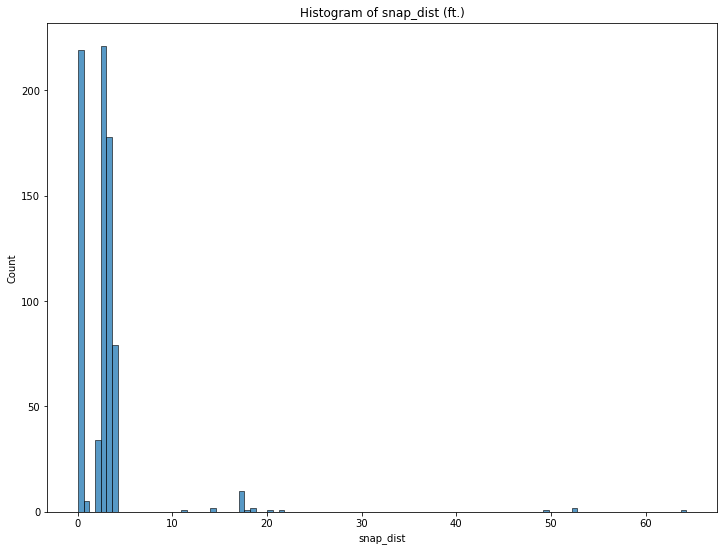

In [646]:
plt.figure(figsize=(12, 9))

sns.histplot(updated_points.snap_dist)
plt.title('Histogram of snap_dist (ft.)')

In [647]:
updated_points.iloc[:, 30:45].head()

index_right ntacode county_fips                 ntaname      boro_name  \
5             95    SI45         085  New Dorp-Midland Beach  Staten Island   
38            95    SI45         085  New Dorp-Midland Beach  Staten Island   
230           95    SI45         085  New Dorp-Midland Beach  Staten Island   
320           95    SI45         085  New Dorp-Midland Beach  Staten Island   
333           95    SI45         085  New Dorp-Midland Beach  Staten Island   

    boro_code  line_i physicalid    st_label  st_name  full_stree rw_type  \
5           5    52.0      76942  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
38          5   684.0      63096  MILTON AVE   MILTON  MILTON AVE       1   
230         5   148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
320         5   148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
333         5   148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   

    rw_type_name st_width frm_lvl_co  
5         Street       32         13  
38        Street       32         13  
230       Street       22         13  
320       Street       22         13  
333       Street       22         13

In [648]:
updated_points.physicalid.value_counts()

76941     115
52067      51
63880      40
76093      31
85564      27
         ... 
85568       1
86083       1
90275       1
105027      1
98915       1
Name: physicalid, Length: 188, dtype: int64

In [649]:
updated_points.loc[updated_points.physicalid == '76941'].iloc[:, 30:45].head()

index_right ntacode county_fips                 ntaname      boro_name  \
230           95    SI45         085  New Dorp-Midland Beach  Staten Island   
320           95    SI45         085  New Dorp-Midland Beach  Staten Island   
333           95    SI45         085  New Dorp-Midland Beach  Staten Island   
385           95    SI45         085  New Dorp-Midland Beach  Staten Island   
546           95    SI45         085  New Dorp-Midland Beach  Staten Island   

    boro_code  line_i physicalid    st_label  st_name  full_stree rw_type  \
230         5   148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
320         5   148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
333         5   148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
385         5   148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
546         5   148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   

    rw_type_name st_width frm_lvl_co  
230       Street       22         13  
320       Street       22         13  
333       Street       22         13  
385       Street       22         13  
546       Street       22         13

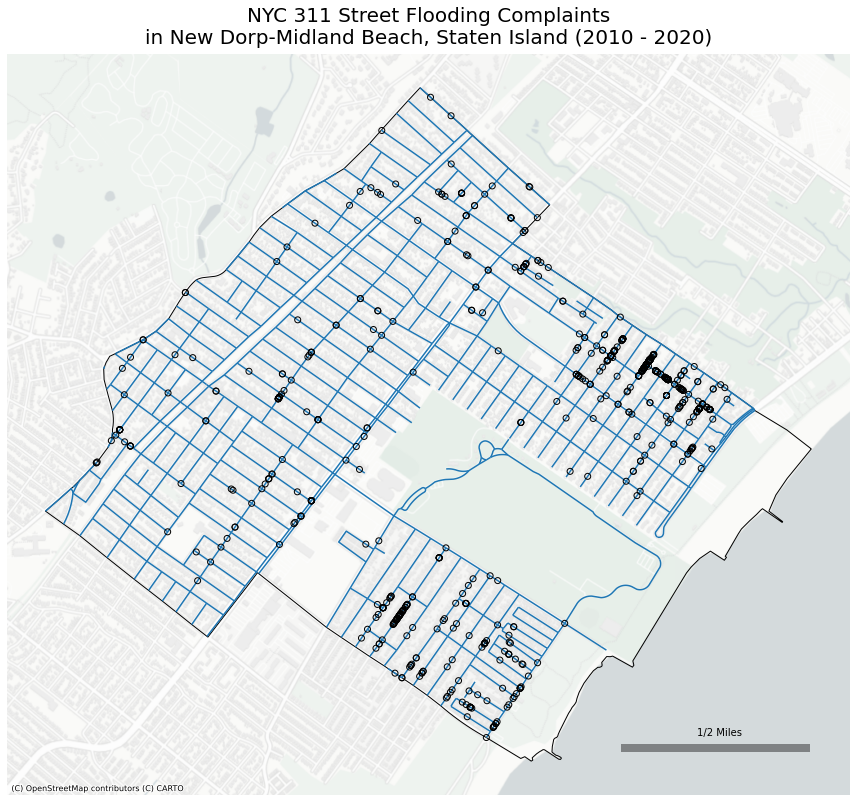

In [650]:
fig, ax = plt.subplots(figsize=(12, 12)) # creating a figure

updated_points.plot(color='none', 
                edgecolor='black',
                ax=ax,
                zorder=3)

streets_clipped.plot(ax=ax, zorder=2)

nta_shape[nta_shape.ntaname == 'New Dorp-Midland Beach'].plot(ax=ax, 
                                                              zorder=1, 
                                                              color='None', 
                                                              edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

# drawing the linke coordinates on the axis
x, y = [958000, 958000+5280/2], [143000 + 130, 143000 + 130]

# plotting the line
plt.plot(x, 
         y, 
         linewidth=8,
         color='black',
         alpha=.4, zorder=3)

# adding the scale bar text to the line
plt.text(958000 + (5280/2/2.5), 143000 + 300, '1/2 Miles', dict(size=10))

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('NYC 311 Street Flooding Complaints\nin New Dorp-Midland Beach, Staten Island (2010 - 2020)', 
             fontsize=20, 
             pad=10)

plt.axis('off')
plt.tight_layout()
# plt.savefig('figures/Arverne1.png', facecolor='w')

In [651]:
gdf_count = updated_points.groupby(by='physicalid')['created_date'].count().reset_index()

In [652]:
gdf_count.head()

physicalid  created_date
0     100411             1
1     100451             1
2     100452             2
3     100795             1
4     100822             8

In [653]:
gdf_count.rename(columns={"created_date": "count"}, inplace=True)

In [654]:
gdf_count.head()

physicalid  count
0     100411      1
1     100451      1
2     100452      2
3     100795      1
4     100822      8

In [655]:
streets_clipped.set_geometry('geometry', inplace=True)

In [656]:
streets_clipped.geom_type.value_counts()

LineString    737
dtype: int64

In [657]:
streets_clipped['new_geom'] = streets_clipped.geometry.buffer(40, cap_style=2)

streets_clipped.set_geometry('new_geom', inplace=True)

In [658]:
streets_clipped.head()

physicalid        st_label   st_name       full_stree rw_type  \
90       63908  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1   
411      98840     FREMONT AVE   FREMONT      FREMONT AVE       1   
551      64022      HAMDEN AVE    HAMDEN       HAMDEN AVE       1   
581     169350      SANCHEZ DR   SANCHEZ       SANCHEZ DR       1   
651      63915  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1   

    rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
90        Street       30         13        13        5  256.539897   
411       Street       30         13        13        5  447.066950   
551       Street       20         13        13        5   40.275747   
581       Street       18         13        13        5  176.145848   
651       Street       30         13        13        5  261.169357   

                                              geometry  \
90   LINESTRING (954781.156 151271.724, 954597.833 ...   
411  LINESTRING (952841.921 150886.337, 953221.730 ...   
551  LINESTRING (957558.853 149344.789, 957591.137 ...   
581  LINESTRING (955726.813 147175.642, 955875.554 ...   
651  LINESTRING (953360.096 149917.140, 953173.390 ...   

                                              new_geom  
90   POLYGON ((954625.814 151063.681, 954569.851 15...  
411  POLYGON ((953242.830 150684.493, 953200.630 15...  
551  POLYGON ((957615.053 149352.770, 957567.220 14...  
581  POLYGON ((955854.127 147303.776, 955896.981 14...  
651  POLYGON ((953201.360 149705.923, 953145.420 14...

In [659]:
streets_clipped.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 737 entries, 90 to 99343
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    737 non-null    object  
 1   st_label      737 non-null    object  
 2   st_name       737 non-null    object  
 3   full_stree    737 non-null    object  
 4   rw_type       737 non-null    object  
 5   rw_type_name  737 non-null    object  
 6   st_width      737 non-null    object  
 7   frm_lvl_co    737 non-null    object  
 8   to_lvl_co     737 non-null    object  
 9   borocode      737 non-null    object  
 10  shape_leng    737 non-null    float64 
 11  geometry      737 non-null    geometry
 12  new_geom      737 non-null    geometry
dtypes: float64(1), geometry(2), object(10)
memory usage: 80.6+ KB


In [660]:
# joining our nta population data to our nta shapes data
streets_with_count = streets_clipped.merge(gdf_count, 
                                           left_on='physicalid', 
                                           right_on='physicalid', 
                                           how='left')

In [661]:
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 737 entries, 0 to 736
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    737 non-null    object  
 1   st_label      737 non-null    object  
 2   st_name       737 non-null    object  
 3   full_stree    737 non-null    object  
 4   rw_type       737 non-null    object  
 5   rw_type_name  737 non-null    object  
 6   st_width      737 non-null    object  
 7   frm_lvl_co    737 non-null    object  
 8   to_lvl_co     737 non-null    object  
 9   borocode      737 non-null    object  
 10  shape_leng    737 non-null    float64 
 11  geometry      737 non-null    geometry
 12  new_geom      737 non-null    geometry
 13  count         188 non-null    float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 86.4+ KB


In [662]:
streets_with_count['count'].fillna(0, inplace=True)

In [663]:
streets_with_count[['count']].isna().sum()

count    0
dtype: int64

In [664]:
streets_with_count.head()

physicalid        st_label   st_name       full_stree rw_type rw_type_name  \
0      63908  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1       Street   
1      98840     FREMONT AVE   FREMONT      FREMONT AVE       1       Street   
2      64022      HAMDEN AVE    HAMDEN       HAMDEN AVE       1       Street   
3     169350      SANCHEZ DR   SANCHEZ       SANCHEZ DR       1       Street   
4      63915  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1       Street   

  st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       30         13        13        5  256.539897   
1       30         13        13        5  447.066950   
2       20         13        13        5   40.275747   
3       18         13        13        5  176.145848   
4       30         13        13        5  261.169357   

                                            geometry  \
0  LINESTRING (954781.156 151271.724, 954597.833 ...   
1  LINESTRING (952841.921 150886.337, 953221.730 ...   
2  LINESTRING (957558.853 149344.789, 957591.137 ...   
3  LINESTRING (955726.813 147175.642, 955875.554 ...   
4  LINESTRING (953360.096 149917.140, 953173.390 ...   

                                            new_geom  count  
0  POLYGON ((954625.814 151063.681, 954569.851 15...    0.0  
1  POLYGON ((953242.830 150684.493, 953200.630 15...    0.0  
2  POLYGON ((957615.053 149352.770, 957567.220 14...    0.0  
3  POLYGON ((955854.127 147303.776, 955896.981 14...    0.0  
4  POLYGON ((953201.360 149705.923, 953145.420 14...    0.0

In [665]:
streets_with_count.sort_values(by='count', ascending=False).head()

physicalid      st_label   st_name    full_stree rw_type rw_type_name  \
148      76941    GRIMSBY ST   GRIMSBY    GRIMSBY ST       1       Street   
574      52067    KISWICK ST   KISWICK    KISWICK ST       1       Street   
252      63880      WEED AVE      WEED      WEED AVE       1       Street   
473      76093  MAPLETON AVE  MAPLETON  MAPLETON AVE       1       Street   
118      85564      BADEN PL     BADEN      BADEN PL       1       Street   

    st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
148       22         13        13        5  372.786118   
574       38         13        13        5  549.294789   
252       32         13        13        5  766.375339   
473       25         13        13        5  248.849478   
118       32         13        13        5  454.064519   

                                              geometry  \
148  LINESTRING (958533.655 149022.834, 958315.338 ...   
574  LINESTRING (958113.203 149295.665, 957794.955 ...   
252  LINESTRING (954903.616 145334.160, 954463.348 ...   
473  LINESTRING (958524.695 148581.558, 958726.633 ...   
118  LINESTRING (959135.084 148145.979, 958868.434 ...   

                                              new_geom  count  
148  POLYGON ((958347.761 148697.237, 958282.915 14...  115.0  
574  POLYGON ((957827.558 148824.781, 957762.353 14...   51.0  
252  POLYGON ((954496.089 144683.889, 954430.607 14...   40.0  
473  POLYGON ((958750.008 148468.598, 958703.259 14...   31.0  
118  POLYGON ((958900.810 147754.966, 958836.058 14...   27.0

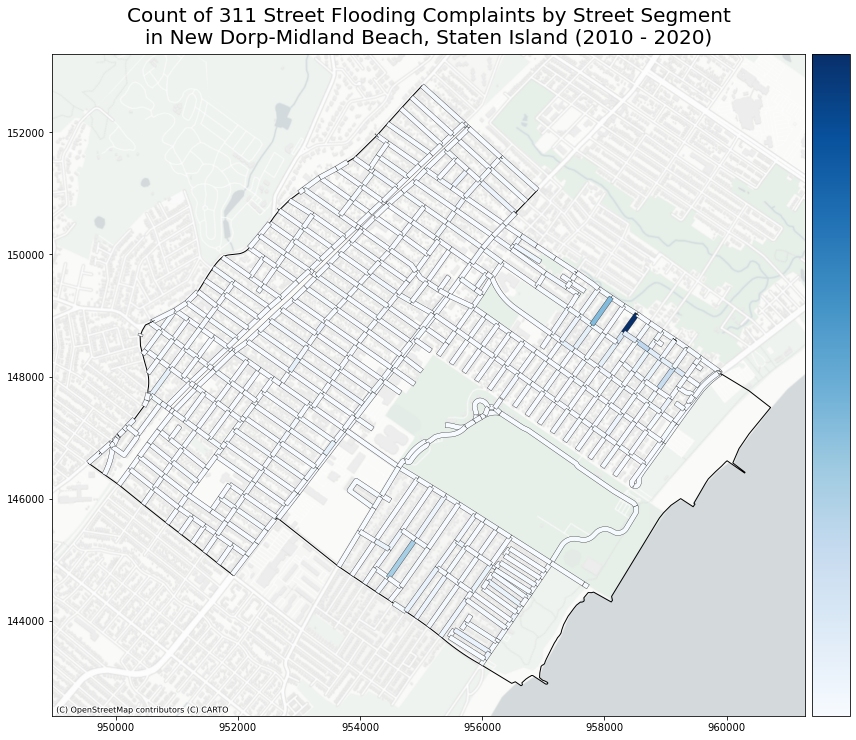

In [666]:
fig, ax = plt.subplots(figsize=(12, 12)) # creating figure

# saving variable to format integers as strings with commas
comma_fmt = FuncFormatter(lambda x, p: format(int(x), ','))

# resizing the color bar to scale to the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(column='count', 
                        ax=ax, # plotting on the generated axis
                        cax=cax, # legend of the color bar
                        zorder=2,                        
                        cmap='Blues',
                        edgecolor='black',
                        linewidth=.3,
                        legend=True)

nta_shape[nta_shape.ntaname == 'New Dorp-Midland Beach'].plot(ax=ax, 
                                                              zorder=1, 
                                                              color='None', 
                                                              edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)


ax.set_aspect('equal', 'box')

# setting title
ax.set_title('Count of 311 Street Flooding Complaints by Street Segment\nin New Dorp-Midland Beach, Staten Island (2010 - 2020)', 
             fontsize=20, 
             pad=10)

plt.axis('off')
plt.tight_layout()
# plt.savefig('figures/Arverne1.png', facecolor='w')

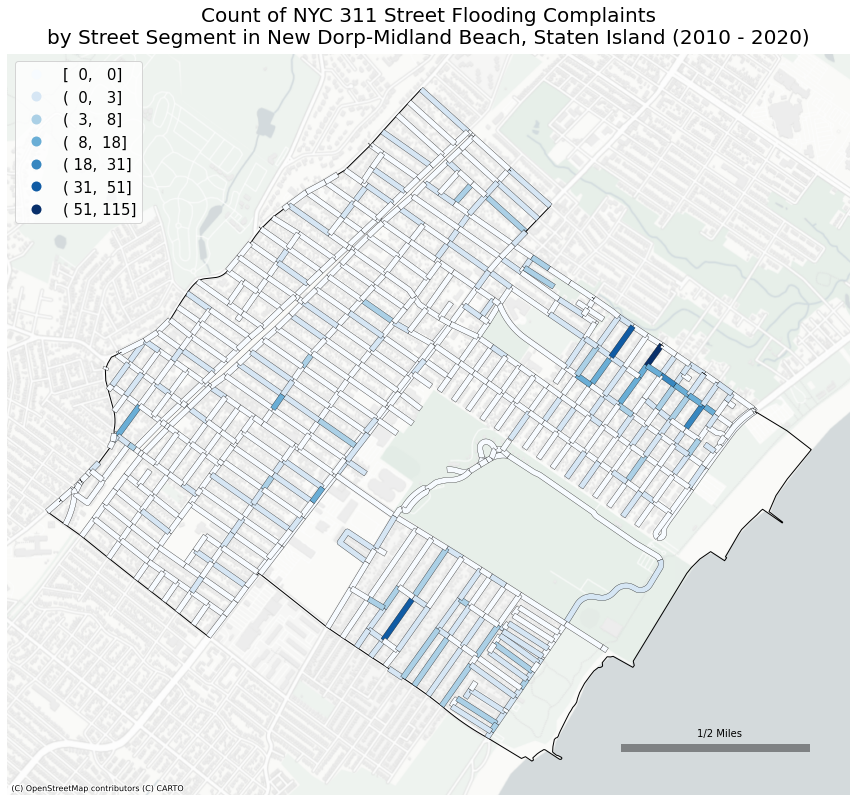

In [667]:
fig, ax = plt.subplots(figsize=(12, 12)) # creating figure

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(column='count', 
                        ax=ax, # plotting on the generated axis
                        zorder=2,
                        cmap='Blues',
                        edgecolor='black',
                        linewidth=.3,
                        legend=True, 
                        scheme='fisherjenks',
                        k=7,
                        legend_kwds={'loc': "upper left", 
                                              'fmt': "{:,.0f}",
                                              'fontsize': "15"})

nta_shape[nta_shape.ntaname == 'New Dorp-Midland Beach'].plot(ax=ax, 
                                                              zorder=1, 
                                                              color='None', 
                                                              edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

# drawing the linke coordinates on the axis
x, y = [958000, 958000+5280/2], [143000 + 130, 143000 + 130]

# plotting the line
plt.plot(x, 
         y, 
         linewidth=8,
         color='black',
         alpha=.4, zorder=3)

# adding the scale bar text to the line
plt.text(958000 + (5280/2/2.5), 143000 + 300, '1/2 Miles', dict(size=10))


ax.set_aspect('equal', 'box')

# setting title
ax.set_title('Count of NYC 311 Street Flooding Complaints\nby Street Segment in New Dorp-Midland Beach, Staten Island (2010 - 2020)', 
             fontsize=20, 
             pad=10)

plt.axis('off')
plt.tight_layout()
# plt.savefig('figures/Arverne1.png', facecolor='w')

In [668]:
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 737 entries, 0 to 736
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    737 non-null    object  
 1   st_label      737 non-null    object  
 2   st_name       737 non-null    object  
 3   full_stree    737 non-null    object  
 4   rw_type       737 non-null    object  
 5   rw_type_name  737 non-null    object  
 6   st_width      737 non-null    object  
 7   frm_lvl_co    737 non-null    object  
 8   to_lvl_co     737 non-null    object  
 9   borocode      737 non-null    object  
 10  shape_leng    737 non-null    float64 
 11  geometry      737 non-null    geometry
 12  new_geom      737 non-null    geometry
 13  count         737 non-null    float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 86.4+ KB


In [669]:
streets_with_count['shape_leng'] = streets_with_count.geometry.length

In [670]:
streets_with_count.length.describe()

count     737.000000
mean      852.519540
std       464.511570
min       160.000006
25%       657.049620
50%       689.688260
75%      1084.789133
max      5557.842467
dtype: float64

In [671]:
streets_with_count.describe()

shape_leng       count
count   737.000000  737.000000
mean    852.519540    1.028494
std     464.511570    5.347490
min     160.000006    0.000000
25%     657.049620    0.000000
50%     689.688260    0.000000
75%    1084.789133    1.000000
max    5557.842467  115.000000

In [672]:
streets_with_count['count_per_100ft'] = (streets_with_count['count'] / streets_with_count['shape_leng']) * 100

streets_with_count.head()

physicalid        st_label   st_name       full_stree rw_type rw_type_name  \
0      63908  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1       Street   
1      98840     FREMONT AVE   FREMONT      FREMONT AVE       1       Street   
2      64022      HAMDEN AVE    HAMDEN       HAMDEN AVE       1       Street   
3     169350      SANCHEZ DR   SANCHEZ       SANCHEZ DR       1       Street   
4      63915  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1       Street   

  st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
0       30         13        13        5   673.079794   
1       30         13        13        5  1054.133640   
2       20         13        13        5   240.551494   
3       18         13        13        5   512.291697   
4       30         13        13        5   682.338714   

                                            geometry  \
0  LINESTRING (954781.156 151271.724, 954597.833 ...   
1  LINESTRING (952841.921 150886.337, 953221.730 ...   
2  LINESTRING (957558.853 149344.789, 957591.137 ...   
3  LINESTRING (955726.813 147175.642, 955875.554 ...   
4  LINESTRING (953360.096 149917.140, 953173.390 ...   

                                            new_geom  count  count_per_100ft  
0  POLYGON ((954625.814 151063.681, 954569.851 15...    0.0              0.0  
1  POLYGON ((953242.830 150684.493, 953200.630 15...    0.0              0.0  
2  POLYGON ((957615.053 149352.770, 957567.220 14...    0.0              0.0  
3  POLYGON ((955854.127 147303.776, 955896.981 14...    0.0              0.0  
4  POLYGON ((953201.360 149705.923, 953145.420 14...    0.0              0.0

In [673]:
streets_with_count.describe()

shape_leng       count  count_per_100ft
count   737.000000  737.000000       737.000000
mean    852.519540    1.028494         0.119461
std     464.511570    5.347490         0.586599
min     160.000006    0.000000         0.000000
25%     657.049620    0.000000         0.000000
50%     689.688260    0.000000         0.000000
75%    1084.789133    1.000000         0.056918
max    5557.842467  115.000000        12.699153

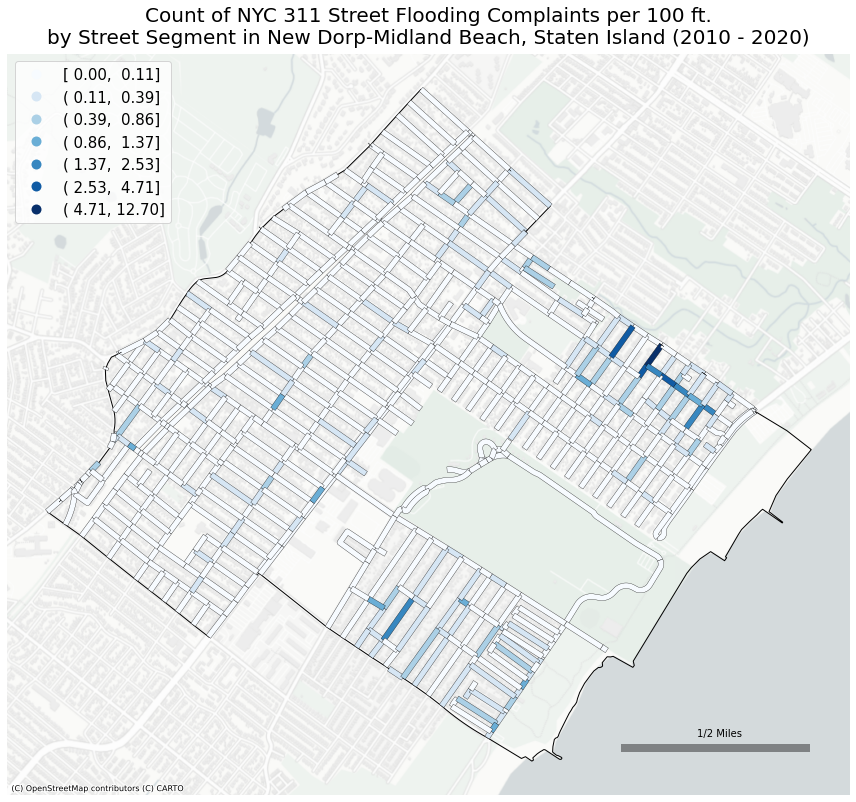

In [674]:
fig, ax = plt.subplots(figsize=(12, 12)) # creating figure

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(column='count_per_100ft', 
                        ax=ax, # plotting on the generated axis
                        zorder=2,
                        cmap='Blues',
                        edgecolor='black',
                        linewidth=.3,
                        legend=True, 
                        scheme='fisherjenks',
                        k=7,
                        legend_kwds={'loc': "upper left", 
                                              'fmt': "{:,.2f}",
                                              'fontsize': "15"})

nta_shape[nta_shape.ntaname == 'New Dorp-Midland Beach'].plot(ax=ax, 
                                                              zorder=1, 
                                                              color='None', 
                                                              edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

# drawing the linke coordinates on the axis
x, y = [958000, 958000+5280/2], [143000 + 130, 143000 + 130]

# plotting the line
plt.plot(x, 
         y, 
         linewidth=8,
         color='black',
         alpha=.4, zorder=3)

# adding the scale bar text to the line
plt.text(958000 + (5280/2/2.5), 143000 + 300, '1/2 Miles', dict(size=10))

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('Count of NYC 311 Street Flooding Complaints per 100 ft.\nby Street Segment in New Dorp-Midland Beach, Staten Island (2010 - 2020)', 
             fontsize=20, 
             pad=10)

plt.axis('off')
plt.tight_layout()

plt.savefig('figures/midland-beach.png')

<AxesSubplot:>

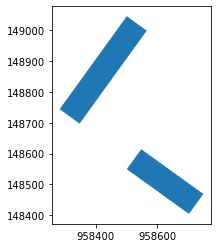

In [675]:
streets_with_count.sort_values(by='count_per_100ft', ascending=False).head(2).plot()

In [676]:
streets_with_count.sort_values(by='count_per_100ft', ascending=False).head()

physicalid      st_label   st_name    full_stree rw_type rw_type_name  \
148      76941    GRIMSBY ST   GRIMSBY    GRIMSBY ST       1       Street   
473      76093  MAPLETON AVE  MAPLETON  MAPLETON AVE       1       Street   
574      52067    KISWICK ST   KISWICK    KISWICK ST       1       Street   
52       76942    GRIMSBY ST   GRIMSBY    GRIMSBY ST       1       Street   
118      85564      BADEN PL     BADEN      BADEN PL       1       Street   

    st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
148       22         13        13        5   905.572235   
473       25         13        13        5   657.698955   
574       38         13        13        5  1258.589579   
52        32         13        13        5   554.966971   
118       32         13        13        5  1068.129038   

                                              geometry  \
148  LINESTRING (958533.655 149022.834, 958315.338 ...   
473  LINESTRING (958524.695 148581.558, 958726.633 ...   
574  LINESTRING (958113.203 149295.665, 957794.955 ...   
52   LINESTRING (958315.338 148720.663, 958202.776 ...   
118  LINESTRING (959135.084 148145.979, 958868.434 ...   

                                              new_geom  count  count_per_100ft  
148  POLYGON ((958347.761 148697.237, 958282.915 14...  115.0        12.699153  
473  POLYGON ((958750.008 148468.598, 958703.259 14...   31.0         4.713403  
574  POLYGON ((957827.558 148824.781, 957762.353 14...   51.0         4.052155  
52   POLYGON ((958235.642 148535.600, 958169.910 14...   18.0         3.243436  
118  POLYGON ((958900.810 147754.966, 958836.058 14...   27.0         2.527784

In [677]:
streets_with_count['count'].sum()

758.0